# ORIE 4741 - Exploring Wine

In [1]:
# Here we import everything we need to explore our data.

import pandas as pd
import numpy as np
import scipy.stats as scipy
import scipy.linalg
import matplotlib.pyplot as py
import matplotlib
import random
%matplotlib inline

## Importing our Data

#### Our first approach was to import data using python’s pandas.read_csv

#### Issues

The first issue we ran into occurred when we inspected our raw data in Excel. We noticed that many of the foreign characters such as ‘é’ were not being displayed properly in our imported dataset (see Figure 1.1). This concerned us because the interpretability of the dataset was difficult for potential readers and us; however, after some research on UnicodeDecodeError’s (such as the one given below), we found the problem to be that Excel expected characters to be encoded as UTF-8*. The incorrect outputs were a result of UTF-8 only including ASCII characters; however, our data had a significant amount of non-ASCII characters. 

UnicodeDecodeError: 'utf8' codec can't decode byte 0xa5 in position 0: invalid start byte

*UTF-8 is a character encoding capable of encoding all 1,112,064 valid code points in Unicode using one to four 8-bit bytes.

#### Examples of some issues

See Table in Latex File (Figure 1.1)

#### Initial attempts to fix the encoding issues

We initially tried changing the file type and even starting writing code to replace strange character sequences. This process was labor intensive and took way too long. Then we thought it would make sense to simply remove the data containing any foreign characters and in doing so, learned our dataset was biased towards non-foreign wines and reviews. 

1. Tried changing the excel file’s character encoding.
2. Tried changing the .csv file’s character encoding.
3. Tried using “Apple Numbers” (an excel equivalent) to see if we could encode foreign characters.
4. Tried using Business Intelligence software (Microsoft Power BI) to identify and replace character patterns with an ASCII equivalent (i.e., changing ‘Ã©’ which was supposed to be an ‘é’ to ‘e’). This was time intensive and was not a practical approach.
5. Tried reading the dataset into a .ipynb using Python’s pandas.read_csv; However, one main issue we had was the presence of commas in reviews. This caused our data to transform the fields of those particular examples from the expected 11 fields to over 140. We recognize this transformation as an error in read_csv and our data which added onto our foreign language issues.

#### Understanding our root problem

Our root problem was the character encoding of a .csv file in which our data was stored. 

#### Our solution

We ended up using .json files instead of .csv to store our data. This type of file does not allow us to examine our raw data in Excel, but when importing the file into the .ipynb notebook we found that the method pandas.read_json read-in foreign languages efficiently and accurately without causing the fields to expand or transform. This was mainly a benefit of how .json files structure and store data in defined fields while also including the correct encodings for reading numbers as Float64 rather than strings. 


In [2]:
df = pd.read_json('/Users/alexanderdowney/Downloads/winemag-data_first150k.json')

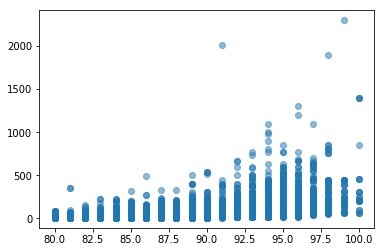

In [3]:
py.scatter(df['points'],df['price'],alpha=0.5)
py.show()
size_of_dataset=[]
size_of_dataset.append(len(df))

In [4]:
df_store=df

### First Step of Cleaning the Dataset 

We noticed that we had some "odd" countries that we didn't expect to see. Also they had a very limited amount of data points and thus would not be helpful in predicting prices for more "common" countries. 

In [5]:
countries = df['country'].unique()
country_count=[]
countries_kept = []
for i in range(0,len(countries)):
    country_count.append(len(df.loc[df['country'] == countries[i]]))
    print(countries[i],len(df.loc[df['country'] == countries[i]]))
for j in range(0,len(countries)):
    if country_count[j]>500:
        countries_kept.append(countries[j])
df = df[df['country'].isin(countries_kept)]
size_of_dataset.append(len(df))

US 62397
Spain 8268
France 21098
Italy 23478
New Zealand 3320
Bulgaria 77
Argentina 5631
Australia 4957
Portugal 5322
Israel 630
South Africa 2258
Greece 884
Chile 5816
Morocco 12
Romania 139
Germany 2452
Canada 196
Moldova 71
Hungary 231
Austria 3057
Croatia 89
Slovenia 94
None 0
India 8
Turkey 52
Macedonia 16
Lebanon 37
Serbia 14
Uruguay 92
Switzerland 4
Albania 2
Bosnia and Herzegovina 4
Brazil 25
Cyprus 31
Lithuania 8
Japan 2
China 3
South Korea 4
Ukraine 5
England 9
Mexico 63
Georgia 43
Montenegro 2
Luxembourg 9
Slovakia 3
Czech Republic 6
Egypt 3
Tunisia 2
US-France 1


### Removing NaN's from our points & price columns

Examining our data some more we realize we have some values in price (our output vector) which are NaN. See index 150922 for an example. We proceed to remove these values.

We selected only the points and price columns as a means for identifying NaNs to remove. Our rationale for only using these columns is some wines have more detailed regions and sub-regions vs others, this is not a data entry error but simply due to industry structure and classification systems. 

In [6]:
## Look at the NaN at 150922!
df['price']

0         235.0
1         110.0
2          90.0
3          65.0
4          66.0
5          73.0
6          65.0
7         110.0
8          65.0
9          60.0
10         80.0
11         48.0
12         48.0
13         90.0
14        185.0
15         90.0
16        325.0
17         80.0
18        290.0
19         75.0
20         24.0
21         79.0
22        220.0
23         60.0
24         45.0
25         57.0
26         62.0
27        105.0
28         60.0
29         60.0
          ...  
150900     13.0
150901     12.0
150902     10.0
150903      7.0
150904     10.0
150905     13.0
150906     65.0
150907     52.0
150908     65.0
150909     52.0
150910     38.0
150911     37.0
150912     65.0
150913     30.0
150914     25.0
150915     30.0
150916     65.0
150917     30.0
150918     38.0
150919     37.0
150920     19.0
150921     38.0
150922      NaN
150923     30.0
150924     70.0
150925     20.0
150926     27.0
150927     20.0
150928     52.0
150929     15.0
Name: price, Length: 149

In [7]:
df = df[np.isfinite(df['price'])]
df = df[np.isfinite(df['points'])]

### Exploring our Data some more by finding implict price distributions

This is fitting a t-distribution to the Price data

Moments MVSK are as follows: 23.57478531143802 inf nan nan



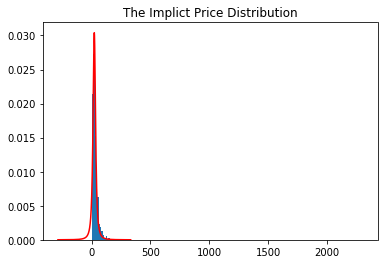

In [8]:
print("This is fitting a t-distribution to the Price data")
print()
dfd, loc, scale = (scipy.stats.t.fit(df['price']))
mean, var, skew, kurt = scipy.stats.t.stats(dfd, loc, scale, moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)
print()
x = np.linspace(scipy.stats.t.ppf(0.001, dfd, loc, scale),scipy.stats.t.ppf(0.999, dfd, loc, scale), 1000)
py.plot(x, scipy.stats.t.pdf(x, dfd, loc, scale),'r-')
py.hist(df['price'],bins=200,normed=1)
py.title('The Implict Price Distribution')
py.show()

This is fitting a exponential-distribution to the Price data

Moments MVSK are as follows: 33.19055303064944 852.088386243031 2.0 6.0


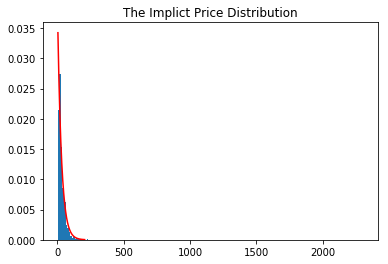

In [9]:
print("This is fitting a exponential-distribution to the Price data")
print()
dfd, loc = (scipy.stats.expon.fit(df['price']))
mean, var, skew, kurt = scipy.stats.expon.stats(dfd, loc,moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)

x = np.linspace(scipy.stats.expon.ppf(0.001, dfd, loc),scipy.stats.expon.ppf(0.999, dfd, loc), 1000)
py.plot(x, scipy.stats.expon.pdf(x, dfd, loc),'r-')
py.hist(df['price'],bins=200,normed=1)
py.title('The Implict Price Distribution')
py.show()

### Looking at the points distribution

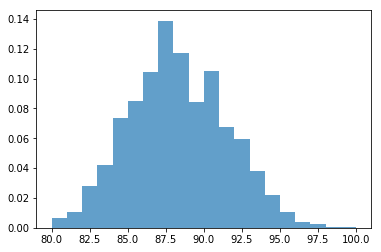

In [10]:
py.hist(df['points'],bins=20,normed=1,alpha=0.7)
py.show()

This is fitting a normal-distribution to the Points data

Moments MVSK are as follows: 87.80164814951071 10.368441106721427 0.0 0.0



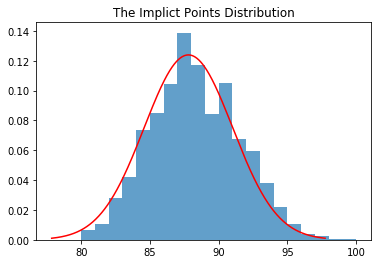

In [11]:
print("This is fitting a normal-distribution to the Points data")
print()
dfd, loc = (scipy.stats.norm.fit(df['points']))
mean, var, skew, kurt = scipy.stats.norm.stats(dfd, loc, moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)
print()
x = np.linspace(scipy.stats.norm.ppf(0.001, dfd, loc),scipy.stats.norm.ppf(0.999, dfd, loc), 1000)
py.plot(x, scipy.stats.norm.pdf(x, dfd, loc),'r-')
py.hist(df['points'],bins=20,normed=1,alpha=0.7)
py.title('The Implict Points Distribution')
py.show()

This is fitting a t-distribution to the Points data

Moments MVSK are as follows: 87.80147021535227 10.3684263499024 0.0 9.579444076054575e-07



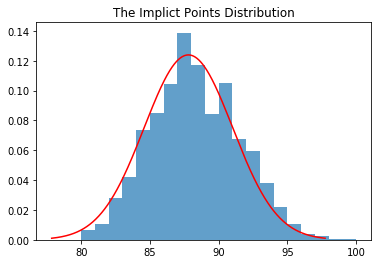

In [12]:
print("This is fitting a t-distribution to the Points data")
print()
dfd, loc, scale = (scipy.stats.t.fit(df['points']))
mean, var, skew, kurt = scipy.stats.t.stats(dfd, loc, scale, moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)
print()
x = np.linspace(scipy.stats.t.ppf(0.001, dfd, loc, scale),scipy.stats.t.ppf(0.999, dfd, loc,scale), 1000)
py.plot(x, scipy.stats.t.pdf(x, dfd, loc,scale),'r-')
py.hist(df['points'],bins=20,normed=1,alpha=0.7)
py.title('The Implict Points Distribution')
py.show()

### Exploring the Average Price per Country

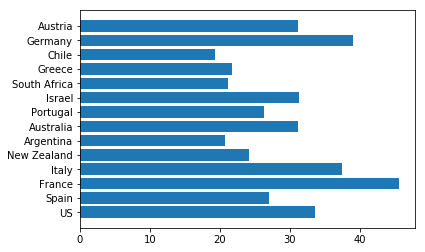

In [13]:
Average_Price_Per_Region=[]
for i in range(0,len(countries_kept)):
    Average_Price_Per_Region.append(np.mean(df.loc[df['country'] == countries_kept[i]]['price']))

y_pos = np.arange(len(Average_Price_Per_Region))
py.barh(y_pos, Average_Price_Per_Region, align='center')
py.yticks(y_pos, countries_kept)
py.show()

### Exploring the Average Points per Country

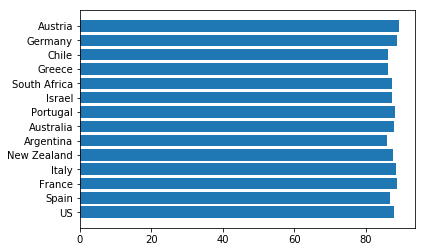

In [14]:
Average_Points_Per_Region=[]
for i in range(0,len(countries_kept)):
    Average_Points_Per_Region.append(np.mean(df.loc[df['country'] == countries_kept[i]]['points']))

y_pos = np.arange(len(Average_Points_Per_Region))
py.barh(y_pos, Average_Points_Per_Region, align='center')
py.yticks(y_pos, countries_kept)
py.show()

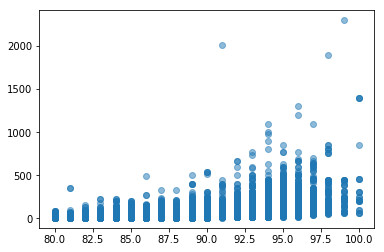

In [15]:
py.scatter(df['points'],df['price'],alpha=0.5)
py.show()
size_of_dataset=[]
size_of_dataset.append(len(df))

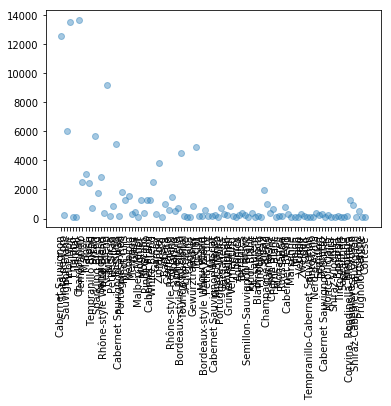

In [16]:
amount_of_varieties = len(df['variety'].unique())
varietal = df['variety'].unique()
varietals = []
amount_of_each_variety = []
fig, ax = py.subplots()
Tol = 74


for i in range(0,amount_of_varieties):
    if len(df.loc[df['variety'] == varietal[i]]) > Tol:
        amount_of_each_variety.append(len(df.loc[df['variety'] == varietal[i]]))
        varietals.append(varietal[i])
py.scatter(np.arange(len(varietals)),amount_of_each_variety,alpha=0.4)
ax.set_xticklabels(varietals)
py.xticks(np.arange(len(varietals)),varietals,rotation='vertical')
py.show()

In [17]:
print("The median price of wine in our data set is",np.median(amount_of_each_variety))

The median price of wine in our data set is 310.5


In [18]:
print("We have",np.size(varietals),"varietals in our cleaned data set")

We have 100 varietals in our cleaned data set


In [19]:
df = df[df['variety'].isin(varietals)]
size_of_dataset.append(len(df))

In [20]:
countries_kpt = df['country'].unique()
dummy = pd.get_dummies(df['country'])
country_dummy = []
for i in range(0,len(df['country'].unique())):
    country_dummy.append(dummy[countries_kpt[i]])

In [21]:
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],np.ones(len(df['points']))]
y = df['price'].as_matrix()
X[0], y[0]
print(X)
X_points = df[['points']].as_matrix()
X_points= np.c_[X_points,np.ones(len(df['points']))]
y = df['price'].as_matrix()
X[0], y[0]

X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],np.ones(len(df['points']))]
y = df['price'].as_matrix()
X[50], y[50]


[[ 96.   1.   0. ...,   0.   0.   1.]
 [ 96.   0.   1. ...,   0.   0.   1.]
 [ 96.   1.   0. ...,   0.   0.   1.]
 ..., 
 [ 91.   0.   0. ...,   0.   0.   1.]
 [ 90.   0.   0. ...,   0.   0.   1.]
 [ 90.   0.   0. ...,   0.   0.   1.]]


(array([ 90.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]), 18.0)

In [22]:
np.linalg.lstsq(X,y)[0]

array([  5.09496473e+00,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
        -2.36331863e+12])

In [23]:
m,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,c = np.linalg.lstsq(X,y)[0]
print(np.linalg.lstsq(X,y)[0])
w,c1 = np.linalg.lstsq(X_points,y)[0]
print(np.linalg.lstsq(X_points,y)[0])

[  5.09496473e+00   2.36331863e+12   2.36331863e+12   2.36331863e+12
   2.36331863e+12   2.36331863e+12   2.36331863e+12   2.36331863e+12
   2.36331863e+12   2.36331863e+12   2.36331863e+12   2.36331863e+12
   2.36331863e+12   2.36331863e+12   2.36331863e+12  -2.36331863e+12]
[   5.24996669 -427.5377278 ]


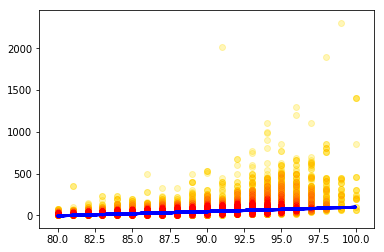

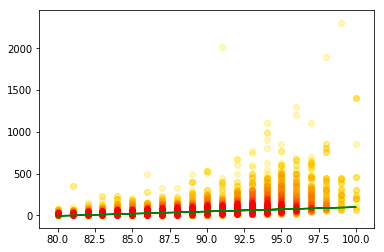

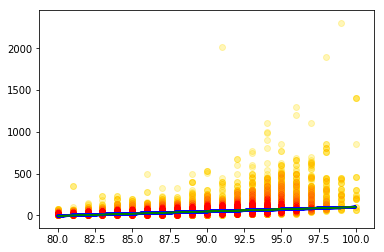

In [24]:
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+c,'b')
py.show()
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],w*df['points']+c1,'g')
py.show()
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+c,'b')
py.plot(df['points'],w*df['points']+c1,'g')
py.show()

In [25]:
error = w*df['points']+c1-(m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+m3+c)
print("How many data points does the simple regression predict a higher price?",len(np.where(error>0)[0]))
np.mean(error)
np.std(error)

How many data points does the simple regression predict a higher price? 0


4.371160453520204

# Feature engineering for variety

In [26]:
varieties_kpt = df['variety'].unique()
dummy_variety = pd.get_dummies(df['variety'])
country_variety = []
for i in range(0,len(df['variety'].unique())):
    country_variety.append(dummy_variety[varieties_kpt[i]])

# Decision Trees

In [27]:
from sklearn import tree
import graphviz

In [28]:
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],country_variety[0],country_variety[1],country_variety[2],country_variety[3],country_variety[4],country_variety[5],country_variety[6],country_variety[7],country_variety[8],country_variety[9],country_variety[10],country_variety[11],country_variety[12],country_variety[13],country_variety[14],country_variety[15],country_variety[16],country_variety[17],country_variety[18],country_variety[19],country_variety[20],country_variety[21],country_variety[22],country_variety[23],country_variety[24],country_variety[25],country_variety[26],country_variety[27],country_variety[28],country_variety[29],country_variety[30],country_variety[31],country_variety[32],country_variety[33],country_variety[34],country_variety[35],country_variety[36],country_variety[37],country_variety[38],country_variety[39],country_variety[40],country_variety[41],country_variety[42],country_variety[43],country_variety[44],country_variety[45],country_variety[46],country_variety[47],country_variety[48],country_variety[49],country_variety[50],country_variety[51],country_variety[52],country_variety[53],country_variety[54],country_variety[55],country_variety[56],country_variety[57],country_variety[58],country_variety[59],country_variety[60],country_variety[61],country_variety[62],country_variety[63],country_variety[64],country_variety[65],country_variety[66],country_variety[67],country_variety[68],country_variety[69],country_variety[70],country_variety[71],country_variety[72],country_variety[73],country_variety[74],country_variety[75],country_variety[76],country_variety[77],country_variety[78],country_variety[79],country_variety[80],country_variety[81],country_variety[82],country_variety[83],country_variety[84],country_variety[85],country_variety[86],country_variety[87],country_variety[88],country_variety[89],country_variety[90],country_variety[91],country_variety[92],country_variety[93],country_variety[94],country_variety[95],country_variety[96],country_variety[97],country_variety[98],country_variety[99],np.ones(len(df['points']))]
Y = df['price'].as_matrix()
clf = tree.DecisionTreeClassifier(max_depth=20)
clf = clf.fit(X, Y)
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

[  3.16859871e+04   1.98463449e+02   1.32098339e+02   1.16569165e+02
   1.15188661e+02   1.03449519e+02   9.88610174e+01   9.06486597e+01
   8.62492118e+01   8.10278821e+01   7.97747512e+01   7.57872886e+01
   7.35137261e+01   7.24034428e+01   7.10728204e+01   6.57719686e+01
   6.29665175e+01   5.67095435e+01   5.29136823e+01   5.14212247e+01
   5.00904178e+01   4.91629802e+01   4.84351024e+01   4.61649767e+01
   4.41667140e+01   4.19952482e+01   3.96293754e+01   3.79999637e+01
   3.73259349e+01   3.63089824e+01   3.57102719e+01   3.56231062e+01
   3.55108957e+01   3.50785294e+01   3.39280178e+01   3.37775745e+01
   3.21341259e+01   3.09207030e+01   3.04108764e+01   2.97029964e+01
   2.84316410e+01   2.75136803e+01   2.66453662e+01   2.59678871e+01
   2.55910425e+01   2.49440881e+01   2.45138851e+01   2.44017517e+01
   2.38031151e+01   2.25885925e+01   2.24006632e+01   2.22290802e+01
   2.15561150e+01   2.09682683e+01   2.02055120e+01   1.95807382e+01
   1.92401727e+01   1.90648851e+01

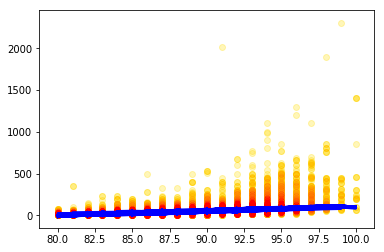

In [29]:
m,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,c = np.linalg.lstsq(X,y)[0]
print((np.linalg.lstsq(X,y))[3])
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+v0*country_variety[0]+v1*country_variety[1]+v2*country_variety[2]+v3*country_variety[3]+v4*country_variety[4]+v5*country_variety[5]+v6*country_variety[6]+v7*country_variety[7]+v8*country_variety[8]+v9*country_variety[9]+v10*country_variety[10]+v11*country_variety[11]+v12*country_variety[12]+v13*country_variety[13]+v14*country_variety[14]+v15*country_variety[15]+v16*country_variety[16]+v17*country_variety[17]+v18*country_variety[18]+v19*country_variety[19]+v20*country_variety[20]+v21*country_variety[21]+v22*country_variety[22]+v23*country_variety[23]+v24*country_variety[24]+v25*country_variety[25]+v26*country_variety[26]+v27*country_variety[27]+v28*country_variety[28]+v29*country_variety[29]+v30*country_variety[30]+v31*country_variety[31]+v32*country_variety[32]+v33*country_variety[33]+v34*country_variety[34]+v35*country_variety[35]+v36*country_variety[36]+v37*country_variety[37]+v38*country_variety[38]+v39*country_variety[39]+v40*country_variety[40]+v41*country_variety[41]+v42*country_variety[42]+v43*country_variety[43]+v44*country_variety[44]+v45*country_variety[45]+v46*country_variety[46]+v47*country_variety[47]+v48*country_variety[48]+v49*country_variety[49]+v50*country_variety[50]+v51*country_variety[51]+v52*country_variety[52]+v53*country_variety[53]+v54*country_variety[54]+v55*country_variety[55]+v56*country_variety[56]+v57*country_variety[57]+v58*country_variety[58]+v59*country_variety[59]+v60*country_variety[60]+v61*country_variety[61]+v62*country_variety[62]+v63*country_variety[63]+v64*country_variety[64]+v65*country_variety[65]+v66*country_variety[66]+v67*country_variety[67]+v68*country_variety[68]+v69*country_variety[69]+v70*country_variety[70]+v71*country_variety[71]+v72*country_variety[72]+v73*country_variety[73]+v74*country_variety[74]+v75*country_variety[75]+v76*country_variety[76]+v77*country_variety[77]+v78*country_variety[78]+v79*country_variety[79]+v80*country_variety[80]+v81*country_variety[81]+v82*country_variety[82]+v83*country_variety[83]+v84*country_variety[84]+v85*country_variety[85]+v86*country_variety[86]+v87*country_variety[87]+v88*country_variety[88]+v89*country_variety[89]++v90*country_variety[90]+v91*country_variety[91]+v92*country_variety[92]+v93*country_variety[93]+v94*country_variety[94]+v95*country_variety[95]+v96*country_variety[96]+v97*country_variety[97]+v98*country_variety[98]+v99*country_variety[99]+c,'b')
py.show()

**The Decision Tree algorithm uses the Gini index to calculate the impurity in each node, minimizing this resulting impurity at each split.**

In [30]:
def R2_score(y_pred,y_true):
    # u is the residual sum of squares
    u = ((y_true - y_pred) ** 2).sum()
    # v is the total sum of squares
    v = ((y_true - y_true.mean()) ** 2).sum()
    return (1-u/v)

In [31]:
variety_1 = ['Cabernet Sauvignon','Tinta de Toro','Sauvignon Blanc','Pinot Noir','Friulano','Tannat','Chardonnay','Tempranillo','Malbec','Rosé','Tempranillo Blend','Syrah','Sparkling Blend','Sangiovese','Rhône-style White Blend','Red Blend','Mencía','Petite Sirah','Riesling','Cabernet Sauvignon-Syrah','Portuguese Red','Pinot Gris','Nebbiolo','Meritage','Glera','Malbec-Merlot','Viognier','Moscato','Pinot Grigio','Cabernet Franc','White Blend','Gamay','Zinfandel','Greco','Barbera','Grenache']
variety_2 = ['Rhône-style Red Blend','Albariño','Carmenère','Bordeaux-style Red Blend','Touriga Nacional','Agiorgitiko','Godello','Gewürztraminer','Merlot','G-S-M','Mourvèdre','Bordeaux-style White Blend','Petit Verdot','Muscat','Cabernet Sauvignon-Merlot','Pinot Bianco','Portuguese White','Garganega','Sauvignon','Grüner Veltliner','Vermentino','Sherry','Aglianico','Torrontés','Primitivo','Semillon-Sauvignon Blanc','Pinot Blanc','St. Laurent','Blaufränkisch','Pinot Nero','Shiraz','Champagne Blend','Garnacha','Chenin Blanc','Fumé Blanc']
variety_3 = ['Monastrell','Roussanne','Port','Cabernet Blend','Marsanne','Melon','Fiano','Verdejo','Zweigelt','Grillo','Tempranillo-Cabernet Sauvignon','Tinto Fino',"Nero d'Avola",'Sémillon','Dolcetto','Cabernet Sauvignon-Shiraz','Montepulciano','Viura','Shiraz-Viognier','Bonarda','Tinto del Pais','Sagrantino','Pinotage','Corvina, Rondinella, Molinara','Sangiovese Grosso','Shiraz-Cabernet Sauvignon','Prosecco','Prugnolo Gentile','Cortese']

In [32]:
variety_map_1 = {'Cabernet Sauvignon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tinta de Toro':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sauvignon Blanc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Noir':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Friulano':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tannat':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Chardonnay':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tempranillo':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Malbec':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Rosé':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tempranillo Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Syrah':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sparkling Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sangiovese':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Rhône-style White Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Red Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Mencía':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Petite Sirah':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Riesling':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Cabernet Sauvignon-Syrah':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Portuguese Red':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Gris':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Nebbiolo':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Meritage':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Glera':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Malbec-Merlot':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Viognier':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Moscato':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Grigio':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Cabernet Franc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'White Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Gamay':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Zinfandel':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Greco':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Barbera':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Grenache':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]}
variety_map_2 = {'Rhône-style Red Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Albariño':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Carmenère':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Bordeaux-style Red Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Touriga Nacional':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Agiorgitiko':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Godello':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Gewürztraminer':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Merlot':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'G-S-M':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Mourvèdre':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Bordeaux-style White Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Petit Verdot':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Muscat':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Cabernet Sauvignon-Merlot':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Bianco':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Portuguese White':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Garganega':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sauvignon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Grüner Veltliner':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Vermentino':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sherry':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Aglianico':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Torrontés':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Primitivo':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Semillon-Sauvignon Blanc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Blanc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'St. Laurent':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Blaufränkisch':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Nero':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Shiraz':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Champagne Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Garnacha':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Chenin Blanc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Fumé Blanc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]}
variety_map_3 = {'Monastrell':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Roussanne':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Port':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Cabernet Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Marsanne':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Melon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Fiano':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Verdejo':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Zweigelt':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Grillo':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tempranillo-Cabernet Sauvignon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tinto Fino':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],"Nero d'Avola":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sémillon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Dolcetto':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Cabernet Sauvignon-Shiraz':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Montepulciano':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1],'Viura':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1],'Shiraz-Viognier':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1],'Bonarda':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1],'Tinto del Pais':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1],'Sagrantino':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1],'Pinotage':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1],'Corvina, Rondinella, Molinara':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1],'Sangiovese Grosso':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1],'Shiraz-Cabernet Sauvignon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1],'Prosecco':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1],'Prugnolo Gentile':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1],'Cortese':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]}
country_map = {'US':[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'Spain':[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'Italy':[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'France':[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'New Zealand':[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'Argentina':[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'Australia':[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'Portugal':[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'Israel':[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'South Africa':[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'Greece':[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'Chile':[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'Germany':[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],'Austria':[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}

In [33]:
def return_one_hot_encoding_c_v(country, variety):
    if variety in variety_1:
        return country_map[country]+variety_map_1[variety]
    elif variety in variety_2:
        return country_map[country]+variety_map_2[variety]
    elif variety in variety_3:
        return country_map[country]+variety_map_3[variety]

In [53]:
df['country'][df.index[0]]

'US'

In [54]:
def encode_df_data_to_input_matrix(df):
    X = np.zeros((len(df), len(return_one_hot_encoding_c_v(df['country'][df.index[0]], df['variety'][df.index[0]]))))
    k = 0
    for i in df.index:
        for j in range (0,len(return_one_hot_encoding_c_v(df['country'][df.index[0]], df['variety'][df.index[0]]))):
            X[k][j] = int(return_one_hot_encoding_c_v(df['country'][i], df['variety'][i])[j])
        k += 1
    return X

In [37]:
X = np.zeros((len(df), len(return_one_hot_encoding_c_v(df['country'][0], df['variety'][0]))))
count = 0
print(X[0][0])
for i in df.index:
    for j in range (0,len(return_one_hot_encoding_c_v(df['country'][0], df['variety'][0]))):
        count+=1
        print(int(return_one_hot_encoding_c_v(df['country'][i], df['variety'][i])[j]),count)
        X[i][j] = int(return_one_hot_encoding_c_v(df['country'][i], df['variety'][i])[j])
X

0.0
1 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
1 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


0 1693
0 1694
0 1695
0 1696
0 1697
0 1698
0 1699
0 1700
0 1701
0 1702
0 1703
0 1704
0 1705
0 1706
0 1707
0 1708
0 1709
0 1710
0 1711
0 1712
0 1713
0 1714
0 1715
0 1716
0 1717
0 1718
0 1719
0 1720
0 1721
0 1722
0 1723
0 1724
0 1725
0 1726
0 1727
0 1728
0 1729
0 1730
0 1731
0 1732
0 1733
0 1734
0 1735
0 1736
0 1737
0 1738
0 1739
0 1740
0 1741
0 1742
1 1743
0 1744
0 1745
0 1746
0 1747
0 1748
0 1749
0 1750
0 1751
0 1752
0 1753
0 1754
0 1755
0 1756
0 1757
0 1758
0 1759
0 1760
0 1761
0 1762
0 1763
0 1764
0 1765
0 1766
0 1767
0 1768
0 1769
0 1770
0 1771
0 1772
0 1773
0 1774
0 1775
0 1776
0 1777
0 1778
0 1779
0 1780
0 1781
0 1782
0 1783
0 1784
0 1785
0 1786
0 1787
0 1788
0 1789
0 1790
0 1791
0 1792
0 1793
0 1794
0 1795
0 1796
0 1797
0 1798
0 1799
0 1800
0 1801
0 1802
0 1803
0 1804
0 1805
0 1806
0 1807
0 1808
0 1809
0 1810
0 1811
0 1812
0 1813
0 1814
0 1815
0 1816
0 1817
0 1818
0 1819
0 1820
0 1821
0 1822
0 1823
0 1824
0 1825
0 1826
0 1827
0 1828
0 1829
0 1830
0 1831
0 1832
0 1833
0 1834
0 1835

0 3193
0 3194
0 3195
0 3196
0 3197
0 3198
0 3199
0 3200
0 3201
0 3202
0 3203
0 3204
0 3205
0 3206
0 3207
0 3208
0 3209
0 3210
0 3211
0 3212
0 3213
0 3214
0 3215
0 3216
0 3217
0 3218
0 3219
1 3220
1 3221
0 3222
0 3223
0 3224
0 3225
0 3226
0 3227
0 3228
0 3229
0 3230
0 3231
0 3232
0 3233
0 3234
0 3235
0 3236
0 3237
0 3238
0 3239
0 3240
0 3241
0 3242
0 3243
0 3244
0 3245
0 3246
0 3247
0 3248
0 3249
0 3250
0 3251
0 3252
0 3253
0 3254
0 3255
0 3256
0 3257
0 3258
0 3259
0 3260
0 3261
0 3262
0 3263
0 3264
0 3265
0 3266
0 3267
0 3268
0 3269
0 3270
0 3271
0 3272
0 3273
0 3274
0 3275
0 3276
0 3277
0 3278
0 3279
0 3280
0 3281
0 3282
0 3283
0 3284
0 3285
0 3286
0 3287
0 3288
0 3289
0 3290
0 3291
0 3292
0 3293
0 3294
0 3295
0 3296
0 3297
0 3298
0 3299
0 3300
0 3301
0 3302
0 3303
0 3304
0 3305
0 3306
0 3307
0 3308
0 3309
0 3310
0 3311
0 3312
0 3313
0 3314
0 3315
0 3316
0 3317
0 3318
0 3319
0 3320
0 3321
0 3322
0 3323
0 3324
0 3325
0 3326
0 3327
0 3328
0 3329
0 3330
0 3331
0 3332
0 3333
0 3334
0 3335

0 4696
0 4697
0 4698
0 4699
0 4700
0 4701
0 4702
0 4703
0 4704
0 4705
0 4706
0 4707
0 4708
0 4709
0 4710
0 4711
0 4712
0 4713
0 4714
0 4715
0 4716
0 4717
0 4718
0 4719
0 4720
0 4721
0 4722
0 4723
0 4724
0 4725
0 4726
0 4727
0 4728
0 4729
0 4730
0 4731
0 4732
0 4733
0 4734
0 4735
0 4736
0 4737
0 4738
0 4739
1 4740
0 4741
0 4742
0 4743
0 4744
0 4745
0 4746
0 4747
0 4748
0 4749
0 4750
0 4751
0 4752
0 4753
0 4754
0 4755
0 4756
0 4757
0 4758
0 4759
0 4760
0 4761
0 4762
0 4763
0 4764
0 4765
0 4766
0 4767
0 4768
0 4769
0 4770
0 4771
0 4772
0 4773
0 4774
0 4775
0 4776
0 4777
0 4778
0 4779
0 4780
0 4781
0 4782
0 4783
0 4784
0 4785
0 4786
0 4787
0 4788
0 4789
0 4790
0 4791
0 4792
0 4793
0 4794
0 4795
0 4796
0 4797
0 4798
0 4799
0 4800
0 4801
0 4802
0 4803
0 4804
0 4805
0 4806
0 4807
0 4808
0 4809
0 4810
0 4811
0 4812
0 4813
0 4814
0 4815
0 4816
0 4817
0 4818
0 4819
0 4820
0 4821
0 4822
0 4823
0 4824
0 4825
0 4826
0 4827
0 4828
0 4829
1 4830
0 4831
1 4832
0 4833
0 4834
0 4835
0 4836
0 4837
0 4838

0 6142
0 6143
0 6144
0 6145
0 6146
0 6147
0 6148
0 6149
0 6150
0 6151
0 6152
0 6153
0 6154
0 6155
0 6156
0 6157
0 6158
0 6159
0 6160
0 6161
0 6162
0 6163
0 6164
0 6165
0 6166
0 6167
0 6168
0 6169
0 6170
0 6171
0 6172
0 6173
0 6174
0 6175
0 6176
0 6177
0 6178
0 6179
0 6180
0 6181
0 6182
0 6183
0 6184
0 6185
0 6186
0 6187
0 6188
0 6189
0 6190
0 6191
0 6192
0 6193
0 6194
0 6195
0 6196
0 6197
0 6198
0 6199
0 6200
0 6201
0 6202
0 6203
0 6204
0 6205
0 6206
0 6207
0 6208
0 6209
1 6210
1 6211
0 6212
0 6213
0 6214
0 6215
0 6216
0 6217
0 6218
0 6219
0 6220
0 6221
0 6222
0 6223
0 6224
0 6225
0 6226
0 6227
0 6228
0 6229
0 6230
0 6231
0 6232
0 6233
0 6234
0 6235
0 6236
0 6237
0 6238
0 6239
0 6240
0 6241
0 6242
0 6243
0 6244
0 6245
0 6246
0 6247
0 6248
0 6249
0 6250
0 6251
0 6252
0 6253
0 6254
0 6255
0 6256
0 6257
0 6258
0 6259
0 6260
0 6261
0 6262
0 6263
0 6264
0 6265
0 6266
0 6267
0 6268
0 6269
0 6270
0 6271
0 6272
0 6273
0 6274
0 6275
0 6276
0 6277
0 6278
0 6279
0 6280
0 6281
0 6282
0 6283
0 6284

0 7665
0 7666
0 7667
0 7668
0 7669
0 7670
0 7671
0 7672
0 7673
0 7674
0 7675
0 7676
0 7677
0 7678
0 7679
0 7680
0 7681
0 7682
0 7683
0 7684
0 7685
0 7686
0 7687
0 7688
0 7689
0 7690
0 7691
0 7692
0 7693
0 7694
0 7695
0 7696
0 7697
0 7698
0 7699
0 7700
0 7701
0 7702
0 7703
0 7704
0 7705
0 7706
0 7707
0 7708
0 7709
0 7710
0 7711
0 7712
0 7713
0 7714
0 7715
0 7716
0 7717
0 7718
0 7719
0 7720
0 7721
0 7722
0 7723
0 7724
0 7725
0 7726
0 7727
0 7728
0 7729
0 7730
0 7731
0 7732
0 7733
1 7734
0 7735
0 7736
0 7737
0 7738
0 7739
0 7740
0 7741
0 7742
0 7743
0 7744
0 7745
0 7746
0 7747
0 7748
0 7749
0 7750
0 7751
0 7752
0 7753
0 7754
0 7755
0 7756
0 7757
0 7758
0 7759
0 7760
0 7761
0 7762
0 7763
0 7764
0 7765
0 7766
0 7767
0 7768
0 7769
0 7770
0 7771
0 7772
0 7773
0 7774
0 7775
0 7776
0 7777
0 7778
0 7779
0 7780
0 7781
0 7782
0 7783
0 7784
0 7785
0 7786
0 7787
0 7788
0 7789
0 7790
0 7791
0 7792
0 7793
0 7794
0 7795
0 7796
0 7797
0 7798
0 7799
0 7800
0 7801
0 7802
0 7803
0 7804
0 7805
0 7806
0 7807

0 9033
0 9034
0 9035
0 9036
0 9037
0 9038
0 9039
0 9040
0 9041
0 9042
0 9043
0 9044
0 9045
0 9046
0 9047
0 9048
0 9049
0 9050
0 9051
0 9052
0 9053
0 9054
0 9055
0 9056
0 9057
0 9058
0 9059
0 9060
0 9061
0 9062
0 9063
0 9064
0 9065
0 9066
0 9067
0 9068
0 9069
0 9070
0 9071
0 9072
0 9073
0 9074
0 9075
0 9076
0 9077
0 9078
0 9079
0 9080
0 9081
0 9082
0 9083
0 9084
0 9085
0 9086
0 9087
0 9088
0 9089
0 9090
0 9091
0 9092
0 9093
0 9094
0 9095
0 9096
0 9097
0 9098
0 9099
0 9100
0 9101
0 9102
0 9103
0 9104
0 9105
0 9106
0 9107
0 9108
0 9109
0 9110
0 9111
0 9112
0 9113
0 9114
1 9115
0 9116
0 9117
0 9118
0 9119
0 9120
0 9121
0 9122
0 9123
0 9124
0 9125
0 9126
0 9127
0 9128
0 9129
0 9130
0 9131
0 9132
0 9133
0 9134
0 9135
0 9136
0 9137
0 9138
0 9139
0 9140
0 9141
0 9142
0 9143
0 9144
0 9145
0 9146
0 9147
0 9148
0 9149
0 9150
0 9151
0 9152
0 9153
0 9154
0 9155
0 9156
0 9157
0 9158
0 9159
0 9160
0 9161
0 9162
0 9163
0 9164
0 9165
0 9166
0 9167
0 9168
0 9169
0 9170
0 9171
0 9172
0 9173
0 9174
0 9175

0 10398
0 10399
0 10400
0 10401
0 10402
0 10403
0 10404
0 10405
0 10406
0 10407
0 10408
0 10409
0 10410
0 10411
0 10412
0 10413
0 10414
0 10415
0 10416
0 10417
0 10418
0 10419
0 10420
0 10421
0 10422
0 10423
0 10424
0 10425
0 10426
0 10427
0 10428
0 10429
0 10430
0 10431
0 10432
0 10433
0 10434
0 10435
0 10436
0 10437
0 10438
0 10439
0 10440
0 10441
0 10442
0 10443
0 10444
0 10445
0 10446
0 10447
0 10448
0 10449
0 10450
0 10451
0 10452
0 10453
0 10454
0 10455
0 10456
0 10457
0 10458
0 10459
0 10460
0 10461
0 10462
0 10463
0 10464
0 10465
0 10466
0 10467
0 10468
0 10469
0 10470
0 10471
0 10472
0 10473
0 10474
0 10475
0 10476
0 10477
0 10478
0 10479
1 10480
0 10481
0 10482
0 10483
0 10484
0 10485
0 10486
0 10487
0 10488
0 10489
0 10490
0 10491
0 10492
0 10493
0 10494
0 10495
0 10496
0 10497
0 10498
0 10499
0 10500
0 10501
0 10502
0 10503
0 10504
0 10505
0 10506
0 10507
0 10508
0 10509
0 10510
0 10511
0 10512
0 10513
0 10514
0 10515
0 10516
0 10517
0 10518
0 10519
0 10520
0 10521
0 10522


0 11917
0 11918
0 11919
0 11920
0 11921
0 11922
0 11923
0 11924
0 11925
0 11926
0 11927
0 11928
0 11929
0 11930
0 11931
0 11932
0 11933
0 11934
0 11935
0 11936
0 11937
0 11938
0 11939
0 11940
0 11941
0 11942
0 11943
0 11944
0 11945
0 11946
0 11947
0 11948
0 11949
0 11950
0 11951
0 11952
0 11953
0 11954
0 11955
0 11956
0 11957
0 11958
0 11959
1 11960
1 11961
0 11962
0 11963
0 11964
0 11965
0 11966
0 11967
0 11968
0 11969
0 11970
0 11971
0 11972
0 11973
0 11974
0 11975
0 11976
0 11977
0 11978
0 11979
0 11980
0 11981
0 11982
0 11983
0 11984
0 11985
0 11986
0 11987
0 11988
0 11989
0 11990
0 11991
0 11992
0 11993
0 11994
0 11995
0 11996
0 11997
0 11998
0 11999
0 12000
0 12001
0 12002
0 12003
0 12004
0 12005
0 12006
0 12007
0 12008
0 12009
0 12010
0 12011
0 12012
0 12013
0 12014
0 12015
0 12016
0 12017
0 12018
0 12019
0 12020
0 12021
0 12022
0 12023
0 12024
0 12025
0 12026
0 12027
0 12028
0 12029
0 12030
0 12031
0 12032
0 12033
0 12034
0 12035
0 12036
0 12037
0 12038
0 12039
0 12040
0 12041


0 13434
0 13435
0 13436
0 13437
0 13438
0 13439
0 13440
0 13441
0 13442
0 13443
0 13444
0 13445
0 13446
0 13447
0 13448
0 13449
0 13450
0 13451
0 13452
0 13453
0 13454
0 13455
0 13456
0 13457
0 13458
0 13459
0 13460
0 13461
0 13462
0 13463
0 13464
0 13465
0 13466
0 13467
0 13468
0 13469
0 13470
0 13471
0 13472
0 13473
0 13474
0 13475
1 13476
0 13477
0 13478
0 13479
0 13480
0 13481
0 13482
0 13483
0 13484
0 13485
0 13486
0 13487
0 13488
0 13489
0 13490
0 13491
0 13492
0 13493
0 13494
0 13495
0 13496
0 13497
0 13498
0 13499
0 13500
0 13501
0 13502
0 13503
0 13504
0 13505
0 13506
0 13507
0 13508
0 13509
0 13510
0 13511
0 13512
0 13513
0 13514
0 13515
0 13516
0 13517
0 13518
0 13519
0 13520
0 13521
0 13522
0 13523
0 13524
0 13525
0 13526
0 13527
0 13528
0 13529
0 13530
0 13531
0 13532
0 13533
0 13534
0 13535
0 13536
0 13537
0 13538
0 13539
0 13540
0 13541
0 13542
0 13543
0 13544
0 13545
0 13546
0 13547
0 13548
0 13549
0 13550
0 13551
0 13552
0 13553
0 13554
0 13555
0 13556
0 13557
0 13558


0 14927
0 14928
0 14929
0 14930
0 14931
0 14932
0 14933
0 14934
0 14935
0 14936
0 14937
0 14938
0 14939
0 14940
0 14941
0 14942
0 14943
0 14944
0 14945
0 14946
0 14947
0 14948
0 14949
1 14950
1 14951
0 14952
0 14953
0 14954
0 14955
0 14956
0 14957
0 14958
0 14959
0 14960
0 14961
0 14962
0 14963
0 14964
0 14965
0 14966
0 14967
0 14968
0 14969
0 14970
0 14971
0 14972
0 14973
0 14974
0 14975
0 14976
0 14977
0 14978
0 14979
0 14980
0 14981
0 14982
0 14983
0 14984
0 14985
0 14986
0 14987
0 14988
0 14989
0 14990
0 14991
0 14992
0 14993
0 14994
0 14995
0 14996
0 14997
0 14998
0 14999
0 15000
0 15001
0 15002
0 15003
0 15004
0 15005
0 15006
0 15007
0 15008
0 15009
0 15010
0 15011
0 15012
0 15013
0 15014
0 15015
0 15016
0 15017
0 15018
0 15019
0 15020
0 15021
0 15022
0 15023
0 15024
0 15025
0 15026
0 15027
0 15028
0 15029
0 15030
0 15031
0 15032
0 15033
0 15034
0 15035
0 15036
0 15037
0 15038
0 15039
0 15040
0 15041
0 15042
0 15043
0 15044
0 15045
0 15046
0 15047
0 15048
0 15049
0 15050
0 15051


0 16435
0 16436
0 16437
0 16438
0 16439
0 16440
0 16441
0 16442
0 16443
0 16444
0 16445
0 16446
0 16447
0 16448
0 16449
0 16450
0 16451
0 16452
0 16453
0 16454
0 16455
0 16456
0 16457
0 16458
0 16459
0 16460
0 16461
1 16462
0 16463
0 16464
0 16465
0 16466
0 16467
0 16468
0 16469
0 16470
0 16471
0 16472
0 16473
0 16474
0 16475
0 16476
0 16477
0 16478
0 16479
0 16480
0 16481
0 16482
0 16483
0 16484
0 16485
0 16486
0 16487
0 16488
0 16489
0 16490
0 16491
0 16492
0 16493
0 16494
0 16495
0 16496
0 16497
0 16498
0 16499
0 16500
0 16501
0 16502
0 16503
0 16504
0 16505
0 16506
0 16507
0 16508
0 16509
0 16510
0 16511
0 16512
0 16513
0 16514
0 16515
0 16516
0 16517
0 16518
0 16519
0 16520
0 16521
0 16522
0 16523
0 16524
0 16525
0 16526
0 16527
0 16528
0 16529
0 16530
0 16531
0 16532
0 16533
0 16534
0 16535
0 16536
0 16537
0 16538
0 16539
0 16540
0 16541
0 16542
0 16543
0 16544
0 16545
0 16546
0 16547
0 16548
0 16549
0 16550
0 16551
0 16552
0 16553
0 16554
0 16555
0 16556
0 16557
0 16558
0 16559


0 17941
0 17942
1 17943
0 17944
0 17945
0 17946
0 17947
0 17948
0 17949
0 17950
0 17951
0 17952
0 17953
0 17954
0 17955
0 17956
0 17957
0 17958
0 17959
0 17960
0 17961
0 17962
0 17963
0 17964
0 17965
0 17966
0 17967
0 17968
0 17969
0 17970
0 17971
0 17972
0 17973
0 17974
0 17975
0 17976
0 17977
0 17978
0 17979
0 17980
0 17981
0 17982
0 17983
0 17984
0 17985
0 17986
0 17987
0 17988
0 17989
0 17990
0 17991
0 17992
0 17993
0 17994
0 17995
0 17996
0 17997
0 17998
0 17999
0 18000
0 18001
0 18002
0 18003
0 18004
0 18005
0 18006
0 18007
0 18008
0 18009
0 18010
0 18011
0 18012
0 18013
0 18014
0 18015
0 18016
0 18017
0 18018
0 18019
0 18020
0 18021
0 18022
0 18023
0 18024
0 18025
0 18026
0 18027
0 18028
0 18029
0 18030
0 18031
0 18032
0 18033
0 18034
0 18035
0 18036
0 18037
0 18038
0 18039
0 18040
0 18041
0 18042
0 18043
0 18044
0 18045
0 18046
0 18047
0 18048
0 18049
0 18050
0 18051
0 18052
0 18053
0 18054
0 18055
0 18056
0 18057
0 18058
0 18059
0 18060
0 18061
0 18062
0 18063
0 18064
0 18065


0 19378
0 19379
0 19380
0 19381
0 19382
0 19383
0 19384
0 19385
0 19386
0 19387
0 19388
0 19389
0 19390
0 19391
0 19392
0 19393
0 19394
0 19395
0 19396
0 19397
0 19398
0 19399
0 19400
0 19401
0 19402
0 19403
0 19404
0 19405
0 19406
0 19407
0 19408
0 19409
0 19410
0 19411
0 19412
0 19413
0 19414
0 19415
0 19416
0 19417
0 19418
0 19419
0 19420
0 19421
0 19422
0 19423
0 19424
0 19425
0 19426
0 19427
0 19428
0 19429
0 19430
0 19431
0 19432
0 19433
0 19434
0 19435
0 19436
0 19437
0 19438
0 19439
0 19440
0 19441
0 19442
0 19443
0 19444
0 19445
0 19446
0 19447
0 19448
0 19449
0 19450
0 19451
0 19452
0 19453
0 19454
0 19455
0 19456
0 19457
0 19458
0 19459
0 19460
0 19461
0 19462
0 19463
0 19464
0 19465
0 19466
0 19467
0 19468
0 19469
0 19470
0 19471
0 19472
0 19473
1 19474
0 19475
0 19476
0 19477
0 19478
0 19479
0 19480
0 19481
0 19482
0 19483
0 19484
0 19485
0 19486
0 19487
0 19488
0 19489
0 19490
0 19491
0 19492
0 19493
0 19494
0 19495
0 19496
0 19497
0 19498
0 19499
0 19500
0 19501
0 19502


0 20911
0 20912
0 20913
0 20914
0 20915
0 20916
0 20917
0 20918
0 20919
0 20920
0 20921
0 20922
0 20923
0 20924
0 20925
0 20926
0 20927
0 20928
0 20929
1 20930
1 20931
0 20932
0 20933
0 20934
0 20935
0 20936
0 20937
0 20938
0 20939
0 20940
0 20941
0 20942
0 20943
0 20944
0 20945
0 20946
0 20947
0 20948
0 20949
0 20950
0 20951
0 20952
0 20953
0 20954
0 20955
0 20956
0 20957
0 20958
0 20959
0 20960
0 20961
0 20962
0 20963
0 20964
0 20965
0 20966
0 20967
0 20968
0 20969
0 20970
0 20971
0 20972
0 20973
0 20974
0 20975
0 20976
0 20977
0 20978
0 20979
0 20980
0 20981
0 20982
0 20983
0 20984
0 20985
0 20986
0 20987
0 20988
0 20989
0 20990
0 20991
0 20992
0 20993
0 20994
0 20995
0 20996
0 20997
0 20998
0 20999
0 21000
0 21001
0 21002
0 21003
0 21004
0 21005
0 21006
0 21007
0 21008
0 21009
0 21010
0 21011
0 21012
0 21013
0 21014
0 21015
0 21016
0 21017
0 21018
0 21019
0 21020
0 21021
0 21022
0 21023
0 21024
0 21025
0 21026
0 21027
0 21028
0 21029
0 21030
0 21031
0 21032
0 21033
0 21034
0 21035


0 22426
0 22427
0 22428
0 22429
0 22430
0 22431
0 22432
0 22433
0 22434
0 22435
0 22436
0 22437
0 22438
0 22439
0 22440
0 22441
0 22442
0 22443
0 22444
0 22445
0 22446
0 22447
0 22448
0 22449
0 22450
0 22451
0 22452
0 22453
0 22454
0 22455
0 22456
0 22457
0 22458
0 22459
0 22460
0 22461
0 22462
0 22463
0 22464
0 22465
0 22466
0 22467
0 22468
0 22469
1 22470
0 22471
0 22472
0 22473
0 22474
0 22475
0 22476
0 22477
0 22478
0 22479
0 22480
0 22481
0 22482
0 22483
0 22484
0 22485
0 22486
0 22487
0 22488
0 22489
0 22490
0 22491
0 22492
0 22493
0 22494
0 22495
0 22496
0 22497
0 22498
0 22499
0 22500
0 22501
0 22502
0 22503
0 22504
0 22505
0 22506
0 22507
0 22508
0 22509
0 22510
0 22511
0 22512
0 22513
0 22514
0 22515
0 22516
0 22517
0 22518
0 22519
0 22520
0 22521
0 22522
0 22523
0 22524
0 22525
0 22526
0 22527
0 22528
0 22529
0 22530
0 22531
0 22532
0 22533
0 22534
0 22535
0 22536
0 22537
0 22538
0 22539
1 22540
1 22541
0 22542
0 22543
0 22544
0 22545
0 22546
0 22547
0 22548
0 22549
0 22550


0 23954
0 23955
0 23956
0 23957
0 23958
0 23959
0 23960
0 23961
0 23962
0 23963
0 23964
0 23965
0 23966
0 23967
0 23968
0 23969
0 23970
0 23971
0 23972
0 23973
0 23974
0 23975
0 23976
0 23977
0 23978
0 23979
0 23980
0 23981
0 23982
0 23983
0 23984
0 23985
0 23986
0 23987
0 23988
0 23989
0 23990
0 23991
0 23992
0 23993
0 23994
0 23995
0 23996
0 23997
0 23998
0 23999
0 24000
0 24001
0 24002
0 24003
0 24004
0 24005
0 24006
0 24007
0 24008
0 24009
0 24010
0 24011
0 24012
0 24013
0 24014
0 24015
0 24016
0 24017
0 24018
0 24019
0 24020
0 24021
0 24022
0 24023
0 24024
0 24025
0 24026
0 24027
0 24028
0 24029
0 24030
0 24031
0 24032
0 24033
0 24034
0 24035
0 24036
0 24037
0 24038
0 24039
0 24040
0 24041
0 24042
0 24043
0 24044
0 24045
0 24046
0 24047
0 24048
0 24049
0 24050
0 24051
0 24052
0 24053
0 24054
0 24055
0 24056
0 24057
1 24058
0 24059
0 24060
0 24061
0 24062
0 24063
0 24064
0 24065
0 24066
0 24067
0 24068
0 24069
0 24070
0 24071
0 24072
0 24073
0 24074
0 24075
0 24076
0 24077
0 24078


0 25426
0 25427
0 25428
0 25429
0 25430
0 25431
0 25432
0 25433
0 25434
0 25435
0 25436
0 25437
0 25438
0 25439
0 25440
0 25441
1 25442
0 25443
0 25444
0 25445
0 25446
0 25447
0 25448
0 25449
0 25450
0 25451
0 25452
0 25453
0 25454
0 25455
0 25456
0 25457
0 25458
0 25459
0 25460
0 25461
0 25462
0 25463
0 25464
0 25465
0 25466
0 25467
0 25468
0 25469
0 25470
0 25471
0 25472
0 25473
0 25474
0 25475
0 25476
0 25477
0 25478
0 25479
0 25480
0 25481
0 25482
0 25483
0 25484
0 25485
0 25486
0 25487
0 25488
0 25489
0 25490
0 25491
0 25492
0 25493
0 25494
0 25495
0 25496
0 25497
0 25498
0 25499
0 25500
0 25501
0 25502
0 25503
0 25504
0 25505
0 25506
0 25507
0 25508
0 25509
0 25510
0 25511
0 25512
0 25513
0 25514
0 25515
0 25516
0 25517
0 25518
0 25519
0 25520
0 25521
0 25522
0 25523
0 25524
0 25525
0 25526
0 25527
0 25528
0 25529
1 25530
1 25531
0 25532
0 25533
0 25534
0 25535
0 25536
0 25537
0 25538
0 25539
0 25540
0 25541
0 25542
0 25543
0 25544
0 25545
0 25546
0 25547
0 25548
0 25549
0 25550


0 26922
0 26923
0 26924
0 26925
0 26926
0 26927
0 26928
0 26929
0 26930
0 26931
0 26932
0 26933
0 26934
0 26935
0 26936
0 26937
0 26938
0 26939
0 26940
0 26941
0 26942
0 26943
0 26944
0 26945
0 26946
0 26947
0 26948
0 26949
0 26950
0 26951
0 26952
0 26953
0 26954
0 26955
0 26956
0 26957
0 26958
0 26959
0 26960
0 26961
0 26962
0 26963
0 26964
0 26965
0 26966
0 26967
0 26968
0 26969
0 26970
0 26971
0 26972
0 26973
0 26974
0 26975
0 26976
0 26977
0 26978
0 26979
0 26980
0 26981
0 26982
0 26983
0 26984
0 26985
0 26986
0 26987
0 26988
0 26989
0 26990
0 26991
0 26992
0 26993
0 26994
0 26995
0 26996
0 26997
0 26998
0 26999
0 27000
0 27001
0 27002
0 27003
0 27004
0 27005
0 27006
0 27007
0 27008
0 27009
0 27010
0 27011
0 27012
0 27013
0 27014
0 27015
0 27016
0 27017
0 27018
0 27019
0 27020
0 27021
0 27022
0 27023
0 27024
0 27025
0 27026
0 27027
0 27028
0 27029
0 27030
0 27031
0 27032
0 27033
0 27034
0 27035
0 27036
0 27037
0 27038
0 27039
0 27040
0 27041
0 27042
0 27043
0 27044
0 27045
0 27046


0 28442
0 28443
0 28444
0 28445
0 28446
0 28447
0 28448
0 28449
0 28450
0 28451
0 28452
0 28453
0 28454
1 28455
0 28456
0 28457
0 28458
0 28459
0 28460
0 28461
0 28462
0 28463
0 28464
0 28465
0 28466
0 28467
0 28468
0 28469
0 28470
0 28471
0 28472
0 28473
0 28474
0 28475
0 28476
0 28477
0 28478
0 28479
0 28480
0 28481
0 28482
0 28483
0 28484
0 28485
0 28486
0 28487
0 28488
0 28489
0 28490
0 28491
0 28492
0 28493
0 28494
0 28495
0 28496
0 28497
0 28498
0 28499
0 28500
0 28501
0 28502
0 28503
0 28504
0 28505
0 28506
0 28507
0 28508
0 28509
0 28510
0 28511
0 28512
0 28513
0 28514
0 28515
0 28516
0 28517
0 28518
0 28519
1 28520
1 28521
0 28522
0 28523
0 28524
0 28525
0 28526
0 28527
0 28528
0 28529
0 28530
0 28531
0 28532
0 28533
0 28534
0 28535
0 28536
0 28537
0 28538
0 28539
0 28540
0 28541
0 28542
0 28543
0 28544
0 28545
0 28546
0 28547
0 28548
0 28549
0 28550
0 28551
0 28552
0 28553
0 28554
0 28555
0 28556
0 28557
0 28558
0 28559
0 28560
0 28561
0 28562
0 28563
0 28564
0 28565
0 28566


0 29941
0 29942
0 29943
0 29944
0 29945
0 29946
0 29947
0 29948
0 29949
0 29950
0 29951
0 29952
0 29953
0 29954
0 29955
0 29956
0 29957
0 29958
0 29959
0 29960
0 29961
0 29962
0 29963
0 29964
0 29965
0 29966
0 29967
0 29968
0 29969
0 29970
0 29971
0 29972
0 29973
0 29974
0 29975
0 29976
0 29977
0 29978
0 29979
0 29980
0 29981
0 29982
0 29983
0 29984
0 29985
0 29986
0 29987
0 29988
0 29989
0 29990
0 29991
0 29992
0 29993
0 29994
0 29995
0 29996
0 29997
0 29998
0 29999
0 30000
0 30001
0 30002
0 30003
0 30004
0 30005
0 30006
0 30007
0 30008
0 30009
0 30010
0 30011
0 30012
0 30013
0 30014
0 30015
0 30016
0 30017
0 30018
0 30019
0 30020
0 30021
0 30022
0 30023
0 30024
0 30025
0 30026
0 30027
0 30028
0 30029
0 30030
0 30031
0 30032
0 30033
0 30034
0 30035
0 30036
0 30037
0 30038
0 30039
0 30040
0 30041
0 30042
0 30043
0 30044
0 30045
0 30046
0 30047
0 30048
0 30049
0 30050
0 30051
0 30052
0 30053
0 30054
0 30055
0 30056
0 30057
0 30058
0 30059
0 30060
0 30061
0 30062
0 30063
0 30064
1 30065


0 31307
0 31308
0 31309
0 31310
0 31311
0 31312
0 31313
0 31314
0 31315
0 31316
0 31317
0 31318
0 31319
0 31320
0 31321
0 31322
0 31323
0 31324
0 31325
0 31326
0 31327
0 31328
0 31329
0 31330
0 31331
0 31332
0 31333
0 31334
0 31335
0 31336
0 31337
0 31338
0 31339
0 31340
0 31341
0 31342
0 31343
0 31344
0 31345
0 31346
0 31347
0 31348
0 31349
0 31350
0 31351
0 31352
0 31353
0 31354
0 31355
0 31356
0 31357
0 31358
0 31359
0 31360
0 31361
0 31362
0 31363
0 31364
0 31365
0 31366
0 31367
0 31368
0 31369
0 31370
0 31371
0 31372
0 31373
0 31374
0 31375
0 31376
0 31377
0 31378
0 31379
0 31380
0 31381
0 31382
0 31383
0 31384
0 31385
0 31386
0 31387
0 31388
0 31389
0 31390
0 31391
0 31392
0 31393
0 31394
0 31395
0 31396
0 31397
0 31398
0 31399
0 31400
0 31401
0 31402
0 31403
0 31404
0 31405
0 31406
0 31407
0 31408
0 31409
0 31410
0 31411
0 31412
0 31413
0 31414
0 31415
0 31416
0 31417
0 31418
0 31419
0 31420
1 31421
0 31422
0 31423
0 31424
0 31425
0 31426
0 31427
0 31428
0 31429
0 31430
0 31431


0 32672
0 32673
0 32674
0 32675
0 32676
0 32677
0 32678
0 32679
0 32680
0 32681
0 32682
0 32683
0 32684
0 32685
0 32686
0 32687
0 32688
0 32689
0 32690
0 32691
0 32692
0 32693
0 32694
0 32695
0 32696
0 32697
0 32698
0 32699
0 32700
0 32701
0 32702
0 32703
0 32704
0 32705
0 32706
0 32707
0 32708
0 32709
0 32710
0 32711
0 32712
0 32713
0 32714
0 32715
0 32716
0 32717
0 32718
0 32719
0 32720
0 32721
0 32722
0 32723
0 32724
0 32725
0 32726
0 32727
0 32728
0 32729
0 32730
0 32731
0 32732
0 32733
0 32734
0 32735
0 32736
0 32737
0 32738
0 32739
0 32740
0 32741
0 32742
0 32743
0 32744
0 32745
0 32746
0 32747
0 32748
0 32749
0 32750
0 32751
0 32752
0 32753
0 32754
0 32755
0 32756
0 32757
0 32758
0 32759
0 32760
0 32761
0 32762
0 32763
0 32764
0 32765
0 32766
0 32767
0 32768
0 32769
0 32770
0 32771
0 32772
0 32773
0 32774
0 32775
0 32776
0 32777
0 32778
0 32779
0 32780
0 32781
0 32782
0 32783
0 32784
0 32785
0 32786
0 32787
0 32788
0 32789
0 32790
0 32791
0 32792
0 32793
0 32794
0 32795
0 32796


0 34190
0 34191
0 34192
0 34193
0 34194
0 34195
0 34196
0 34197
0 34198
0 34199
0 34200
0 34201
0 34202
0 34203
0 34204
0 34205
0 34206
0 34207
0 34208
0 34209
0 34210
0 34211
0 34212
0 34213
0 34214
0 34215
0 34216
0 34217
0 34218
0 34219
0 34220
0 34221
0 34222
0 34223
0 34224
0 34225
0 34226
0 34227
0 34228
0 34229
0 34230
0 34231
0 34232
0 34233
0 34234
0 34235
0 34236
0 34237
0 34238
0 34239
0 34240
0 34241
0 34242
0 34243
0 34244
0 34245
0 34246
0 34247
0 34248
0 34249
0 34250
0 34251
0 34252
0 34253
0 34254
0 34255
0 34256
0 34257
0 34258
0 34259
0 34260
0 34261
0 34262
0 34263
0 34264
0 34265
0 34266
0 34267
0 34268
0 34269
1 34270
1 34271
0 34272
0 34273
0 34274
0 34275
0 34276
0 34277
0 34278
0 34279
0 34280
0 34281
0 34282
0 34283
0 34284
0 34285
0 34286
0 34287
0 34288
0 34289
0 34290
0 34291
0 34292
0 34293
0 34294
0 34295
0 34296
0 34297
0 34298
0 34299
0 34300
0 34301
0 34302
0 34303
0 34304
0 34305
0 34306
0 34307
0 34308
0 34309
0 34310
0 34311
0 34312
0 34313
0 34314


0 35686
0 35687
0 35688
0 35689
0 35690
0 35691
0 35692
0 35693
0 35694
0 35695
0 35696
0 35697
0 35698
0 35699
0 35700
0 35701
0 35702
0 35703
0 35704
0 35705
0 35706
0 35707
0 35708
0 35709
0 35710
0 35711
0 35712
0 35713
0 35714
0 35715
0 35716
0 35717
0 35718
0 35719
0 35720
0 35721
0 35722
0 35723
0 35724
0 35725
0 35726
0 35727
0 35728
0 35729
0 35730
0 35731
0 35732
0 35733
0 35734
0 35735
0 35736
0 35737
0 35738
0 35739
0 35740
0 35741
0 35742
0 35743
0 35744
0 35745
0 35746
0 35747
0 35748
0 35749
0 35750
0 35751
0 35752
0 35753
0 35754
0 35755
0 35756
0 35757
0 35758
0 35759
0 35760
0 35761
0 35762
0 35763
0 35764
0 35765
0 35766
0 35767
0 35768
0 35769
0 35770
0 35771
0 35772
0 35773
0 35774
0 35775
0 35776
0 35777
0 35778
0 35779
0 35780
0 35781
0 35782
1 35783
0 35784
0 35785
0 35786
0 35787
0 35788
0 35789
0 35790
0 35791
0 35792
0 35793
0 35794
0 35795
0 35796
0 35797
0 35798
0 35799
0 35800
0 35801
0 35802
0 35803
0 35804
0 35805
0 35806
0 35807
0 35808
0 35809
0 35810


0 37185
0 37186
0 37187
0 37188
0 37189
0 37190
0 37191
0 37192
0 37193
0 37194
0 37195
0 37196
0 37197
0 37198
0 37199
0 37200
0 37201
0 37202
0 37203
0 37204
0 37205
0 37206
0 37207
0 37208
0 37209
0 37210
0 37211
0 37212
0 37213
0 37214
0 37215
0 37216
0 37217
0 37218
0 37219
0 37220
0 37221
0 37222
0 37223
0 37224
0 37225
0 37226
0 37227
0 37228
0 37229
0 37230
0 37231
0 37232
0 37233
0 37234
0 37235
0 37236
0 37237
0 37238
0 37239
0 37240
0 37241
0 37242
0 37243
0 37244
0 37245
0 37246
0 37247
0 37248
0 37249
0 37250
0 37251
0 37252
0 37253
0 37254
0 37255
0 37256
0 37257
0 37258
0 37259
1 37260
1 37261
0 37262
0 37263
0 37264
0 37265
0 37266
0 37267
0 37268
0 37269
0 37270
0 37271
0 37272
0 37273
0 37274
0 37275
0 37276
0 37277
0 37278
0 37279
0 37280
0 37281
0 37282
0 37283
0 37284
0 37285
0 37286
0 37287
0 37288
0 37289
0 37290
0 37291
0 37292
0 37293
0 37294
0 37295
0 37296
0 37297
0 37298
0 37299
0 37300
0 37301
0 37302
0 37303
0 37304
0 37305
0 37306
0 37307
0 37308
0 37309


0 38672
0 38673
0 38674
0 38675
0 38676
0 38677
0 38678
0 38679
0 38680
0 38681
0 38682
0 38683
0 38684
0 38685
0 38686
0 38687
0 38688
0 38689
0 38690
0 38691
0 38692
0 38693
0 38694
0 38695
0 38696
0 38697
0 38698
0 38699
0 38700
0 38701
0 38702
0 38703
0 38704
0 38705
0 38706
0 38707
0 38708
0 38709
0 38710
0 38711
0 38712
0 38713
0 38714
0 38715
0 38716
0 38717
0 38718
0 38719
0 38720
0 38721
0 38722
0 38723
0 38724
0 38725
0 38726
0 38727
0 38728
0 38729
0 38730
0 38731
0 38732
0 38733
0 38734
0 38735
0 38736
0 38737
0 38738
0 38739
0 38740
0 38741
0 38742
0 38743
0 38744
0 38745
0 38746
0 38747
0 38748
0 38749
0 38750
0 38751
0 38752
0 38753
0 38754
0 38755
0 38756
0 38757
0 38758
0 38759
0 38760
0 38761
0 38762
0 38763
0 38764
0 38765
0 38766
0 38767
0 38768
0 38769
0 38770
0 38771
0 38772
0 38773
0 38774
0 38775
0 38776
0 38777
0 38778
0 38779
0 38780
0 38781
0 38782
0 38783
0 38784
0 38785
0 38786
0 38787
0 38788
0 38789
0 38790
0 38791
0 38792
0 38793
0 38794
0 38795
0 38796


0 40178
0 40179
0 40180
0 40181
0 40182
0 40183
0 40184
0 40185
0 40186
0 40187
0 40188
1 40189
0 40190
0 40191
0 40192
0 40193
0 40194
0 40195
0 40196
0 40197
0 40198
0 40199
0 40200
0 40201
0 40202
0 40203
0 40204
0 40205
0 40206
0 40207
0 40208
0 40209
0 40210
0 40211
0 40212
0 40213
0 40214
0 40215
0 40216
0 40217
0 40218
0 40219
0 40220
0 40221
0 40222
0 40223
0 40224
0 40225
0 40226
0 40227
0 40228
0 40229
0 40230
0 40231
0 40232
0 40233
0 40234
0 40235
0 40236
0 40237
0 40238
0 40239
0 40240
0 40241
0 40242
0 40243
0 40244
0 40245
0 40246
0 40247
0 40248
0 40249
1 40250
0 40251
0 40252
0 40253
1 40254
0 40255
0 40256
0 40257
0 40258
0 40259
0 40260
0 40261
0 40262
0 40263
0 40264
0 40265
0 40266
0 40267
0 40268
0 40269
0 40270
0 40271
0 40272
0 40273
0 40274
0 40275
0 40276
0 40277
0 40278
0 40279
0 40280
0 40281
0 40282
0 40283
0 40284
0 40285
0 40286
0 40287
0 40288
0 40289
0 40290
0 40291
0 40292
0 40293
0 40294
0 40295
0 40296
0 40297
0 40298
0 40299
0 40300
0 40301
0 40302


0 41621
0 41622
0 41623
0 41624
0 41625
0 41626
0 41627
0 41628
0 41629
1 41630
1 41631
0 41632
0 41633
0 41634
0 41635
0 41636
0 41637
0 41638
0 41639
0 41640
0 41641
0 41642
0 41643
0 41644
0 41645
0 41646
0 41647
0 41648
0 41649
0 41650
0 41651
0 41652
0 41653
0 41654
0 41655
0 41656
0 41657
0 41658
0 41659
0 41660
0 41661
0 41662
0 41663
0 41664
0 41665
0 41666
0 41667
0 41668
0 41669
0 41670
0 41671
0 41672
0 41673
0 41674
0 41675
0 41676
0 41677
0 41678
0 41679
0 41680
0 41681
0 41682
0 41683
0 41684
0 41685
0 41686
0 41687
0 41688
0 41689
0 41690
0 41691
0 41692
0 41693
0 41694
0 41695
0 41696
0 41697
0 41698
0 41699
0 41700
0 41701
0 41702
0 41703
0 41704
0 41705
0 41706
0 41707
0 41708
0 41709
0 41710
0 41711
0 41712
0 41713
0 41714
0 41715
0 41716
0 41717
0 41718
0 41719
0 41720
0 41721
0 41722
0 41723
0 41724
0 41725
0 41726
0 41727
0 41728
0 41729
0 41730
0 41731
0 41732
0 41733
0 41734
0 41735
0 41736
0 41737
0 41738
0 41739
0 41740
0 41741
0 41742
0 41743
0 41744
0 41745


0 43196
0 43197
0 43198
0 43199
0 43200
0 43201
0 43202
0 43203
0 43204
0 43205
0 43206
0 43207
0 43208
0 43209
0 43210
0 43211
0 43212
0 43213
0 43214
0 43215
0 43216
0 43217
0 43218
0 43219
0 43220
0 43221
0 43222
0 43223
0 43224
0 43225
0 43226
0 43227
0 43228
0 43229
0 43230
0 43231
0 43232
0 43233
0 43234
0 43235
0 43236
0 43237
0 43238
0 43239
1 43240
1 43241
0 43242
0 43243
0 43244
0 43245
0 43246
0 43247
0 43248
0 43249
0 43250
0 43251
0 43252
0 43253
0 43254
0 43255
0 43256
0 43257
0 43258
0 43259
0 43260
0 43261
0 43262
0 43263
0 43264
0 43265
0 43266
0 43267
0 43268
0 43269
0 43270
0 43271
0 43272
0 43273
0 43274
0 43275
0 43276
0 43277
0 43278
0 43279
0 43280
0 43281
0 43282
0 43283
0 43284
0 43285
0 43286
0 43287
0 43288
0 43289
0 43290
0 43291
0 43292
0 43293
0 43294
0 43295
0 43296
0 43297
0 43298
0 43299
0 43300
0 43301
0 43302
0 43303
0 43304
0 43305
0 43306
0 43307
0 43308
0 43309
0 43310
0 43311
0 43312
0 43313
0 43314
0 43315
0 43316
0 43317
0 43318
0 43319
0 43320


0 44730
0 44731
0 44732
0 44733
0 44734
0 44735
0 44736
0 44737
0 44738
0 44739
0 44740
0 44741
0 44742
0 44743
0 44744
0 44745
0 44746
0 44747
0 44748
0 44749
0 44750
0 44751
0 44752
0 44753
0 44754
0 44755
0 44756
0 44757
0 44758
0 44759
0 44760
0 44761
0 44762
0 44763
0 44764
0 44765
0 44766
0 44767
0 44768
0 44769
0 44770
0 44771
1 44772
0 44773
0 44774
0 44775
0 44776
0 44777
0 44778
0 44779
0 44780
0 44781
0 44782
0 44783
0 44784
0 44785
0 44786
0 44787
0 44788
0 44789
0 44790
0 44791
0 44792
0 44793
0 44794
0 44795
0 44796
0 44797
0 44798
0 44799
0 44800
0 44801
0 44802
0 44803
0 44804
0 44805
0 44806
0 44807
0 44808
0 44809
0 44810
0 44811
0 44812
0 44813
0 44814
0 44815
0 44816
0 44817
0 44818
0 44819
0 44820
0 44821
0 44822
0 44823
0 44824
0 44825
0 44826
0 44827
0 44828
0 44829
0 44830
0 44831
0 44832
0 44833
0 44834
0 44835
0 44836
0 44837
0 44838
0 44839
0 44840
0 44841
0 44842
0 44843
0 44844
0 44845
0 44846
0 44847
0 44848
0 44849
1 44850
1 44851
0 44852
0 44853
0 44854


0 46236
0 46237
0 46238
0 46239
0 46240
0 46241
0 46242
0 46243
0 46244
0 46245
0 46246
0 46247
0 46248
0 46249
0 46250
0 46251
0 46252
0 46253
0 46254
0 46255
0 46256
0 46257
0 46258
0 46259
0 46260
0 46261
0 46262
0 46263
0 46264
0 46265
0 46266
0 46267
0 46268
0 46269
0 46270
0 46271
0 46272
0 46273
0 46274
0 46275
0 46276
0 46277
0 46278
0 46279
0 46280
0 46281
0 46282
0 46283
0 46284
0 46285
0 46286
0 46287
0 46288
0 46289
0 46290
0 46291
0 46292
0 46293
0 46294
0 46295
0 46296
0 46297
0 46298
0 46299
0 46300
0 46301
0 46302
0 46303
0 46304
0 46305
0 46306
0 46307
0 46308
0 46309
0 46310
0 46311
0 46312
0 46313
0 46314
0 46315
0 46316
0 46317
0 46318
0 46319
0 46320
0 46321
0 46322
0 46323
0 46324
0 46325
0 46326
0 46327
0 46328
0 46329
0 46330
0 46331
0 46332
0 46333
0 46334
0 46335
0 46336
0 46337
0 46338
0 46339
0 46340
0 46341
0 46342
0 46343
0 46344
0 46345
0 46346
0 46347
0 46348
0 46349
0 46350
0 46351
0 46352
0 46353
0 46354
0 46355
0 46356
0 46357
0 46358
0 46359
0 46360


0 47675
0 47676
0 47677
0 47678
0 47679
0 47680
0 47681
0 47682
0 47683
0 47684
0 47685
0 47686
0 47687
0 47688
0 47689
0 47690
0 47691
0 47692
0 47693
0 47694
0 47695
0 47696
0 47697
0 47698
0 47699
0 47700
0 47701
0 47702
0 47703
0 47704
0 47705
0 47706
0 47707
0 47708
0 47709
0 47710
0 47711
0 47712
0 47713
0 47714
0 47715
0 47716
0 47717
0 47718
0 47719
0 47720
0 47721
0 47722
0 47723
0 47724
0 47725
0 47726
0 47727
0 47728
0 47729
0 47730
0 47731
0 47732
0 47733
0 47734
0 47735
0 47736
0 47737
0 47738
0 47739
0 47740
0 47741
0 47742
0 47743
0 47744
0 47745
0 47746
0 47747
0 47748
0 47749
0 47750
0 47751
0 47752
0 47753
0 47754
0 47755
0 47756
0 47757
0 47758
0 47759
0 47760
0 47761
0 47762
0 47763
0 47764
0 47765
0 47766
0 47767
0 47768
0 47769
0 47770
0 47771
0 47772
0 47773
0 47774
0 47775
0 47776
0 47777
0 47778
0 47779
0 47780
0 47781
0 47782
0 47783
0 47784
0 47785
0 47786
1 47787
0 47788
0 47789
0 47790
0 47791
0 47792
0 47793
0 47794
0 47795
0 47796
0 47797
0 47798
0 47799


0 49229
0 49230
0 49231
0 49232
0 49233
0 49234
0 49235
0 49236
0 49237
0 49238
0 49239
0 49240
0 49241
0 49242
0 49243
0 49244
0 49245
0 49246
0 49247
0 49248
0 49249
0 49250
0 49251
0 49252
0 49253
0 49254
0 49255
0 49256
0 49257
0 49258
0 49259
0 49260
0 49261
0 49262
0 49263
0 49264
0 49265
0 49266
0 49267
0 49268
0 49269
0 49270
0 49271
0 49272
0 49273
0 49274
0 49275
0 49276
0 49277
0 49278
0 49279
0 49280
0 49281
0 49282
0 49283
0 49284
0 49285
0 49286
0 49287
0 49288
0 49289
0 49290
0 49291
0 49292
0 49293
0 49294
0 49295
0 49296
0 49297
0 49298
0 49299
0 49300
0 49301
0 49302
0 49303
0 49304
0 49305
0 49306
0 49307
0 49308
0 49309
0 49310
0 49311
0 49312
0 49313
0 49314
0 49315
0 49316
0 49317
0 49318
0 49319
0 49320
0 49321
0 49322
0 49323
0 49324
0 49325
0 49326
0 49327
0 49328
0 49329
0 49330
0 49331
0 49332
0 49333
0 49334
0 49335
0 49336
0 49337
0 49338
0 49339
0 49340
0 49341
0 49342
0 49343
0 49344
0 49345
0 49346
0 49347
0 49348
0 49349
0 49350
0 49351
0 49352
0 49353


0 50724
0 50725
0 50726
0 50727
0 50728
0 50729
0 50730
0 50731
0 50732
0 50733
0 50734
0 50735
0 50736
0 50737
0 50738
0 50739
0 50740
0 50741
0 50742
0 50743
0 50744
0 50745
0 50746
0 50747
0 50748
0 50749
1 50750
0 50751
0 50752
0 50753
0 50754
0 50755
0 50756
0 50757
0 50758
0 50759
0 50760
0 50761
0 50762
0 50763
0 50764
0 50765
0 50766
0 50767
0 50768
0 50769
0 50770
0 50771
0 50772
0 50773
0 50774
0 50775
0 50776
0 50777
0 50778
0 50779
0 50780
0 50781
0 50782
0 50783
0 50784
0 50785
0 50786
0 50787
0 50788
0 50789
0 50790
0 50791
0 50792
0 50793
0 50794
0 50795
0 50796
0 50797
0 50798
0 50799
0 50800
0 50801
0 50802
0 50803
0 50804
0 50805
0 50806
0 50807
0 50808
0 50809
0 50810
0 50811
0 50812
0 50813
0 50814
0 50815
0 50816
0 50817
0 50818
0 50819
0 50820
0 50821
0 50822
0 50823
0 50824
0 50825
0 50826
0 50827
0 50828
0 50829
1 50830
0 50831
0 50832
1 50833
0 50834
0 50835
0 50836
0 50837
0 50838
0 50839
0 50840
0 50841
0 50842
0 50843
0 50844
0 50845
0 50846
0 50847
0 50848


0 52238
0 52239
0 52240
0 52241
0 52242
0 52243
0 52244
0 52245
0 52246
0 52247
0 52248
0 52249
0 52250
0 52251
0 52252
0 52253
0 52254
0 52255
0 52256
0 52257
0 52258
0 52259
0 52260
0 52261
0 52262
0 52263
0 52264
0 52265
0 52266
0 52267
0 52268
0 52269
0 52270
0 52271
0 52272
0 52273
0 52274
0 52275
0 52276
0 52277
0 52278
0 52279
0 52280
0 52281
0 52282
0 52283
0 52284
0 52285
0 52286
0 52287
0 52288
0 52289
0 52290
0 52291
0 52292
0 52293
0 52294
0 52295
0 52296
0 52297
0 52298
0 52299
0 52300
0 52301
0 52302
0 52303
0 52304
0 52305
0 52306
0 52307
0 52308
0 52309
0 52310
0 52311
0 52312
0 52313
0 52314
0 52315
0 52316
0 52317
0 52318
0 52319
0 52320
0 52321
0 52322
0 52323
0 52324
0 52325
0 52326
0 52327
0 52328
0 52329
0 52330
0 52331
0 52332
0 52333
0 52334
0 52335
0 52336
0 52337
0 52338
0 52339
0 52340
0 52341
0 52342
1 52343
0 52344
0 52345
0 52346
0 52347
0 52348
0 52349
0 52350
0 52351
0 52352
0 52353
0 52354
0 52355
0 52356
0 52357
0 52358
0 52359
0 52360
0 52361
0 52362


0 53698
0 53699
0 53700
0 53701
0 53702
0 53703
0 53704
0 53705
0 53706
0 53707
0 53708
0 53709
0 53710
0 53711
0 53712
0 53713
0 53714
0 53715
0 53716
0 53717
0 53718
0 53719
0 53720
0 53721
0 53722
1 53723
0 53724
0 53725
0 53726
0 53727
0 53728
0 53729
0 53730
0 53731
0 53732
0 53733
0 53734
0 53735
0 53736
0 53737
0 53738
0 53739
0 53740
0 53741
0 53742
0 53743
0 53744
0 53745
0 53746
0 53747
0 53748
0 53749
0 53750
0 53751
0 53752
0 53753
0 53754
0 53755
0 53756
0 53757
0 53758
0 53759
0 53760
0 53761
0 53762
0 53763
0 53764
0 53765
0 53766
0 53767
0 53768
0 53769
0 53770
0 53771
0 53772
0 53773
0 53774
0 53775
0 53776
0 53777
0 53778
0 53779
0 53780
0 53781
0 53782
0 53783
0 53784
0 53785
0 53786
0 53787
0 53788
0 53789
0 53790
0 53791
0 53792
0 53793
0 53794
0 53795
0 53796
0 53797
0 53798
0 53799
0 53800
0 53801
0 53802
0 53803
0 53804
0 53805
0 53806
0 53807
0 53808
0 53809
0 53810
0 53811
0 53812
0 53813
0 53814
0 53815
0 53816
0 53817
0 53818
0 53819
1 53820
1 53821
0 53822


0 55229
0 55230
0 55231
0 55232
0 55233
0 55234
0 55235
0 55236
0 55237
0 55238
0 55239
0 55240
0 55241
0 55242
0 55243
0 55244
0 55245
0 55246
0 55247
0 55248
0 55249
0 55250
0 55251
0 55252
0 55253
0 55254
0 55255
0 55256
0 55257
0 55258
0 55259
0 55260
0 55261
0 55262
0 55263
0 55264
0 55265
0 55266
0 55267
0 55268
0 55269
0 55270
0 55271
0 55272
0 55273
0 55274
0 55275
0 55276
0 55277
0 55278
0 55279
0 55280
0 55281
0 55282
0 55283
0 55284
0 55285
0 55286
0 55287
0 55288
0 55289
0 55290
0 55291
0 55292
0 55293
0 55294
0 55295
0 55296
0 55297
0 55298
0 55299
0 55300
0 55301
0 55302
0 55303
0 55304
0 55305
0 55306
0 55307
0 55308
0 55309
0 55310
0 55311
0 55312
0 55313
0 55314
0 55315
0 55316
0 55317
0 55318
0 55319
0 55320
0 55321
0 55322
0 55323
0 55324
0 55325
0 55326
0 55327
0 55328
0 55329
0 55330
0 55331
0 55332
0 55333
0 55334
0 55335
0 55336
0 55337
0 55338
0 55339
1 55340
0 55341
0 55342
0 55343
0 55344
0 55345
0 55346
0 55347
0 55348
0 55349
0 55350
0 55351
0 55352
0 55353


0 56731
0 56732
0 56733
0 56734
0 56735
0 56736
0 56737
0 56738
0 56739
0 56740
0 56741
0 56742
0 56743
0 56744
0 56745
0 56746
0 56747
0 56748
0 56749
0 56750
0 56751
0 56752
0 56753
0 56754
0 56755
1 56756
0 56757
0 56758
0 56759
0 56760
0 56761
0 56762
0 56763
0 56764
0 56765
0 56766
0 56767
0 56768
0 56769
0 56770
0 56771
0 56772
0 56773
0 56774
0 56775
0 56776
0 56777
0 56778
0 56779
0 56780
0 56781
0 56782
0 56783
0 56784
0 56785
0 56786
0 56787
0 56788
0 56789
0 56790
0 56791
0 56792
0 56793
0 56794
0 56795
0 56796
0 56797
0 56798
0 56799
0 56800
0 56801
0 56802
0 56803
0 56804
0 56805
0 56806
0 56807
0 56808
0 56809
1 56810
1 56811
0 56812
0 56813
0 56814
0 56815
0 56816
0 56817
0 56818
0 56819
0 56820
0 56821
0 56822
0 56823
0 56824
0 56825
0 56826
0 56827
0 56828
0 56829
0 56830
0 56831
0 56832
0 56833
0 56834
0 56835
0 56836
0 56837
0 56838
0 56839
0 56840
0 56841
0 56842
0 56843
0 56844
0 56845
0 56846
0 56847
0 56848
0 56849
0 56850
0 56851
0 56852
0 56853
0 56854
0 56855


0 58217
0 58218
0 58219
0 58220
0 58221
0 58222
0 58223
0 58224
0 58225
0 58226
0 58227
0 58228
0 58229
0 58230
0 58231
0 58232
0 58233
0 58234
0 58235
0 58236
0 58237
0 58238
0 58239
0 58240
0 58241
0 58242
0 58243
0 58244
0 58245
0 58246
0 58247
0 58248
0 58249
0 58250
0 58251
0 58252
0 58253
0 58254
0 58255
0 58256
0 58257
0 58258
0 58259
0 58260
0 58261
0 58262
0 58263
0 58264
0 58265
0 58266
0 58267
0 58268
0 58269
0 58270
0 58271
0 58272
0 58273
0 58274
0 58275
0 58276
0 58277
0 58278
0 58279
0 58280
0 58281
0 58282
0 58283
0 58284
0 58285
0 58286
0 58287
0 58288
0 58289
0 58290
0 58291
0 58292
0 58293
0 58294
0 58295
0 58296
0 58297
0 58298
0 58299
0 58300
0 58301
0 58302
0 58303
0 58304
0 58305
0 58306
0 58307
0 58308
0 58309
0 58310
0 58311
0 58312
0 58313
0 58314
0 58315
0 58316
0 58317
0 58318
0 58319
0 58320
0 58321
0 58322
0 58323
0 58324
0 58325
0 58326
0 58327
0 58328
0 58329
0 58330
0 58331
1 58332
0 58333
0 58334
0 58335
0 58336
0 58337
0 58338
0 58339
0 58340
0 58341


0 59695
0 59696
0 59697
0 59698
0 59699
0 59700
0 59701
0 59702
0 59703
0 59704
0 59705
0 59706
0 59707
0 59708
0 59709
0 59710
0 59711
0 59712
0 59713
0 59714
0 59715
0 59716
0 59717
0 59718
0 59719
0 59720
0 59721
0 59722
0 59723
0 59724
0 59725
0 59726
0 59727
0 59728
0 59729
0 59730
0 59731
0 59732
0 59733
0 59734
0 59735
0 59736
0 59737
0 59738
0 59739
0 59740
0 59741
0 59742
0 59743
0 59744
0 59745
0 59746
0 59747
0 59748
0 59749
0 59750
0 59751
0 59752
0 59753
1 59754
0 59755
0 59756
0 59757
0 59758
0 59759
0 59760
0 59761
0 59762
0 59763
0 59764
0 59765
0 59766
0 59767
0 59768
0 59769
0 59770
0 59771
0 59772
0 59773
0 59774
0 59775
0 59776
0 59777
0 59778
0 59779
0 59780
0 59781
0 59782
0 59783
0 59784
0 59785
0 59786
0 59787
0 59788
0 59789
0 59790
0 59791
0 59792
0 59793
0 59794
0 59795
0 59796
0 59797
0 59798
0 59799
1 59800
0 59801
0 59802
0 59803
1 59804
0 59805
0 59806
0 59807
0 59808
0 59809
0 59810
0 59811
0 59812
0 59813
0 59814
0 59815
0 59816
0 59817
0 59818
0 59819


0 61221
0 61222
0 61223
0 61224
0 61225
0 61226
0 61227
0 61228
0 61229
0 61230
0 61231
0 61232
0 61233
0 61234
0 61235
0 61236
0 61237
0 61238
0 61239
0 61240
0 61241
0 61242
0 61243
0 61244
0 61245
0 61246
0 61247
0 61248
0 61249
0 61250
0 61251
0 61252
0 61253
0 61254
0 61255
0 61256
0 61257
0 61258
0 61259
0 61260
0 61261
0 61262
0 61263
0 61264
0 61265
0 61266
0 61267
0 61268
0 61269
0 61270
0 61271
0 61272
0 61273
0 61274
0 61275
0 61276
0 61277
0 61278
0 61279
0 61280
0 61281
0 61282
0 61283
0 61284
0 61285
0 61286
0 61287
0 61288
0 61289
0 61290
0 61291
0 61292
0 61293
0 61294
0 61295
0 61296
0 61297
0 61298
0 61299
0 61300
0 61301
0 61302
0 61303
0 61304
0 61305
0 61306
0 61307
0 61308
0 61309
0 61310
0 61311
0 61312
1 61313
0 61314
0 61315
0 61316
0 61317
0 61318
0 61319
0 61320
0 61321
0 61322
0 61323
0 61324
0 61325
0 61326
0 61327
0 61328
0 61329
0 61330
0 61331
0 61332
0 61333
0 61334
0 61335
0 61336
0 61337
0 61338
0 61339
0 61340
0 61341
0 61342
0 61343
0 61344
0 61345


0 62649
0 62650
0 62651
0 62652
0 62653
0 62654
0 62655
0 62656
0 62657
0 62658
0 62659
0 62660
0 62661
0 62662
0 62663
0 62664
0 62665
0 62666
0 62667
0 62668
0 62669
0 62670
0 62671
0 62672
0 62673
0 62674
0 62675
0 62676
0 62677
0 62678
0 62679
0 62680
0 62681
0 62682
0 62683
0 62684
0 62685
0 62686
0 62687
0 62688
0 62689
0 62690
0 62691
0 62692
0 62693
0 62694
0 62695
0 62696
0 62697
0 62698
0 62699
0 62700
0 62701
0 62702
0 62703
0 62704
0 62705
0 62706
0 62707
0 62708
0 62709
0 62710
0 62711
0 62712
0 62713
0 62714
0 62715
0 62716
0 62717
0 62718
0 62719
0 62720
0 62721
0 62722
0 62723
0 62724
0 62725
0 62726
0 62727
0 62728
0 62729
0 62730
0 62731
0 62732
0 62733
0 62734
0 62735
0 62736
0 62737
0 62738
0 62739
0 62740
0 62741
0 62742
0 62743
1 62744
0 62745
0 62746
0 62747
0 62748
0 62749
0 62750
0 62751
0 62752
0 62753
0 62754
0 62755
0 62756
0 62757
0 62758
0 62759
0 62760
0 62761
0 62762
0 62763
0 62764
0 62765
0 62766
0 62767
0 62768
0 62769
0 62770
0 62771
0 62772
0 62773


0 64169
1 64170
1 64171
0 64172
0 64173
0 64174
0 64175
0 64176
0 64177
0 64178
0 64179
0 64180
0 64181
0 64182
0 64183
0 64184
0 64185
0 64186
0 64187
0 64188
0 64189
0 64190
0 64191
0 64192
0 64193
0 64194
0 64195
0 64196
0 64197
0 64198
0 64199
0 64200
0 64201
0 64202
0 64203
0 64204
0 64205
0 64206
0 64207
0 64208
0 64209
0 64210
0 64211
0 64212
0 64213
0 64214
0 64215
0 64216
0 64217
0 64218
0 64219
0 64220
0 64221
0 64222
0 64223
0 64224
0 64225
0 64226
0 64227
0 64228
0 64229
0 64230
0 64231
0 64232
0 64233
0 64234
0 64235
0 64236
0 64237
0 64238
0 64239
0 64240
0 64241
0 64242
0 64243
0 64244
0 64245
0 64246
0 64247
0 64248
0 64249
0 64250
0 64251
0 64252
0 64253
0 64254
0 64255
0 64256
0 64257
0 64258
0 64259
0 64260
0 64261
0 64262
0 64263
0 64264
0 64265
0 64266
0 64267
0 64268
0 64269
0 64270
0 64271
0 64272
0 64273
0 64274
0 64275
0 64276
0 64277
0 64278
0 64279
0 64280
0 64281
0 64282
0 64283
0 64284
0 64285
0 64286
0 64287
0 64288
0 64289
0 64290
0 64291
0 64292
0 64293


0 65678
0 65679
0 65680
0 65681
0 65682
1 65683
0 65684
0 65685
0 65686
0 65687
0 65688
0 65689
0 65690
0 65691
0 65692
0 65693
0 65694
0 65695
0 65696
0 65697
0 65698
0 65699
0 65700
0 65701
0 65702
0 65703
0 65704
0 65705
0 65706
0 65707
0 65708
0 65709
0 65710
0 65711
0 65712
0 65713
0 65714
0 65715
0 65716
0 65717
0 65718
0 65719
0 65720
0 65721
0 65722
0 65723
0 65724
0 65725
0 65726
0 65727
0 65728
0 65729
0 65730
0 65731
0 65732
0 65733
0 65734
0 65735
0 65736
0 65737
0 65738
0 65739
0 65740
0 65741
0 65742
0 65743
0 65744
0 65745
0 65746
0 65747
0 65748
0 65749
0 65750
0 65751
0 65752
0 65753
0 65754
0 65755
0 65756
0 65757
0 65758
0 65759
0 65760
0 65761
0 65762
0 65763
0 65764
0 65765
0 65766
0 65767
0 65768
0 65769
0 65770
0 65771
0 65772
0 65773
0 65774
0 65775
0 65776
0 65777
0 65778
0 65779
1 65780
1 65781
0 65782
0 65783
0 65784
0 65785
0 65786
0 65787
0 65788
0 65789
0 65790
0 65791
0 65792
0 65793
0 65794
0 65795
0 65796
0 65797
0 65798
0 65799
0 65800
0 65801
0 65802


0 67201
0 67202
0 67203
0 67204
0 67205
0 67206
0 67207
0 67208
0 67209
0 67210
0 67211
0 67212
0 67213
0 67214
0 67215
0 67216
0 67217
0 67218
0 67219
0 67220
0 67221
0 67222
0 67223
0 67224
0 67225
0 67226
0 67227
0 67228
0 67229
0 67230
0 67231
0 67232
0 67233
0 67234
0 67235
0 67236
0 67237
0 67238
0 67239
0 67240
0 67241
0 67242
0 67243
0 67244
0 67245
0 67246
0 67247
0 67248
0 67249
0 67250
0 67251
0 67252
0 67253
0 67254
0 67255
0 67256
0 67257
0 67258
0 67259
0 67260
0 67261
0 67262
0 67263
0 67264
0 67265
0 67266
0 67267
0 67268
0 67269
0 67270
0 67271
0 67272
0 67273
0 67274
0 67275
0 67276
0 67277
0 67278
0 67279
0 67280
0 67281
0 67282
0 67283
0 67284
0 67285
0 67286
0 67287
0 67288
0 67289
0 67290
0 67291
0 67292
0 67293
0 67294
0 67295
0 67296
0 67297
0 67298
0 67299
0 67300
0 67301
1 67302
0 67303
0 67304
0 67305
0 67306
0 67307
0 67308
0 67309
0 67310
0 67311
0 67312
0 67313
0 67314
0 67315
0 67316
0 67317
0 67318
0 67319
0 67320
0 67321
0 67322
0 67323
0 67324
0 67325


0 68659
0 68660
0 68661
0 68662
0 68663
0 68664
0 68665
0 68666
0 68667
0 68668
0 68669
1 68670
0 68671
0 68672
0 68673
0 68674
0 68675
0 68676
0 68677
0 68678
0 68679
0 68680
0 68681
0 68682
0 68683
0 68684
0 68685
0 68686
0 68687
0 68688
0 68689
0 68690
0 68691
0 68692
0 68693
0 68694
0 68695
0 68696
0 68697
0 68698
0 68699
0 68700
0 68701
0 68702
0 68703
0 68704
0 68705
0 68706
0 68707
0 68708
0 68709
0 68710
0 68711
0 68712
0 68713
0 68714
0 68715
0 68716
0 68717
0 68718
0 68719
0 68720
0 68721
0 68722
0 68723
0 68724
0 68725
0 68726
0 68727
0 68728
0 68729
0 68730
0 68731
0 68732
0 68733
0 68734
0 68735
0 68736
0 68737
0 68738
0 68739
0 68740
0 68741
0 68742
0 68743
0 68744
0 68745
0 68746
0 68747
0 68748
0 68749
0 68750
0 68751
0 68752
0 68753
0 68754
0 68755
0 68756
0 68757
0 68758
0 68759
0 68760
0 68761
0 68762
0 68763
0 68764
0 68765
0 68766
0 68767
0 68768
0 68769
1 68770
0 68771
0 68772
0 68773
1 68774
0 68775
0 68776
0 68777
0 68778
0 68779
0 68780
0 68781
0 68782
0 68783


0 70174
0 70175
0 70176
0 70177
0 70178
0 70179
0 70180
0 70181
0 70182
0 70183
0 70184
0 70185
0 70186
0 70187
0 70188
0 70189
0 70190
0 70191
0 70192
0 70193
0 70194
0 70195
0 70196
0 70197
0 70198
0 70199
0 70200
0 70201
0 70202
0 70203
0 70204
0 70205
0 70206
0 70207
0 70208
0 70209
0 70210
0 70211
0 70212
0 70213
0 70214
0 70215
0 70216
0 70217
0 70218
0 70219
0 70220
0 70221
0 70222
0 70223
0 70224
0 70225
0 70226
0 70227
0 70228
0 70229
0 70230
0 70231
0 70232
0 70233
0 70234
0 70235
0 70236
0 70237
0 70238
0 70239
0 70240
0 70241
0 70242
0 70243
0 70244
0 70245
0 70246
0 70247
0 70248
0 70249
0 70250
0 70251
0 70252
0 70253
0 70254
0 70255
0 70256
0 70257
0 70258
0 70259
0 70260
0 70261
0 70262
0 70263
0 70264
0 70265
0 70266
0 70267
0 70268
0 70269
0 70270
0 70271
0 70272
0 70273
0 70274
0 70275
0 70276
0 70277
0 70278
0 70279
0 70280
0 70281
0 70282
0 70283
0 70284
0 70285
0 70286
0 70287
0 70288
0 70289
0 70290
0 70291
0 70292
0 70293
0 70294
0 70295
0 70296
0 70297
0 70298


0 71668
0 71669
0 71670
0 71671
0 71672
0 71673
0 71674
0 71675
0 71676
0 71677
0 71678
0 71679
0 71680
0 71681
0 71682
0 71683
0 71684
0 71685
0 71686
0 71687
0 71688
0 71689
0 71690
0 71691
0 71692
0 71693
0 71694
0 71695
0 71696
0 71697
0 71698
0 71699
0 71700
0 71701
0 71702
0 71703
0 71704
0 71705
0 71706
0 71707
0 71708
0 71709
0 71710
0 71711
0 71712
0 71713
0 71714
0 71715
0 71716
0 71717
0 71718
0 71719
0 71720
0 71721
0 71722
0 71723
0 71724
0 71725
0 71726
0 71727
0 71728
0 71729
0 71730
0 71731
0 71732
0 71733
0 71734
0 71735
0 71736
0 71737
0 71738
0 71739
0 71740
0 71741
0 71742
0 71743
0 71744
0 71745
0 71746
0 71747
0 71748
0 71749
0 71750
0 71751
0 71752
0 71753
0 71754
0 71755
0 71756
0 71757
0 71758
0 71759
1 71760
0 71761
0 71762
1 71763
0 71764
0 71765
0 71766
0 71767
0 71768
0 71769
0 71770
0 71771
0 71772
0 71773
0 71774
0 71775
0 71776
0 71777
0 71778
0 71779
0 71780
0 71781
0 71782
0 71783
0 71784
0 71785
0 71786
0 71787
0 71788
0 71789
0 71790
0 71791
0 71792


0 73182
0 73183
0 73184
0 73185
0 73186
0 73187
0 73188
0 73189
0 73190
0 73191
0 73192
0 73193
0 73194
0 73195
0 73196
0 73197
0 73198
0 73199
0 73200
0 73201
0 73202
0 73203
0 73204
0 73205
0 73206
0 73207
0 73208
0 73209
0 73210
0 73211
0 73212
0 73213
0 73214
0 73215
0 73216
0 73217
0 73218
0 73219
0 73220
0 73221
0 73222
0 73223
0 73224
0 73225
0 73226
0 73227
0 73228
0 73229
0 73230
0 73231
0 73232
0 73233
0 73234
0 73235
0 73236
0 73237
0 73238
0 73239
0 73240
0 73241
0 73242
0 73243
0 73244
0 73245
0 73246
0 73247
0 73248
0 73249
0 73250
0 73251
0 73252
0 73253
0 73254
0 73255
0 73256
0 73257
0 73258
0 73259
0 73260
0 73261
0 73262
0 73263
0 73264
0 73265
0 73266
0 73267
0 73268
0 73269
0 73270
0 73271
0 73272
0 73273
0 73274
0 73275
1 73276
0 73277
0 73278
0 73279
0 73280
0 73281
0 73282
0 73283
0 73284
0 73285
0 73286
0 73287
0 73288
0 73289
0 73290
0 73291
0 73292
0 73293
0 73294
0 73295
0 73296
0 73297
0 73298
0 73299
0 73300
0 73301
0 73302
0 73303
0 73304
0 73305
0 73306


0 74593
0 74594
0 74595
0 74596
0 74597
0 74598
0 74599
0 74600
0 74601
0 74602
0 74603
0 74604
0 74605
0 74606
0 74607
0 74608
0 74609
0 74610
0 74611
0 74612
0 74613
0 74614
0 74615
0 74616
0 74617
0 74618
0 74619
0 74620
0 74621
0 74622
0 74623
0 74624
0 74625
0 74626
0 74627
0 74628
0 74629
0 74630
0 74631
0 74632
0 74633
0 74634
0 74635
0 74636
0 74637
0 74638
0 74639
0 74640
0 74641
0 74642
0 74643
0 74644
0 74645
0 74646
0 74647
0 74648
0 74649
0 74650
0 74651
0 74652
0 74653
0 74654
0 74655
1 74656
0 74657
0 74658
0 74659
0 74660
0 74661
0 74662
0 74663
0 74664
0 74665
0 74666
0 74667
0 74668
0 74669
0 74670
0 74671
0 74672
0 74673
0 74674
0 74675
0 74676
0 74677
0 74678
0 74679
0 74680
0 74681
0 74682
0 74683
0 74684
0 74685
0 74686
0 74687
0 74688
0 74689
0 74690
0 74691
0 74692
0 74693
0 74694
0 74695
0 74696
0 74697
0 74698
0 74699
0 74700
0 74701
0 74702
0 74703
0 74704
0 74705
0 74706
0 74707
0 74708
0 74709
0 74710
0 74711
0 74712
0 74713
0 74714
0 74715
0 74716
0 74717


0 75941
0 75942
0 75943
0 75944
0 75945
0 75946
0 75947
0 75948
0 75949
0 75950
0 75951
0 75952
0 75953
0 75954
0 75955
0 75956
0 75957
0 75958
0 75959
0 75960
0 75961
0 75962
0 75963
0 75964
0 75965
0 75966
0 75967
0 75968
0 75969
0 75970
0 75971
0 75972
0 75973
0 75974
0 75975
0 75976
0 75977
0 75978
0 75979
0 75980
0 75981
0 75982
0 75983
0 75984
0 75985
0 75986
0 75987
0 75988
0 75989
0 75990
0 75991
0 75992
0 75993
0 75994
0 75995
0 75996
0 75997
0 75998
0 75999
0 76000
0 76001
0 76002
0 76003
0 76004
0 76005
0 76006
0 76007
0 76008
0 76009
0 76010
0 76011
0 76012
0 76013
0 76014
0 76015
0 76016
0 76017
0 76018
0 76019
0 76020
0 76021
0 76022
0 76023
0 76024
0 76025
0 76026
0 76027
0 76028
0 76029
0 76030
0 76031
0 76032
1 76033
0 76034
0 76035
0 76036
0 76037
0 76038
0 76039
0 76040
0 76041
0 76042
0 76043
0 76044
0 76045
0 76046
0 76047
0 76048
0 76049
0 76050
0 76051
0 76052
0 76053
0 76054
0 76055
0 76056
0 76057
0 76058
0 76059
0 76060
0 76061
0 76062
0 76063
0 76064
0 76065


0 77437
0 77438
0 77439
0 77440
0 77441
0 77442
0 77443
0 77444
0 77445
0 77446
1 77447
0 77448
0 77449
0 77450
0 77451
0 77452
0 77453
0 77454
0 77455
0 77456
0 77457
0 77458
0 77459
0 77460
0 77461
0 77462
0 77463
0 77464
0 77465
0 77466
0 77467
0 77468
0 77469
0 77470
0 77471
0 77472
0 77473
0 77474
0 77475
0 77476
0 77477
0 77478
0 77479
0 77480
0 77481
0 77482
0 77483
0 77484
0 77485
0 77486
0 77487
0 77488
0 77489
0 77490
0 77491
0 77492
0 77493
0 77494
0 77495
0 77496
0 77497
0 77498
0 77499
0 77500
0 77501
0 77502
0 77503
0 77504
0 77505
0 77506
0 77507
0 77508
0 77509
1 77510
0 77511
0 77512
1 77513
0 77514
0 77515
0 77516
0 77517
0 77518
0 77519
0 77520
0 77521
0 77522
0 77523
0 77524
0 77525
0 77526
0 77527
0 77528
0 77529
0 77530
0 77531
0 77532
0 77533
0 77534
0 77535
0 77536
0 77537
0 77538
0 77539
0 77540
0 77541
0 77542
0 77543
0 77544
0 77545
0 77546
0 77547
0 77548
0 77549
0 77550
0 77551
0 77552
0 77553
0 77554
0 77555
0 77556
0 77557
0 77558
0 77559
0 77560
0 77561


0 78949
0 78950
0 78951
0 78952
0 78953
0 78954
0 78955
0 78956
0 78957
0 78958
0 78959
0 78960
0 78961
0 78962
0 78963
0 78964
0 78965
0 78966
0 78967
0 78968
0 78969
0 78970
0 78971
0 78972
0 78973
0 78974
0 78975
0 78976
0 78977
0 78978
0 78979
0 78980
0 78981
0 78982
0 78983
0 78984
0 78985
0 78986
0 78987
0 78988
0 78989
0 78990
0 78991
0 78992
0 78993
0 78994
0 78995
0 78996
0 78997
0 78998
0 78999
0 79000
0 79001
0 79002
0 79003
0 79004
0 79005
0 79006
0 79007
0 79008
0 79009
0 79010
0 79011
0 79012
0 79013
0 79014
0 79015
0 79016
0 79017
0 79018
0 79019
0 79020
0 79021
0 79022
0 79023
0 79024
0 79025
0 79026
1 79027
0 79028
0 79029
0 79030
0 79031
0 79032
0 79033
0 79034
0 79035
0 79036
0 79037
0 79038
0 79039
0 79040
0 79041
0 79042
0 79043
0 79044
0 79045
0 79046
0 79047
0 79048
0 79049
0 79050
0 79051
0 79052
0 79053
0 79054
0 79055
0 79056
0 79057
0 79058
0 79059
0 79060
0 79061
0 79062
0 79063
0 79064
0 79065
0 79066
0 79067
0 79068
0 79069
0 79070
0 79071
0 79072
0 79073


0 80431
0 80432
0 80433
0 80434
0 80435
0 80436
0 80437
0 80438
0 80439
0 80440
0 80441
0 80442
0 80443
0 80444
0 80445
0 80446
0 80447
0 80448
0 80449
0 80450
0 80451
0 80452
0 80453
0 80454
0 80455
0 80456
0 80457
0 80458
0 80459
0 80460
0 80461
0 80462
0 80463
0 80464
0 80465
0 80466
0 80467
0 80468
0 80469
0 80470
0 80471
0 80472
0 80473
0 80474
0 80475
0 80476
0 80477
0 80478
0 80479
0 80480
0 80481
0 80482
0 80483
0 80484
0 80485
0 80486
0 80487
0 80488
0 80489
0 80490
0 80491
0 80492
0 80493
0 80494
0 80495
0 80496
0 80497
0 80498
0 80499
1 80500
1 80501
0 80502
0 80503
0 80504
0 80505
0 80506
0 80507
0 80508
0 80509
0 80510
0 80511
0 80512
0 80513
0 80514
0 80515
0 80516
0 80517
0 80518
0 80519
0 80520
0 80521
0 80522
0 80523
0 80524
0 80525
0 80526
0 80527
0 80528
0 80529
0 80530
0 80531
0 80532
0 80533
0 80534
0 80535
0 80536
0 80537
0 80538
0 80539
0 80540
0 80541
0 80542
0 80543
0 80544
0 80545
0 80546
0 80547
0 80548
0 80549
0 80550
0 80551
0 80552
0 80553
0 80554
0 80555


0 81907
0 81908
0 81909
0 81910
0 81911
0 81912
0 81913
0 81914
0 81915
0 81916
0 81917
0 81918
0 81919
0 81920
0 81921
0 81922
0 81923
0 81924
0 81925
0 81926
0 81927
0 81928
0 81929
0 81930
0 81931
0 81932
0 81933
0 81934
0 81935
0 81936
0 81937
0 81938
0 81939
0 81940
0 81941
0 81942
0 81943
0 81944
0 81945
0 81946
0 81947
0 81948
0 81949
0 81950
0 81951
0 81952
0 81953
0 81954
0 81955
0 81956
0 81957
0 81958
0 81959
0 81960
0 81961
0 81962
0 81963
0 81964
0 81965
0 81966
0 81967
0 81968
0 81969
0 81970
0 81971
0 81972
0 81973
0 81974
0 81975
0 81976
0 81977
0 81978
0 81979
0 81980
0 81981
0 81982
0 81983
0 81984
0 81985
0 81986
0 81987
0 81988
0 81989
0 81990
0 81991
0 81992
0 81993
0 81994
0 81995
0 81996
0 81997
0 81998
0 81999
0 82000
0 82001
0 82002
0 82003
0 82004
0 82005
0 82006
0 82007
0 82008
0 82009
0 82010
0 82011
0 82012
0 82013
0 82014
0 82015
0 82016
0 82017
0 82018
0 82019
0 82020
0 82021
0 82022
1 82023
0 82024
0 82025
0 82026
0 82027
0 82028
0 82029
0 82030
0 82031


0 83405
0 83406
0 83407
0 83408
0 83409
0 83410
0 83411
0 83412
0 83413
0 83414
0 83415
0 83416
0 83417
0 83418
0 83419
0 83420
0 83421
0 83422
0 83423
0 83424
0 83425
0 83426
0 83427
0 83428
0 83429
0 83430
0 83431
0 83432
0 83433
0 83434
0 83435
0 83436
0 83437
0 83438
0 83439
0 83440
0 83441
0 83442
0 83443
0 83444
0 83445
0 83446
0 83447
0 83448
0 83449
0 83450
0 83451
0 83452
0 83453
0 83454
0 83455
0 83456
0 83457
0 83458
0 83459
0 83460
0 83461
0 83462
0 83463
0 83464
0 83465
0 83466
0 83467
0 83468
0 83469
0 83470
0 83471
0 83472
0 83473
0 83474
0 83475
0 83476
0 83477
0 83478
0 83479
0 83480
0 83481
0 83482
0 83483
0 83484
0 83485
0 83486
0 83487
0 83488
0 83489
1 83490
1 83491
0 83492
0 83493
0 83494
0 83495
0 83496
0 83497
0 83498
0 83499
0 83500
0 83501
0 83502
0 83503
0 83504
0 83505
0 83506
0 83507
0 83508
0 83509
0 83510
0 83511
0 83512
0 83513
0 83514
0 83515
0 83516
0 83517
0 83518
0 83519
0 83520
0 83521
0 83522
0 83523
0 83524
0 83525
0 83526
0 83527
0 83528
0 83529


0 84908
0 84909
0 84910
0 84911
0 84912
0 84913
0 84914
0 84915
0 84916
0 84917
0 84918
0 84919
0 84920
0 84921
0 84922
0 84923
0 84924
0 84925
0 84926
0 84927
0 84928
0 84929
0 84930
0 84931
0 84932
0 84933
0 84934
0 84935
0 84936
0 84937
0 84938
0 84939
0 84940
0 84941
0 84942
0 84943
0 84944
0 84945
0 84946
0 84947
0 84948
0 84949
0 84950
0 84951
0 84952
0 84953
0 84954
0 84955
0 84956
0 84957
0 84958
0 84959
0 84960
0 84961
0 84962
0 84963
0 84964
0 84965
0 84966
0 84967
0 84968
0 84969
0 84970
0 84971
0 84972
0 84973
0 84974
0 84975
0 84976
0 84977
0 84978
0 84979
0 84980
0 84981
0 84982
0 84983
0 84984
0 84985
0 84986
0 84987
0 84988
0 84989
0 84990
0 84991
0 84992
0 84993
0 84994
0 84995
0 84996
0 84997
0 84998
0 84999
1 85000
0 85001
0 85002
0 85003
0 85004
0 85005
0 85006
0 85007
0 85008
0 85009
0 85010
0 85011
0 85012
0 85013
0 85014
0 85015
0 85016
0 85017
0 85018
0 85019
0 85020
0 85021
0 85022
0 85023
0 85024
0 85025
0 85026
0 85027
0 85028
0 85029
0 85030
0 85031
0 85032


0 86450
0 86451
0 86452
0 86453
0 86454
0 86455
0 86456
0 86457
0 86458
0 86459
0 86460
0 86461
0 86462
0 86463
0 86464
0 86465
0 86466
0 86467
0 86468
0 86469
0 86470
0 86471
0 86472
0 86473
0 86474
0 86475
0 86476
0 86477
0 86478
0 86479
1 86480
1 86481
0 86482
0 86483
0 86484
0 86485
0 86486
0 86487
0 86488
0 86489
0 86490
0 86491
0 86492
0 86493
0 86494
0 86495
0 86496
0 86497
0 86498
0 86499
0 86500
0 86501
0 86502
0 86503
0 86504
0 86505
0 86506
0 86507
0 86508
0 86509
0 86510
0 86511
0 86512
0 86513
0 86514
0 86515
0 86516
0 86517
0 86518
0 86519
0 86520
0 86521
0 86522
0 86523
0 86524
0 86525
0 86526
0 86527
0 86528
0 86529
0 86530
0 86531
0 86532
0 86533
0 86534
0 86535
0 86536
0 86537
0 86538
0 86539
0 86540
0 86541
0 86542
0 86543
0 86544
0 86545
0 86546
0 86547
0 86548
0 86549
0 86550
0 86551
0 86552
0 86553
0 86554
0 86555
0 86556
0 86557
0 86558
0 86559
0 86560
0 86561
0 86562
0 86563
0 86564
0 86565
0 86566
0 86567
0 86568
0 86569
0 86570
0 86571
0 86572
0 86573
0 86574


0 87902
0 87903
0 87904
0 87905
0 87906
0 87907
0 87908
0 87909
0 87910
0 87911
0 87912
0 87913
0 87914
0 87915
0 87916
0 87917
0 87918
0 87919
0 87920
0 87921
0 87922
0 87923
0 87924
0 87925
0 87926
0 87927
0 87928
0 87929
0 87930
0 87931
0 87932
0 87933
0 87934
0 87935
0 87936
0 87937
0 87938
0 87939
0 87940
0 87941
0 87942
0 87943
0 87944
0 87945
0 87946
0 87947
0 87948
0 87949
0 87950
0 87951
0 87952
0 87953
0 87954
0 87955
0 87956
0 87957
0 87958
0 87959
0 87960
0 87961
0 87962
0 87963
0 87964
0 87965
0 87966
0 87967
0 87968
0 87969
0 87970
0 87971
0 87972
0 87973
0 87974
0 87975
0 87976
0 87977
0 87978
0 87979
0 87980
0 87981
0 87982
0 87983
0 87984
0 87985
0 87986
0 87987
0 87988
0 87989
0 87990
0 87991
0 87992
0 87993
0 87994
0 87995
1 87996
0 87997
0 87998
0 87999
0 88000
0 88001
0 88002
0 88003
0 88004
0 88005
0 88006
0 88007
0 88008
0 88009
0 88010
0 88011
0 88012
0 88013
0 88014
0 88015
0 88016
0 88017
0 88018
0 88019
0 88020
0 88021
0 88022
0 88023
0 88024
0 88025
0 88026


0 89412
0 89413
0 89414
0 89415
0 89416
0 89417
0 89418
0 89419
0 89420
0 89421
0 89422
0 89423
0 89424
0 89425
0 89426
0 89427
0 89428
0 89429
0 89430
0 89431
0 89432
0 89433
0 89434
0 89435
0 89436
0 89437
0 89438
0 89439
0 89440
0 89441
0 89442
0 89443
0 89444
0 89445
0 89446
0 89447
0 89448
0 89449
0 89450
0 89451
0 89452
0 89453
0 89454
0 89455
0 89456
0 89457
0 89458
0 89459
0 89460
0 89461
0 89462
0 89463
0 89464
0 89465
0 89466
0 89467
0 89468
0 89469
1 89470
1 89471
0 89472
0 89473
0 89474
0 89475
0 89476
0 89477
0 89478
0 89479
0 89480
0 89481
0 89482
0 89483
0 89484
0 89485
0 89486
0 89487
0 89488
0 89489
0 89490
0 89491
0 89492
0 89493
0 89494
0 89495
0 89496
0 89497
0 89498
0 89499
0 89500
0 89501
0 89502
0 89503
0 89504
0 89505
0 89506
0 89507
0 89508
0 89509
0 89510
0 89511
0 89512
0 89513
0 89514
0 89515
0 89516
0 89517
0 89518
0 89519
0 89520
0 89521
0 89522
0 89523
0 89524
0 89525
0 89526
0 89527
0 89528
0 89529
0 89530
0 89531
0 89532
0 89533
0 89534
0 89535
0 89536


0 90969
0 90970
0 90971
0 90972
0 90973
0 90974
0 90975
0 90976
0 90977
0 90978
0 90979
0 90980
0 90981
0 90982
0 90983
0 90984
0 90985
0 90986
1 90987
0 90988
0 90989
0 90990
0 90991
0 90992
0 90993
0 90994
0 90995
0 90996
0 90997
0 90998
0 90999
0 91000
0 91001
0 91002
0 91003
0 91004
0 91005
0 91006
0 91007
0 91008
0 91009
0 91010
0 91011
0 91012
0 91013
0 91014
0 91015
0 91016
0 91017
0 91018
0 91019
0 91020
0 91021
0 91022
0 91023
0 91024
0 91025
0 91026
0 91027
0 91028
0 91029
0 91030
0 91031
0 91032
0 91033
0 91034
0 91035
0 91036
0 91037
0 91038
0 91039
0 91040
0 91041
0 91042
0 91043
0 91044
0 91045
0 91046
0 91047
0 91048
0 91049
0 91050
0 91051
0 91052
0 91053
0 91054
0 91055
0 91056
0 91057
0 91058
0 91059
0 91060
0 91061
0 91062
0 91063
0 91064
0 91065
0 91066
0 91067
0 91068
0 91069
0 91070
0 91071
0 91072
0 91073
0 91074
0 91075
0 91076
0 91077
0 91078
0 91079
1 91080
0 91081
1 91082
0 91083
0 91084
0 91085
0 91086
0 91087
0 91088
0 91089
0 91090
0 91091
0 91092
0 91093


0 92447
0 92448
0 92449
0 92450
0 92451
0 92452
0 92453
0 92454
0 92455
0 92456
0 92457
0 92458
0 92459
1 92460
0 92461
0 92462
1 92463
0 92464
0 92465
0 92466
0 92467
0 92468
0 92469
0 92470
0 92471
0 92472
0 92473
0 92474
0 92475
0 92476
0 92477
0 92478
0 92479
0 92480
0 92481
0 92482
0 92483
0 92484
0 92485
0 92486
0 92487
0 92488
0 92489
0 92490
0 92491
0 92492
0 92493
0 92494
0 92495
0 92496
0 92497
0 92498
0 92499
0 92500
0 92501
0 92502
0 92503
0 92504
0 92505
0 92506
0 92507
0 92508
0 92509
0 92510
0 92511
0 92512
0 92513
0 92514
0 92515
0 92516
0 92517
0 92518
0 92519
0 92520
0 92521
0 92522
0 92523
0 92524
0 92525
0 92526
0 92527
0 92528
0 92529
0 92530
0 92531
0 92532
0 92533
0 92534
0 92535
0 92536
0 92537
0 92538
0 92539
0 92540
0 92541
0 92542
0 92543
0 92544
0 92545
0 92546
0 92547
0 92548
0 92549
0 92550
0 92551
0 92552
0 92553
0 92554
0 92555
0 92556
0 92557
0 92558
0 92559
0 92560
0 92561
0 92562
0 92563
0 92564
0 92565
0 92566
0 92567
0 92568
0 92569
0 92570
0 92571


0 93941
0 93942
0 93943
0 93944
0 93945
0 93946
0 93947
0 93948
0 93949
0 93950
0 93951
0 93952
0 93953
0 93954
0 93955
0 93956
0 93957
0 93958
0 93959
0 93960
0 93961
0 93962
0 93963
0 93964
0 93965
0 93966
0 93967
0 93968
0 93969
0 93970
0 93971
1 93972
0 93973
0 93974
0 93975
0 93976
0 93977
0 93978
0 93979
0 93980
0 93981
0 93982
0 93983
0 93984
0 93985
0 93986
0 93987
0 93988
0 93989
0 93990
0 93991
0 93992
0 93993
0 93994
0 93995
0 93996
0 93997
0 93998
0 93999
0 94000
0 94001
0 94002
0 94003
0 94004
0 94005
0 94006
0 94007
0 94008
0 94009
0 94010
0 94011
0 94012
0 94013
0 94014
0 94015
0 94016
0 94017
0 94018
0 94019
0 94020
0 94021
0 94022
0 94023
0 94024
0 94025
0 94026
0 94027
0 94028
0 94029
0 94030
0 94031
0 94032
0 94033
0 94034
0 94035
0 94036
0 94037
0 94038
0 94039
0 94040
0 94041
0 94042
0 94043
0 94044
0 94045
0 94046
0 94047
0 94048
0 94049
0 94050
0 94051
0 94052
0 94053
0 94054
0 94055
0 94056
0 94057
0 94058
0 94059
0 94060
0 94061
0 94062
0 94063
0 94064
0 94065


0 95435
0 95436
0 95437
0 95438
0 95439
0 95440
0 95441
0 95442
0 95443
0 95444
0 95445
0 95446
0 95447
0 95448
0 95449
1 95450
1 95451
0 95452
0 95453
0 95454
0 95455
0 95456
0 95457
0 95458
0 95459
0 95460
0 95461
0 95462
0 95463
0 95464
0 95465
0 95466
0 95467
0 95468
0 95469
0 95470
0 95471
0 95472
0 95473
0 95474
0 95475
0 95476
0 95477
0 95478
0 95479
0 95480
0 95481
0 95482
0 95483
0 95484
0 95485
0 95486
0 95487
0 95488
0 95489
0 95490
0 95491
0 95492
0 95493
0 95494
0 95495
0 95496
0 95497
0 95498
0 95499
0 95500
0 95501
0 95502
0 95503
0 95504
0 95505
0 95506
0 95507
0 95508
0 95509
0 95510
0 95511
0 95512
0 95513
0 95514
0 95515
0 95516
0 95517
0 95518
0 95519
0 95520
0 95521
0 95522
0 95523
0 95524
0 95525
0 95526
0 95527
0 95528
0 95529
0 95530
0 95531
0 95532
0 95533
0 95534
0 95535
0 95536
0 95537
0 95538
0 95539
0 95540
0 95541
0 95542
0 95543
0 95544
0 95545
0 95546
0 95547
0 95548
0 95549
0 95550
0 95551
0 95552
0 95553
0 95554
0 95555
0 95556
0 95557
0 95558
0 95559


0 96924
0 96925
0 96926
0 96927
0 96928
0 96929
0 96930
0 96931
0 96932
0 96933
0 96934
0 96935
0 96936
0 96937
0 96938
0 96939
0 96940
0 96941
0 96942
0 96943
0 96944
0 96945
0 96946
0 96947
0 96948
0 96949
0 96950
0 96951
0 96952
0 96953
0 96954
0 96955
0 96956
0 96957
0 96958
0 96959
0 96960
0 96961
0 96962
0 96963
0 96964
0 96965
1 96966
0 96967
0 96968
0 96969
0 96970
0 96971
0 96972
0 96973
0 96974
0 96975
0 96976
0 96977
0 96978
0 96979
0 96980
0 96981
0 96982
0 96983
0 96984
0 96985
0 96986
0 96987
0 96988
0 96989
0 96990
0 96991
0 96992
0 96993
0 96994
0 96995
0 96996
0 96997
0 96998
0 96999
0 97000
0 97001
0 97002
0 97003
0 97004
0 97005
0 97006
0 97007
0 97008
0 97009
0 97010
0 97011
0 97012
0 97013
0 97014
0 97015
0 97016
0 97017
0 97018
0 97019
0 97020
0 97021
0 97022
0 97023
0 97024
0 97025
0 97026
0 97027
0 97028
0 97029
0 97030
0 97031
0 97032
0 97033
0 97034
0 97035
0 97036
0 97037
0 97038
0 97039
0 97040
0 97041
0 97042
0 97043
0 97044
0 97045
0 97046
0 97047
0 97048


0 98417
0 98418
0 98419
0 98420
0 98421
0 98422
0 98423
0 98424
0 98425
0 98426
0 98427
0 98428
0 98429
0 98430
0 98431
0 98432
0 98433
0 98434
0 98435
0 98436
0 98437
0 98438
0 98439
1 98440
1 98441
0 98442
0 98443
0 98444
0 98445
0 98446
0 98447
0 98448
0 98449
0 98450
0 98451
0 98452
0 98453
0 98454
0 98455
0 98456
0 98457
0 98458
0 98459
0 98460
0 98461
0 98462
0 98463
0 98464
0 98465
0 98466
0 98467
0 98468
0 98469
0 98470
0 98471
0 98472
0 98473
0 98474
0 98475
0 98476
0 98477
0 98478
0 98479
0 98480
0 98481
0 98482
0 98483
0 98484
0 98485
0 98486
0 98487
0 98488
0 98489
0 98490
0 98491
0 98492
0 98493
0 98494
0 98495
0 98496
0 98497
0 98498
0 98499
0 98500
0 98501
0 98502
0 98503
0 98504
0 98505
0 98506
0 98507
0 98508
0 98509
0 98510
0 98511
0 98512
0 98513
0 98514
0 98515
0 98516
0 98517
0 98518
0 98519
0 98520
0 98521
0 98522
0 98523
0 98524
0 98525
0 98526
0 98527
0 98528
0 98529
0 98530
0 98531
0 98532
0 98533
0 98534
0 98535
0 98536
0 98537
0 98538
0 98539
0 98540
0 98541


0 99966
0 99967
0 99968
0 99969
0 99970
0 99971
0 99972
0 99973
0 99974
0 99975
0 99976
0 99977
0 99978
0 99979
0 99980
0 99981
0 99982
0 99983
0 99984
0 99985
0 99986
0 99987
0 99988
0 99989
0 99990
0 99991
0 99992
0 99993
0 99994
0 99995
0 99996
0 99997
0 99998
0 99999
0 100000
0 100001
0 100002
0 100003
0 100004
0 100005
0 100006
0 100007
0 100008
0 100009
0 100010
0 100011
0 100012
0 100013
0 100014
0 100015
0 100016
0 100017
0 100018
0 100019
0 100020
0 100021
0 100022
0 100023
0 100024
0 100025
0 100026
0 100027
0 100028
0 100029
0 100030
0 100031
0 100032
0 100033
0 100034
0 100035
0 100036
0 100037
0 100038
0 100039
0 100040
0 100041
0 100042
0 100043
0 100044
0 100045
0 100046
0 100047
0 100048
0 100049
1 100050
0 100051
0 100052
0 100053
1 100054
0 100055
0 100056
0 100057
0 100058
0 100059
0 100060
0 100061
0 100062
0 100063
0 100064
0 100065
0 100066
0 100067
0 100068
0 100069
0 100070
0 100071
0 100072
0 100073
0 100074
0 100075
0 100076
0 100077
0 100078
0 100079
0 100080

0 101446
0 101447
0 101448
0 101449
0 101450
0 101451
0 101452
0 101453
0 101454
0 101455
0 101456
0 101457
0 101458
0 101459
0 101460
0 101461
0 101462
0 101463
0 101464
0 101465
0 101466
0 101467
0 101468
0 101469
0 101470
0 101471
0 101472
0 101473
0 101474
0 101475
0 101476
0 101477
0 101478
0 101479
0 101480
0 101481
0 101482
0 101483
0 101484
0 101485
0 101486
0 101487
0 101488
0 101489
0 101490
0 101491
0 101492
0 101493
0 101494
0 101495
0 101496
0 101497
0 101498
0 101499
0 101500
0 101501
0 101502
0 101503
0 101504
0 101505
0 101506
0 101507
0 101508
0 101509
0 101510
0 101511
0 101512
0 101513
0 101514
0 101515
0 101516
0 101517
0 101518
0 101519
0 101520
0 101521
0 101522
0 101523
0 101524
0 101525
0 101526
0 101527
0 101528
0 101529
0 101530
0 101531
0 101532
0 101533
0 101534
0 101535
0 101536
0 101537
0 101538
0 101539
0 101540
0 101541
0 101542
0 101543
0 101544
0 101545
0 101546
0 101547
0 101548
0 101549
0 101550
0 101551
0 101552
0 101553
0 101554
0 101555
0 101556
0

0 102959
0 102960
0 102961
0 102962
0 102963
0 102964
0 102965
0 102966
0 102967
0 102968
0 102969
0 102970
0 102971
0 102972
0 102973
0 102974
0 102975
0 102976
0 102977
0 102978
0 102979
0 102980
0 102981
0 102982
0 102983
0 102984
0 102985
0 102986
0 102987
0 102988
0 102989
0 102990
0 102991
0 102992
0 102993
0 102994
0 102995
0 102996
0 102997
0 102998
0 102999
0 103000
0 103001
0 103002
0 103003
0 103004
0 103005
0 103006
0 103007
0 103008
0 103009
0 103010
0 103011
0 103012
0 103013
0 103014
0 103015
0 103016
0 103017
0 103018
0 103019
0 103020
0 103021
0 103022
0 103023
0 103024
0 103025
0 103026
0 103027
0 103028
0 103029
0 103030
0 103031
0 103032
0 103033
0 103034
0 103035
0 103036
0 103037
0 103038
0 103039
1 103040
1 103041
0 103042
0 103043
0 103044
0 103045
0 103046
0 103047
0 103048
0 103049
0 103050
0 103051
0 103052
0 103053
0 103054
0 103055
0 103056
0 103057
0 103058
0 103059
0 103060
0 103061
0 103062
0 103063
0 103064
0 103065
0 103066
0 103067
0 103068
0 103069
0

0 104436
0 104437
0 104438
0 104439
0 104440
0 104441
0 104442
0 104443
0 104444
0 104445
0 104446
0 104447
0 104448
0 104449
0 104450
0 104451
0 104452
0 104453
0 104454
0 104455
0 104456
0 104457
0 104458
0 104459
0 104460
0 104461
0 104462
0 104463
0 104464
0 104465
0 104466
0 104467
0 104468
0 104469
0 104470
0 104471
0 104472
0 104473
0 104474
0 104475
0 104476
0 104477
0 104478
0 104479
0 104480
0 104481
0 104482
0 104483
0 104484
0 104485
0 104486
0 104487
0 104488
0 104489
0 104490
0 104491
0 104492
0 104493
0 104494
0 104495
0 104496
0 104497
0 104498
0 104499
0 104500
0 104501
0 104502
0 104503
0 104504
0 104505
0 104506
0 104507
0 104508
0 104509
0 104510
0 104511
0 104512
0 104513
0 104514
0 104515
0 104516
0 104517
0 104518
0 104519
0 104520
0 104521
0 104522
0 104523
0 104524
0 104525
0 104526
0 104527
0 104528
0 104529
0 104530
0 104531
0 104532
0 104533
0 104534
0 104535
0 104536
0 104537
0 104538
0 104539
0 104540
0 104541
0 104542
0 104543
0 104544
0 104545
0 104546
0

0 105950
0 105951
0 105952
0 105953
0 105954
0 105955
0 105956
0 105957
0 105958
0 105959
0 105960
0 105961
0 105962
0 105963
0 105964
0 105965
0 105966
0 105967
0 105968
1 105969
0 105970
0 105971
0 105972
0 105973
0 105974
0 105975
0 105976
0 105977
0 105978
0 105979
0 105980
0 105981
0 105982
0 105983
0 105984
0 105985
0 105986
0 105987
0 105988
0 105989
0 105990
0 105991
0 105992
0 105993
0 105994
0 105995
0 105996
0 105997
0 105998
0 105999
0 106000
0 106001
0 106002
0 106003
0 106004
0 106005
0 106006
0 106007
0 106008
0 106009
0 106010
0 106011
0 106012
0 106013
0 106014
0 106015
0 106016
0 106017
0 106018
0 106019
0 106020
0 106021
0 106022
0 106023
0 106024
0 106025
0 106026
0 106027
0 106028
0 106029
1 106030
1 106031
0 106032
0 106033
0 106034
0 106035
0 106036
0 106037
0 106038
0 106039
0 106040
0 106041
0 106042
0 106043
0 106044
0 106045
0 106046
0 106047
0 106048
0 106049
0 106050
0 106051
0 106052
0 106053
0 106054
0 106055
0 106056
0 106057
0 106058
0 106059
0 106060
0

0 107354
0 107355
0 107356
0 107357
0 107358
0 107359
0 107360
0 107361
0 107362
0 107363
0 107364
0 107365
0 107366
0 107367
0 107368
0 107369
0 107370
0 107371
0 107372
0 107373
0 107374
0 107375
0 107376
0 107377
0 107378
0 107379
0 107380
0 107381
0 107382
0 107383
0 107384
0 107385
0 107386
0 107387
0 107388
0 107389
0 107390
0 107391
0 107392
0 107393
0 107394
0 107395
0 107396
0 107397
0 107398
0 107399
0 107400
0 107401
0 107402
0 107403
0 107404
0 107405
0 107406
0 107407
0 107408
0 107409
1 107410
1 107411
0 107412
0 107413
0 107414
0 107415
0 107416
0 107417
0 107418
0 107419
0 107420
0 107421
0 107422
0 107423
0 107424
0 107425
0 107426
0 107427
0 107428
0 107429
0 107430
0 107431
0 107432
0 107433
0 107434
0 107435
0 107436
0 107437
0 107438
0 107439
0 107440
0 107441
0 107442
0 107443
0 107444
0 107445
0 107446
0 107447
0 107448
0 107449
0 107450
0 107451
0 107452
0 107453
0 107454
0 107455
0 107456
0 107457
0 107458
0 107459
0 107460
0 107461
0 107462
0 107463
0 107464
0

0 108949
0 108950
0 108951
0 108952
0 108953
0 108954
0 108955
0 108956
0 108957
0 108958
0 108959
0 108960
0 108961
0 108962
0 108963
0 108964
0 108965
0 108966
0 108967
0 108968
0 108969
0 108970
0 108971
0 108972
0 108973
0 108974
0 108975
0 108976
0 108977
0 108978
0 108979
0 108980
0 108981
0 108982
0 108983
0 108984
0 108985
0 108986
0 108987
0 108988
0 108989
0 108990
0 108991
0 108992
0 108993
0 108994
0 108995
0 108996
0 108997
0 108998
0 108999
0 109000
0 109001
0 109002
0 109003
0 109004
0 109005
0 109006
0 109007
0 109008
0 109009
0 109010
0 109011
0 109012
0 109013
0 109014
0 109015
0 109016
0 109017
0 109018
0 109019
1 109020
1 109021
0 109022
0 109023
0 109024
0 109025
0 109026
0 109027
0 109028
0 109029
0 109030
0 109031
0 109032
0 109033
0 109034
0 109035
0 109036
0 109037
0 109038
0 109039
0 109040
0 109041
0 109042
0 109043
0 109044
0 109045
0 109046
0 109047
0 109048
0 109049
0 109050
0 109051
0 109052
0 109053
0 109054
0 109055
0 109056
0 109057
0 109058
0 109059
0

0 110448
0 110449
0 110450
0 110451
0 110452
0 110453
0 110454
0 110455
0 110456
0 110457
0 110458
0 110459
0 110460
0 110461
0 110462
0 110463
0 110464
0 110465
0 110466
0 110467
0 110468
0 110469
0 110470
0 110471
0 110472
0 110473
0 110474
0 110475
0 110476
0 110477
0 110478
0 110479
0 110480
0 110481
0 110482
0 110483
0 110484
0 110485
0 110486
0 110487
0 110488
0 110489
0 110490
0 110491
0 110492
0 110493
0 110494
0 110495
0 110496
0 110497
0 110498
0 110499
0 110500
0 110501
0 110502
0 110503
0 110504
0 110505
0 110506
0 110507
0 110508
0 110509
0 110510
0 110511
0 110512
0 110513
0 110514
0 110515
0 110516
0 110517
0 110518
0 110519
0 110520
0 110521
0 110522
0 110523
0 110524
0 110525
0 110526
0 110527
0 110528
0 110529
0 110530
0 110531
0 110532
0 110533
0 110534
0 110535
0 110536
0 110537
0 110538
0 110539
0 110540
0 110541
0 110542
0 110543
0 110544
0 110545
0 110546
0 110547
0 110548
0 110549
0 110550
0 110551
0 110552
0 110553
0 110554
0 110555
1 110556
0 110557
0 110558
0

0 111914
0 111915
0 111916
0 111917
0 111918
0 111919
0 111920
0 111921
0 111922
0 111923
0 111924
0 111925
0 111926
0 111927
0 111928
0 111929
0 111930
0 111931
0 111932
0 111933
0 111934
0 111935
0 111936
0 111937
0 111938
0 111939
0 111940
0 111941
0 111942
0 111943
0 111944
0 111945
0 111946
0 111947
0 111948
0 111949
0 111950
0 111951
0 111952
0 111953
0 111954
0 111955
0 111956
0 111957
0 111958
0 111959
0 111960
0 111961
0 111962
0 111963
0 111964
0 111965
0 111966
0 111967
0 111968
0 111969
0 111970
0 111971
0 111972
0 111973
0 111974
0 111975
0 111976
0 111977
0 111978
0 111979
0 111980
0 111981
0 111982
0 111983
0 111984
0 111985
0 111986
0 111987
0 111988
0 111989
0 111990
0 111991
0 111992
0 111993
0 111994
0 111995
0 111996
0 111997
0 111998
0 111999
0 112000
0 112001
0 112002
0 112003
0 112004
0 112005
0 112006
0 112007
0 112008
0 112009
1 112010
1 112011
0 112012
0 112013
0 112014
0 112015
0 112016
0 112017
0 112018
0 112019
0 112020
0 112021
0 112022
0 112023
0 112024
0

0 113459
0 113460
0 113461
0 113462
0 113463
0 113464
0 113465
0 113466
0 113467
0 113468
0 113469
0 113470
0 113471
0 113472
0 113473
0 113474
0 113475
0 113476
0 113477
0 113478
0 113479
0 113480
0 113481
0 113482
0 113483
0 113484
0 113485
0 113486
0 113487
0 113488
0 113489
0 113490
0 113491
0 113492
0 113493
0 113494
0 113495
0 113496
0 113497
0 113498
0 113499
0 113500
0 113501
0 113502
0 113503
0 113504
0 113505
0 113506
0 113507
0 113508
0 113509
0 113510
0 113511
0 113512
0 113513
0 113514
0 113515
0 113516
0 113517
0 113518
0 113519
0 113520
0 113521
0 113522
0 113523
0 113524
0 113525
0 113526
0 113527
0 113528
0 113529
0 113530
0 113531
0 113532
0 113533
0 113534
0 113535
0 113536
0 113537
0 113538
0 113539
0 113540
1 113541
0 113542
0 113543
0 113544
0 113545
0 113546
0 113547
0 113548
0 113549
0 113550
0 113551
0 113552
0 113553
0 113554
0 113555
0 113556
0 113557
0 113558
0 113559
0 113560
0 113561
0 113562
0 113563
0 113564
0 113565
0 113566
0 113567
0 113568
0 113569
0

0 114930
0 114931
0 114932
0 114933
0 114934
0 114935
0 114936
0 114937
0 114938
0 114939
0 114940
0 114941
0 114942
0 114943
0 114944
0 114945
0 114946
0 114947
0 114948
0 114949
0 114950
0 114951
0 114952
0 114953
0 114954
0 114955
0 114956
0 114957
0 114958
0 114959
0 114960
0 114961
0 114962
0 114963
0 114964
0 114965
0 114966
0 114967
0 114968
0 114969
0 114970
0 114971
0 114972
0 114973
0 114974
0 114975
0 114976
0 114977
0 114978
0 114979
0 114980
0 114981
0 114982
0 114983
0 114984
0 114985
0 114986
0 114987
0 114988
0 114989
0 114990
0 114991
0 114992
0 114993
0 114994
0 114995
0 114996
0 114997
0 114998
0 114999
1 115000
0 115001
1 115002
0 115003
0 115004
0 115005
0 115006
0 115007
0 115008
0 115009
0 115010
0 115011
0 115012
0 115013
0 115014
0 115015
0 115016
0 115017
0 115018
0 115019
0 115020
0 115021
0 115022
0 115023
0 115024
0 115025
0 115026
0 115027
0 115028
0 115029
0 115030
0 115031
0 115032
0 115033
0 115034
0 115035
0 115036
0 115037
0 115038
0 115039
0 115040
0

0 116415
0 116416
0 116417
0 116418
0 116419
0 116420
0 116421
0 116422
0 116423
0 116424
0 116425
0 116426
0 116427
0 116428
0 116429
0 116430
0 116431
0 116432
0 116433
0 116434
0 116435
0 116436
0 116437
0 116438
0 116439
0 116440
0 116441
0 116442
0 116443
0 116444
0 116445
0 116446
0 116447
0 116448
0 116449
0 116450
0 116451
0 116452
0 116453
0 116454
0 116455
0 116456
0 116457
0 116458
0 116459
0 116460
0 116461
0 116462
0 116463
0 116464
0 116465
0 116466
0 116467
0 116468
0 116469
0 116470
0 116471
0 116472
0 116473
0 116474
0 116475
0 116476
0 116477
0 116478
0 116479
0 116480
0 116481
0 116482
0 116483
0 116484
0 116485
0 116486
0 116487
0 116488
0 116489
0 116490
0 116491
0 116492
0 116493
0 116494
0 116495
0 116496
0 116497
0 116498
0 116499
0 116500
0 116501
0 116502
0 116503
0 116504
0 116505
0 116506
0 116507
0 116508
0 116509
0 116510
0 116511
0 116512
1 116513
0 116514
0 116515
0 116516
0 116517
0 116518
0 116519
0 116520
0 116521
0 116522
0 116523
0 116524
0 116525
0

0 117907
0 117908
0 117909
0 117910
0 117911
0 117912
0 117913
0 117914
0 117915
0 117916
0 117917
0 117918
0 117919
0 117920
0 117921
0 117922
0 117923
0 117924
0 117925
0 117926
0 117927
0 117928
0 117929
0 117930
0 117931
0 117932
0 117933
0 117934
0 117935
0 117936
0 117937
0 117938
0 117939
0 117940
0 117941
0 117942
0 117943
0 117944
0 117945
0 117946
0 117947
0 117948
0 117949
0 117950
0 117951
0 117952
0 117953
0 117954
0 117955
0 117956
0 117957
0 117958
0 117959
0 117960
0 117961
0 117962
0 117963
0 117964
0 117965
0 117966
0 117967
0 117968
0 117969
0 117970
0 117971
0 117972
0 117973
0 117974
0 117975
0 117976
0 117977
0 117978
0 117979
0 117980
0 117981
0 117982
0 117983
0 117984
0 117985
0 117986
0 117987
0 117988
0 117989
1 117990
1 117991
0 117992
0 117993
0 117994
0 117995
0 117996
0 117997
0 117998
0 117999
0 118000
0 118001
0 118002
0 118003
0 118004
0 118005
0 118006
0 118007
0 118008
0 118009
0 118010
0 118011
0 118012
0 118013
0 118014
0 118015
0 118016
0 118017
0

0 119295
0 119296
0 119297
0 119298
0 119299
0 119300
0 119301
0 119302
0 119303
0 119304
0 119305
0 119306
0 119307
0 119308
0 119309
0 119310
0 119311
0 119312
0 119313
0 119314
0 119315
0 119316
0 119317
0 119318
0 119319
0 119320
0 119321
0 119322
0 119323
0 119324
0 119325
0 119326
0 119327
0 119328
0 119329
0 119330
0 119331
0 119332
0 119333
0 119334
0 119335
0 119336
0 119337
0 119338
0 119339
0 119340
0 119341
0 119342
0 119343
0 119344
0 119345
0 119346
0 119347
0 119348
0 119349
0 119350
0 119351
0 119352
0 119353
0 119354
0 119355
0 119356
0 119357
0 119358
0 119359
0 119360
0 119361
0 119362
0 119363
0 119364
0 119365
0 119366
0 119367
0 119368
0 119369
1 119370
1 119371
0 119372
0 119373
0 119374
0 119375
0 119376
0 119377
0 119378
0 119379
0 119380
0 119381
0 119382
0 119383
0 119384
0 119385
0 119386
0 119387
0 119388
0 119389
0 119390
0 119391
0 119392
0 119393
0 119394
0 119395
0 119396
0 119397
0 119398
0 119399
0 119400
0 119401
0 119402
0 119403
0 119404
0 119405
0

0 120662
0 120663
0 120664
0 120665
0 120666
0 120667
0 120668
0 120669
0 120670
0 120671
0 120672
0 120673
0 120674
0 120675
0 120676
0 120677
0 120678
0 120679
0 120680
0 120681
0 120682
0 120683
0 120684
0 120685
0 120686
0 120687
0 120688
0 120689
0 120690
0 120691
0 120692
0 120693
0 120694
0 120695
0 120696
0 120697
0 120698
0 120699
0 120700
0 120701
0 120702
0 120703
0 120704
0 120705
0 120706
0 120707
0 120708
0 120709
0 120710
0 120711
0 120712
0 120713
0 120714
0 120715
0 120716
0 120717
0 120718
0 120719
0 120720
0 120721
0 120722
0 120723
0 120724
0 120725
0 120726
0 120727
0 120728
0 120729
0 120730
0 120731
0 120732
0 120733
0 120734
0 120735
0 120736
0 120737
0 120738
0 120739
0 120740
0 120741
0 120742
0 120743
0 120744
0 120745
0 120746
0 120747
0 120748
0 120749
1 120750
1 120751
0 120752
0 120753
0 120754
0 120755
0 120756
0 120757
0 120758
0 120759
0 120760
0 120761
0 120762
0 120763
0 120764
0 120765
0 120766
0 120767
0 120768
0 120769
0 120770
0 120771
0 120772
0

0 122183
0 122184
0 122185
0 122186
0 122187
0 122188
0 122189
0 122190
0 122191
0 122192
0 122193
0 122194
0 122195
0 122196
0 122197
0 122198
0 122199
0 122200
0 122201
0 122202
0 122203
0 122204
0 122205
0 122206
0 122207
0 122208
0 122209
0 122210
0 122211
0 122212
0 122213
0 122214
0 122215
0 122216
0 122217
0 122218
0 122219
0 122220
0 122221
0 122222
0 122223
0 122224
0 122225
0 122226
0 122227
0 122228
0 122229
0 122230
0 122231
0 122232
0 122233
0 122234
0 122235
0 122236
0 122237
0 122238
0 122239
0 122240
0 122241
0 122242
0 122243
0 122244
0 122245
0 122246
0 122247
0 122248
0 122249
0 122250
0 122251
0 122252
0 122253
0 122254
0 122255
0 122256
0 122257
0 122258
0 122259
0 122260
0 122261
0 122262
0 122263
0 122264
0 122265
0 122266
0 122267
0 122268
0 122269
0 122270
0 122271
0 122272
0 122273
0 122274
0 122275
0 122276
0 122277
0 122278
0 122279
0 122280
0 122281
0 122282
0 122283
0 122284
0 122285
0 122286
0 122287
0 122288
0 122289
0 122290
0 122291
1 122292
0 122293
0

0 123686
0 123687
0 123688
0 123689
0 123690
0 123691
0 123692
0 123693
0 123694
0 123695
0 123696
0 123697
0 123698
0 123699
0 123700
0 123701
0 123702
0 123703
0 123704
0 123705
0 123706
0 123707
0 123708
0 123709
0 123710
0 123711
0 123712
0 123713
0 123714
0 123715
0 123716
0 123717
0 123718
0 123719
0 123720
0 123721
0 123722
0 123723
0 123724
0 123725
0 123726
0 123727
0 123728
0 123729
0 123730
0 123731
0 123732
0 123733
0 123734
0 123735
0 123736
0 123737
0 123738
0 123739
1 123740
0 123741
0 123742
0 123743
0 123744
0 123745
0 123746
0 123747
0 123748
0 123749
0 123750
0 123751
0 123752
1 123753
0 123754
0 123755
0 123756
0 123757
0 123758
0 123759
0 123760
0 123761
0 123762
0 123763
0 123764
0 123765
0 123766
0 123767
0 123768
0 123769
0 123770
0 123771
0 123772
0 123773
0 123774
0 123775
0 123776
0 123777
0 123778
0 123779
0 123780
0 123781
0 123782
0 123783
0 123784
0 123785
0 123786
0 123787
0 123788
0 123789
0 123790
0 123791
0 123792
0 123793
0 123794
0 123795
0 123796
0

0 125158
0 125159
0 125160
0 125161
0 125162
0 125163
0 125164
0 125165
0 125166
0 125167
0 125168
0 125169
0 125170
0 125171
0 125172
0 125173
0 125174
0 125175
0 125176
0 125177
0 125178
0 125179
0 125180
0 125181
0 125182
0 125183
0 125184
0 125185
0 125186
0 125187
0 125188
0 125189
0 125190
0 125191
0 125192
0 125193
0 125194
0 125195
0 125196
0 125197
0 125198
0 125199
0 125200
0 125201
0 125202
0 125203
0 125204
0 125205
0 125206
0 125207
0 125208
0 125209
0 125210
0 125211
0 125212
0 125213
0 125214
0 125215
0 125216
0 125217
0 125218
0 125219
0 125220
0 125221
0 125222
0 125223
0 125224
0 125225
0 125226
0 125227
0 125228
0 125229
0 125230
0 125231
0 125232
0 125233
0 125234
0 125235
0 125236
0 125237
0 125238
0 125239
0 125240
0 125241
0 125242
0 125243
0 125244
0 125245
0 125246
0 125247
0 125248
0 125249
0 125250
0 125251
0 125252
0 125253
0 125254
0 125255
1 125256
0 125257
0 125258
0 125259
0 125260
0 125261
0 125262
0 125263
0 125264
0 125265
0 125266
0 125267
0 125268
0

0 126654
0 126655
0 126656
0 126657
0 126658
0 126659
0 126660
0 126661
0 126662
0 126663
0 126664
0 126665
0 126666
0 126667
0 126668
0 126669
0 126670
0 126671
0 126672
0 126673
0 126674
0 126675
0 126676
0 126677
0 126678
0 126679
0 126680
0 126681
0 126682
0 126683
0 126684
0 126685
0 126686
0 126687
0 126688
0 126689
0 126690
0 126691
0 126692
0 126693
0 126694
0 126695
0 126696
0 126697
0 126698
0 126699
0 126700
0 126701
0 126702
0 126703
0 126704
0 126705
0 126706
0 126707
0 126708
0 126709
0 126710
0 126711
0 126712
0 126713
0 126714
0 126715
0 126716
0 126717
0 126718
0 126719
0 126720
0 126721
0 126722
0 126723
0 126724
0 126725
0 126726
0 126727
0 126728
0 126729
1 126730
0 126731
0 126732
0 126733
0 126734
0 126735
0 126736
0 126737
0 126738
0 126739
0 126740
0 126741
0 126742
1 126743
0 126744
0 126745
0 126746
0 126747
0 126748
0 126749
0 126750
0 126751
0 126752
0 126753
0 126754
0 126755
0 126756
0 126757
0 126758
0 126759
0 126760
0 126761
0 126762
0 126763
0 126764
0

0 128198
0 128199
0 128200
0 128201
0 128202
0 128203
0 128204
0 128205
0 128206
0 128207
0 128208
0 128209
0 128210
0 128211
0 128212
0 128213
0 128214
0 128215
0 128216
0 128217
0 128218
0 128219
0 128220
0 128221
0 128222
0 128223
0 128224
0 128225
0 128226
0 128227
0 128228
0 128229
0 128230
0 128231
0 128232
0 128233
0 128234
0 128235
0 128236
0 128237
0 128238
0 128239
0 128240
0 128241
0 128242
0 128243
0 128244
0 128245
1 128246
0 128247
0 128248
0 128249
0 128250
0 128251
0 128252
0 128253
0 128254
0 128255
0 128256
0 128257
0 128258
0 128259
0 128260
0 128261
0 128262
0 128263
0 128264
0 128265
0 128266
0 128267
0 128268
0 128269
0 128270
0 128271
0 128272
0 128273
0 128274
0 128275
0 128276
0 128277
0 128278
0 128279
0 128280
0 128281
0 128282
0 128283
0 128284
0 128285
0 128286
0 128287
0 128288
0 128289
0 128290
0 128291
0 128292
0 128293
0 128294
0 128295
0 128296
0 128297
0 128298
0 128299
0 128300
0 128301
0 128302
0 128303
0 128304
0 128305
0 128306
0 128307
0 128308
0

0 129617
0 129618
0 129619
0 129620
0 129621
0 129622
0 129623
0 129624
0 129625
0 129626
0 129627
0 129628
0 129629
0 129630
0 129631
0 129632
0 129633
0 129634
0 129635
0 129636
0 129637
0 129638
0 129639
0 129640
0 129641
0 129642
0 129643
0 129644
0 129645
0 129646
0 129647
0 129648
0 129649
0 129650
0 129651
0 129652
0 129653
0 129654
0 129655
0 129656
0 129657
0 129658
1 129659
0 129660
0 129661
0 129662
0 129663
0 129664
0 129665
0 129666
0 129667
0 129668
0 129669
0 129670
0 129671
0 129672
0 129673
0 129674
0 129675
0 129676
0 129677
0 129678
0 129679
0 129680
0 129681
0 129682
0 129683
0 129684
0 129685
0 129686
0 129687
0 129688
0 129689
0 129690
0 129691
0 129692
0 129693
0 129694
0 129695
0 129696
0 129697
0 129698
0 129699
0 129700
0 129701
0 129702
0 129703
0 129704
0 129705
0 129706
0 129707
0 129708
0 129709
0 129710
0 129711
0 129712
0 129713
0 129714
0 129715
0 129716
0 129717
0 129718
0 129719
1 129720
1 129721
0 129722
0 129723
0 129724
0 129725
0 129726
0 129727
0

0 131157
0 131158
0 131159
0 131160
0 131161
0 131162
0 131163
0 131164
0 131165
0 131166
0 131167
0 131168
0 131169
0 131170
0 131171
0 131172
0 131173
0 131174
0 131175
0 131176
0 131177
0 131178
0 131179
0 131180
0 131181
0 131182
0 131183
0 131184
0 131185
0 131186
0 131187
0 131188
0 131189
0 131190
0 131191
0 131192
0 131193
0 131194
0 131195
0 131196
0 131197
0 131198
0 131199
0 131200
0 131201
0 131202
0 131203
0 131204
0 131205
0 131206
0 131207
0 131208
0 131209
0 131210
0 131211
0 131212
0 131213
0 131214
0 131215
0 131216
0 131217
0 131218
0 131219
0 131220
0 131221
0 131222
0 131223
0 131224
0 131225
0 131226
0 131227
0 131228
0 131229
0 131230
0 131231
0 131232
1 131233
0 131234
0 131235
0 131236
0 131237
0 131238
0 131239
0 131240
0 131241
0 131242
0 131243
0 131244
0 131245
0 131246
0 131247
0 131248
0 131249
0 131250
0 131251
0 131252
0 131253
0 131254
0 131255
0 131256
0 131257
0 131258
0 131259
0 131260
0 131261
0 131262
0 131263
0 131264
0 131265
0 131266
0 131267
0

0 132686
0 132687
0 132688
0 132689
0 132690
0 132691
0 132692
0 132693
0 132694
0 132695
0 132696
0 132697
0 132698
0 132699
0 132700
0 132701
0 132702
0 132703
0 132704
0 132705
0 132706
0 132707
0 132708
0 132709
1 132710
0 132711
0 132712
0 132713
0 132714
0 132715
0 132716
0 132717
0 132718
0 132719
0 132720
0 132721
0 132722
1 132723
0 132724
0 132725
0 132726
0 132727
0 132728
0 132729
0 132730
0 132731
0 132732
0 132733
0 132734
0 132735
0 132736
0 132737
0 132738
0 132739
0 132740
0 132741
0 132742
0 132743
0 132744
0 132745
0 132746
0 132747
0 132748
0 132749
0 132750
0 132751
0 132752
0 132753
0 132754
0 132755
0 132756
0 132757
0 132758
0 132759
0 132760
0 132761
0 132762
0 132763
0 132764
0 132765
0 132766
0 132767
0 132768
0 132769
0 132770
0 132771
0 132772
0 132773
0 132774
0 132775
0 132776
0 132777
0 132778
0 132779
0 132780
0 132781
0 132782
0 132783
0 132784
0 132785
0 132786
0 132787
0 132788
0 132789
0 132790
0 132791
0 132792
0 132793
0 132794
0 132795
0 132796
0

0 134163
0 134164
0 134165
0 134166
0 134167
0 134168
0 134169
0 134170
0 134171
0 134172
0 134173
0 134174
0 134175
0 134176
0 134177
0 134178
0 134179
0 134180
0 134181
0 134182
0 134183
0 134184
0 134185
0 134186
0 134187
0 134188
0 134189
0 134190
0 134191
0 134192
0 134193
0 134194
0 134195
0 134196
0 134197
0 134198
0 134199
0 134200
0 134201
0 134202
0 134203
0 134204
0 134205
0 134206
0 134207
0 134208
0 134209
0 134210
0 134211
0 134212
0 134213
0 134214
0 134215
0 134216
0 134217
0 134218
0 134219
0 134220
0 134221
0 134222
0 134223
0 134224
0 134225
0 134226
0 134227
0 134228
0 134229
0 134230
0 134231
0 134232
0 134233
0 134234
0 134235
0 134236
0 134237
0 134238
0 134239
0 134240
0 134241
0 134242
0 134243
0 134244
0 134245
0 134246
0 134247
0 134248
0 134249
0 134250
0 134251
0 134252
0 134253
0 134254
1 134255
0 134256
0 134257
0 134258
0 134259
0 134260
0 134261
0 134262
0 134263
0 134264
0 134265
0 134266
0 134267
0 134268
0 134269
0 134270
0 134271
0 134272
0 134273
0

0 135690
0 135691
0 135692
0 135693
0 135694
0 135695
0 135696
0 135697
0 135698
0 135699
1 135700
0 135701
0 135702
0 135703
1 135704
0 135705
0 135706
0 135707
0 135708
0 135709
0 135710
0 135711
0 135712
0 135713
0 135714
0 135715
0 135716
0 135717
0 135718
0 135719
0 135720
0 135721
0 135722
0 135723
0 135724
0 135725
0 135726
0 135727
0 135728
0 135729
0 135730
0 135731
0 135732
0 135733
0 135734
0 135735
0 135736
0 135737
0 135738
0 135739
0 135740
0 135741
0 135742
0 135743
0 135744
0 135745
0 135746
0 135747
0 135748
0 135749
0 135750
0 135751
0 135752
0 135753
0 135754
0 135755
0 135756
0 135757
0 135758
0 135759
0 135760
0 135761
0 135762
0 135763
0 135764
0 135765
0 135766
0 135767
0 135768
0 135769
0 135770
0 135771
0 135772
0 135773
0 135774
0 135775
0 135776
0 135777
0 135778
0 135779
0 135780
0 135781
0 135782
0 135783
0 135784
0 135785
0 135786
0 135787
0 135788
0 135789
0 135790
0 135791
0 135792
0 135793
0 135794
0 135795
0 135796
0 135797
0 135798
0 135799
0 135800
0

0 137198
0 137199
0 137200
0 137201
0 137202
0 137203
0 137204
0 137205
0 137206
0 137207
0 137208
0 137209
0 137210
0 137211
0 137212
0 137213
0 137214
0 137215
0 137216
0 137217
0 137218
0 137219
0 137220
0 137221
0 137222
0 137223
0 137224
0 137225
0 137226
0 137227
0 137228
0 137229
0 137230
0 137231
1 137232
0 137233
0 137234
0 137235
0 137236
0 137237
0 137238
0 137239
0 137240
0 137241
0 137242
0 137243
0 137244
0 137245
0 137246
0 137247
0 137248
0 137249
0 137250
0 137251
0 137252
0 137253
0 137254
0 137255
0 137256
0 137257
0 137258
0 137259
0 137260
0 137261
0 137262
0 137263
0 137264
0 137265
0 137266
0 137267
0 137268
0 137269
0 137270
0 137271
0 137272
0 137273
0 137274
0 137275
0 137276
0 137277
0 137278
0 137279
0 137280
0 137281
0 137282
0 137283
0 137284
0 137285
0 137286
0 137287
0 137288
0 137289
0 137290
0 137291
0 137292
0 137293
0 137294
0 137295
0 137296
0 137297
0 137298
0 137299
0 137300
0 137301
0 137302
0 137303
0 137304
0 137305
0 137306
0 137307
0 137308
0

0 138704
0 138705
0 138706
0 138707
0 138708
0 138709
0 138710
0 138711
0 138712
0 138713
0 138714
0 138715
0 138716
0 138717
0 138718
0 138719
0 138720
0 138721
0 138722
0 138723
0 138724
0 138725
0 138726
0 138727
0 138728
0 138729
0 138730
0 138731
0 138732
0 138733
0 138734
0 138735
0 138736
0 138737
0 138738
0 138739
0 138740
0 138741
0 138742
0 138743
0 138744
0 138745
0 138746
0 138747
0 138748
0 138749
0 138750
0 138751
0 138752
0 138753
0 138754
0 138755
0 138756
0 138757
0 138758
0 138759
0 138760
0 138761
0 138762
0 138763
0 138764
0 138765
0 138766
0 138767
0 138768
0 138769
0 138770
0 138771
0 138772
0 138773
0 138774
0 138775
0 138776
0 138777
0 138778
0 138779
0 138780
0 138781
0 138782
0 138783
0 138784
0 138785
0 138786
0 138787
0 138788
0 138789
0 138790
0 138791
0 138792
0 138793
0 138794
0 138795
0 138796
0 138797
0 138798
0 138799
0 138800
0 138801
0 138802
0 138803
0 138804
0 138805
0 138806
0 138807
0 138808
0 138809
0 138810
0 138811
0 138812
0 138813
0 138814
0

0 140193
0 140194
0 140195
0 140196
0 140197
0 140198
0 140199
0 140200
0 140201
0 140202
0 140203
0 140204
0 140205
1 140206
0 140207
0 140208
0 140209
0 140210
0 140211
0 140212
0 140213
0 140214
0 140215
0 140216
0 140217
0 140218
0 140219
0 140220
0 140221
0 140222
0 140223
0 140224
0 140225
0 140226
0 140227
0 140228
0 140229
0 140230
0 140231
0 140232
0 140233
0 140234
0 140235
0 140236
0 140237
0 140238
0 140239
0 140240
0 140241
0 140242
0 140243
0 140244
0 140245
0 140246
0 140247
0 140248
0 140249
0 140250
0 140251
0 140252
0 140253
0 140254
0 140255
0 140256
0 140257
0 140258
0 140259
0 140260
0 140261
0 140262
0 140263
0 140264
0 140265
0 140266
0 140267
0 140268
0 140269
0 140270
0 140271
0 140272
0 140273
0 140274
0 140275
0 140276
0 140277
0 140278
0 140279
0 140280
0 140281
0 140282
0 140283
0 140284
0 140285
0 140286
0 140287
0 140288
0 140289
0 140290
0 140291
0 140292
0 140293
0 140294
0 140295
0 140296
0 140297
0 140298
0 140299
1 140300
1 140301
0 140302
0 140303
0

0 141693
0 141694
0 141695
0 141696
0 141697
0 141698
0 141699
0 141700
0 141701
0 141702
0 141703
0 141704
0 141705
0 141706
0 141707
0 141708
0 141709
0 141710
0 141711
0 141712
0 141713
0 141714
0 141715
0 141716
0 141717
0 141718
0 141719
0 141720
0 141721
0 141722
0 141723
0 141724
0 141725
0 141726
0 141727
0 141728
0 141729
0 141730
0 141731
0 141732
0 141733
0 141734
0 141735
0 141736
0 141737
0 141738
0 141739
0 141740
0 141741
0 141742
0 141743
0 141744
0 141745
0 141746
0 141747
0 141748
0 141749
0 141750
0 141751
0 141752
0 141753
0 141754
0 141755
0 141756
0 141757
0 141758
0 141759
0 141760
0 141761
0 141762
0 141763
0 141764
0 141765
0 141766
0 141767
0 141768
0 141769
0 141770
0 141771
0 141772
0 141773
0 141774
0 141775
0 141776
0 141777
0 141778
0 141779
0 141780
0 141781
0 141782
0 141783
0 141784
0 141785
0 141786
0 141787
0 141788
0 141789
0 141790
0 141791
0 141792
0 141793
0 141794
0 141795
0 141796
0 141797
0 141798
0 141799
0 141800
0 141801
0 141802
0 141803
0

0 143194
0 143195
1 143196
0 143197
0 143198
0 143199
0 143200
0 143201
0 143202
0 143203
0 143204
0 143205
0 143206
0 143207
0 143208
0 143209
0 143210
0 143211
0 143212
0 143213
0 143214
0 143215
0 143216
0 143217
0 143218
0 143219
0 143220
0 143221
0 143222
0 143223
0 143224
0 143225
0 143226
0 143227
0 143228
0 143229
0 143230
0 143231
0 143232
0 143233
0 143234
0 143235
0 143236
0 143237
0 143238
0 143239
0 143240
0 143241
0 143242
0 143243
0 143244
0 143245
0 143246
0 143247
0 143248
0 143249
0 143250
0 143251
0 143252
0 143253
0 143254
0 143255
0 143256
0 143257
0 143258
0 143259
0 143260
0 143261
0 143262
0 143263
0 143264
0 143265
0 143266
0 143267
0 143268
0 143269
0 143270
0 143271
0 143272
0 143273
0 143274
0 143275
0 143276
0 143277
0 143278
0 143279
0 143280
0 143281
0 143282
0 143283
0 143284
0 143285
0 143286
0 143287
0 143288
0 143289
1 143290
0 143291
0 143292
1 143293
0 143294
0 143295
0 143296
0 143297
0 143298
0 143299
0 143300
0 143301
0 143302
0 143303
0 143304
0

0 144688
0 144689
0 144690
0 144691
0 144692
0 144693
0 144694
0 144695
0 144696
0 144697
0 144698
0 144699
0 144700
0 144701
0 144702
0 144703
0 144704
0 144705
0 144706
0 144707
0 144708
0 144709
0 144710
0 144711
0 144712
0 144713
0 144714
0 144715
0 144716
0 144717
0 144718
0 144719
0 144720
0 144721
0 144722
0 144723
0 144724
0 144725
0 144726
0 144727
0 144728
0 144729
0 144730
0 144731
0 144732
0 144733
0 144734
0 144735
0 144736
0 144737
0 144738
0 144739
0 144740
0 144741
0 144742
0 144743
0 144744
0 144745
0 144746
0 144747
0 144748
0 144749
0 144750
0 144751
0 144752
0 144753
0 144754
0 144755
0 144756
0 144757
0 144758
0 144759
0 144760
0 144761
0 144762
0 144763
0 144764
0 144765
0 144766
0 144767
0 144768
0 144769
0 144770
0 144771
0 144772
0 144773
0 144774
0 144775
0 144776
0 144777
0 144778
0 144779
0 144780
0 144781
0 144782
0 144783
0 144784
0 144785
0 144786
0 144787
0 144788
0 144789
0 144790
0 144791
0 144792
0 144793
0 144794
0 144795
0 144796
0 144797
0 144798
0

0 146196
0 146197
0 146198
0 146199
0 146200
0 146201
0 146202
0 146203
0 146204
0 146205
0 146206
0 146207
0 146208
0 146209
0 146210
0 146211
0 146212
0 146213
0 146214
0 146215
0 146216
0 146217
0 146218
0 146219
0 146220
0 146221
0 146222
0 146223
0 146224
0 146225
0 146226
0 146227
0 146228
0 146229
0 146230
0 146231
0 146232
0 146233
0 146234
0 146235
0 146236
0 146237
0 146238
0 146239
0 146240
0 146241
0 146242
0 146243
0 146244
0 146245
0 146246
0 146247
0 146248
0 146249
0 146250
0 146251
0 146252
0 146253
0 146254
0 146255
0 146256
0 146257
0 146258
0 146259
0 146260
0 146261
0 146262
0 146263
0 146264
0 146265
0 146266
0 146267
0 146268
0 146269
0 146270
0 146271
0 146272
0 146273
0 146274
0 146275
0 146276
0 146277
0 146278
0 146279
1 146280
0 146281
0 146282
0 146283
1 146284
0 146285
0 146286
0 146287
0 146288
0 146289
0 146290
0 146291
0 146292
0 146293
0 146294
0 146295
0 146296
0 146297
0 146298
0 146299
0 146300
0 146301
0 146302
0 146303
0 146304
0 146305
0 146306
0

0 147690
0 147691
0 147692
0 147693
0 147694
0 147695
0 147696
0 147697
0 147698
0 147699
0 147700
0 147701
0 147702
0 147703
0 147704
0 147705
0 147706
0 147707
0 147708
0 147709
0 147710
0 147711
0 147712
0 147713
0 147714
0 147715
0 147716
0 147717
0 147718
0 147719
0 147720
0 147721
0 147722
0 147723
0 147724
0 147725
0 147726
0 147727
0 147728
0 147729
0 147730
0 147731
0 147732
0 147733
0 147734
0 147735
0 147736
0 147737
0 147738
0 147739
0 147740
0 147741
0 147742
0 147743
0 147744
0 147745
0 147746
0 147747
0 147748
0 147749
0 147750
0 147751
0 147752
0 147753
0 147754
0 147755
0 147756
0 147757
0 147758
0 147759
0 147760
0 147761
0 147762
0 147763
0 147764
0 147765
0 147766
0 147767
0 147768
0 147769
0 147770
0 147771
0 147772
0 147773
0 147774
0 147775
0 147776
0 147777
0 147778
0 147779
0 147780
0 147781
0 147782
0 147783
0 147784
0 147785
0 147786
0 147787
0 147788
0 147789
0 147790
0 147791
0 147792
0 147793
0 147794
0 147795
0 147796
0 147797
0 147798
1 147799
0 147800
0

0 149184
0 149185
0 149186
0 149187
0 149188
0 149189
0 149190
0 149191
0 149192
0 149193
0 149194
0 149195
0 149196
0 149197
0 149198
0 149199
0 149200
0 149201
0 149202
0 149203
0 149204
0 149205
0 149206
0 149207
0 149208
0 149209
0 149210
0 149211
0 149212
0 149213
0 149214
0 149215
0 149216
0 149217
0 149218
0 149219
0 149220
0 149221
0 149222
0 149223
0 149224
0 149225
0 149226
0 149227
0 149228
0 149229
0 149230
0 149231
0 149232
0 149233
0 149234
0 149235
0 149236
0 149237
0 149238
0 149239
0 149240
0 149241
0 149242
0 149243
0 149244
0 149245
0 149246
0 149247
0 149248
0 149249
0 149250
0 149251
0 149252
0 149253
0 149254
0 149255
0 149256
0 149257
0 149258
0 149259
0 149260
0 149261
0 149262
0 149263
0 149264
0 149265
0 149266
0 149267
0 149268
0 149269
1 149270
0 149271
0 149272
0 149273
0 149274
0 149275
0 149276
0 149277
0 149278
0 149279
1 149280
0 149281
0 149282
0 149283
0 149284
0 149285
0 149286
0 149287
0 149288
0 149289
0 149290
0 149291
0 149292
0 149293
0 149294
0

0 150691
0 150692
0 150693
0 150694
0 150695
0 150696
0 150697
0 150698
0 150699
0 150700
0 150701
0 150702
0 150703
0 150704
0 150705
0 150706
0 150707
0 150708
0 150709
0 150710
0 150711
0 150712
0 150713
0 150714
0 150715
0 150716
0 150717
0 150718
0 150719
0 150720
0 150721
0 150722
0 150723
0 150724
0 150725
0 150726
0 150727
0 150728
0 150729
0 150730
0 150731
0 150732
0 150733
0 150734
0 150735
0 150736
0 150737
0 150738
0 150739
0 150740
0 150741
0 150742
0 150743
0 150744
0 150745
0 150746
0 150747
0 150748
0 150749
0 150750
0 150751
0 150752
0 150753
0 150754
0 150755
0 150756
0 150757
0 150758
0 150759
0 150760
0 150761
0 150762
0 150763
0 150764
0 150765
0 150766
0 150767
0 150768
0 150769
0 150770
0 150771
0 150772
0 150773
0 150774
0 150775
0 150776
0 150777
0 150778
0 150779
0 150780
0 150781
0 150782
0 150783
0 150784
0 150785
0 150786
0 150787
0 150788
0 150789
0 150790
0 150791
0 150792
0 150793
0 150794
0 150795
0 150796
0 150797
0 150798
0 150799
1 150800
0 150801
0

0 152179
0 152180
0 152181
0 152182
0 152183
0 152184
0 152185
0 152186
0 152187
0 152188
0 152189
0 152190
0 152191
0 152192
0 152193
0 152194
0 152195
0 152196
0 152197
0 152198
0 152199
0 152200
0 152201
0 152202
0 152203
0 152204
0 152205
0 152206
0 152207
0 152208
0 152209
0 152210
0 152211
0 152212
0 152213
0 152214
0 152215
0 152216
0 152217
0 152218
0 152219
0 152220
0 152221
0 152222
0 152223
0 152224
0 152225
0 152226
0 152227
0 152228
0 152229
0 152230
0 152231
0 152232
0 152233
0 152234
0 152235
0 152236
0 152237
0 152238
0 152239
0 152240
0 152241
0 152242
0 152243
0 152244
0 152245
0 152246
0 152247
0 152248
0 152249
0 152250
0 152251
0 152252
0 152253
0 152254
0 152255
0 152256
0 152257
0 152258
0 152259
1 152260
1 152261
0 152262
0 152263
0 152264
0 152265
0 152266
0 152267
0 152268
0 152269
0 152270
0 152271
0 152272
0 152273
0 152274
0 152275
0 152276
0 152277
0 152278
0 152279
0 152280
0 152281
0 152282
0 152283
0 152284
0 152285
0 152286
0 152287
0 152288
0 152289
0

0 153685
0 153686
0 153687
0 153688
0 153689
0 153690
0 153691
0 153692
0 153693
0 153694
0 153695
0 153696
0 153697
0 153698
0 153699
0 153700
0 153701
0 153702
0 153703
0 153704
0 153705
0 153706
0 153707
0 153708
0 153709
0 153710
0 153711
0 153712
0 153713
0 153714
0 153715
0 153716
0 153717
0 153718
0 153719
0 153720
0 153721
0 153722
0 153723
0 153724
0 153725
0 153726
0 153727
0 153728
0 153729
0 153730
0 153731
0 153732
0 153733
0 153734
0 153735
0 153736
0 153737
0 153738
0 153739
0 153740
0 153741
0 153742
0 153743
0 153744
0 153745
0 153746
0 153747
0 153748
0 153749
0 153750
0 153751
0 153752
0 153753
0 153754
0 153755
0 153756
0 153757
0 153758
0 153759
0 153760
0 153761
0 153762
0 153763
0 153764
0 153765
0 153766
0 153767
0 153768
0 153769
0 153770
0 153771
0 153772
0 153773
0 153774
0 153775
0 153776
1 153777
0 153778
0 153779
0 153780
0 153781
0 153782
0 153783
0 153784
0 153785
0 153786
0 153787
0 153788
0 153789
0 153790
0 153791
0 153792
0 153793
0 153794
0 153795
0

0 155194
0 155195
0 155196
0 155197
0 155198
0 155199
0 155200
0 155201
0 155202
0 155203
0 155204
0 155205
0 155206
0 155207
0 155208
0 155209
0 155210
0 155211
0 155212
0 155213
0 155214
0 155215
0 155216
0 155217
0 155218
0 155219
0 155220
0 155221
0 155222
0 155223
0 155224
0 155225
0 155226
0 155227
0 155228
0 155229
0 155230
0 155231
0 155232
0 155233
0 155234
0 155235
0 155236
0 155237
0 155238
0 155239
0 155240
0 155241
0 155242
0 155243
0 155244
0 155245
0 155246
0 155247
0 155248
0 155249
1 155250
1 155251
0 155252
0 155253
0 155254
0 155255
0 155256
0 155257
0 155258
0 155259
0 155260
0 155261
0 155262
0 155263
0 155264
0 155265
0 155266
0 155267
0 155268
0 155269
0 155270
0 155271
0 155272
0 155273
0 155274
0 155275
0 155276
0 155277
0 155278
0 155279
0 155280
0 155281
0 155282
0 155283
0 155284
0 155285
0 155286
0 155287
0 155288
0 155289
0 155290
0 155291
0 155292
0 155293
0 155294
0 155295
0 155296
0 155297
0 155298
0 155299
0 155300
0 155301
0 155302
0 155303
0 155304
0

0 156680
0 156681
0 156682
0 156683
0 156684
0 156685
0 156686
0 156687
0 156688
0 156689
0 156690
0 156691
0 156692
0 156693
0 156694
0 156695
0 156696
0 156697
0 156698
0 156699
0 156700
0 156701
0 156702
0 156703
0 156704
0 156705
0 156706
0 156707
0 156708
0 156709
0 156710
0 156711
0 156712
0 156713
0 156714
0 156715
0 156716
0 156717
0 156718
0 156719
0 156720
0 156721
0 156722
0 156723
0 156724
0 156725
0 156726
0 156727
0 156728
0 156729
0 156730
0 156731
0 156732
0 156733
0 156734
0 156735
0 156736
0 156737
0 156738
0 156739
0 156740
0 156741
0 156742
0 156743
0 156744
0 156745
0 156746
0 156747
0 156748
0 156749
0 156750
0 156751
0 156752
0 156753
0 156754
0 156755
0 156756
0 156757
0 156758
0 156759
0 156760
0 156761
0 156762
0 156763
0 156764
0 156765
0 156766
0 156767
0 156768
0 156769
0 156770
0 156771
0 156772
0 156773
0 156774
0 156775
0 156776
0 156777
0 156778
0 156779
0 156780
0 156781
0 156782
0 156783
0 156784
0 156785
0 156786
0 156787
0 156788
1 156789
0 156790
0

0 158191
0 158192
0 158193
0 158194
0 158195
0 158196
0 158197
0 158198
0 158199
0 158200
0 158201
0 158202
0 158203
0 158204
0 158205
0 158206
0 158207
0 158208
0 158209
0 158210
0 158211
0 158212
0 158213
0 158214
0 158215
0 158216
0 158217
0 158218
0 158219
0 158220
0 158221
0 158222
0 158223
0 158224
0 158225
0 158226
0 158227
0 158228
0 158229
0 158230
0 158231
0 158232
0 158233
0 158234
0 158235
0 158236
0 158237
0 158238
0 158239
1 158240
0 158241
0 158242
0 158243
0 158244
0 158245
0 158246
0 158247
1 158248
0 158249
0 158250
0 158251
0 158252
0 158253
0 158254
0 158255
0 158256
0 158257
0 158258
0 158259
0 158260
0 158261
0 158262
0 158263
0 158264
0 158265
0 158266
0 158267
0 158268
0 158269
0 158270
0 158271
0 158272
0 158273
0 158274
0 158275
0 158276
0 158277
0 158278
0 158279
0 158280
0 158281
0 158282
0 158283
0 158284
0 158285
0 158286
0 158287
0 158288
0 158289
0 158290
0 158291
0 158292
0 158293
0 158294
0 158295
0 158296
0 158297
0 158298
0 158299
0 158300
0 158301
0

0 159670
0 159671
0 159672
0 159673
0 159674
0 159675
0 159676
0 159677
0 159678
0 159679
0 159680
0 159681
0 159682
0 159683
0 159684
0 159685
0 159686
0 159687
0 159688
0 159689
0 159690
0 159691
0 159692
0 159693
0 159694
0 159695
0 159696
0 159697
0 159698
0 159699
0 159700
0 159701
0 159702
0 159703
0 159704
0 159705
0 159706
0 159707
0 159708
0 159709
0 159710
0 159711
0 159712
0 159713
0 159714
0 159715
0 159716
0 159717
0 159718
0 159719
0 159720
0 159721
0 159722
0 159723
0 159724
0 159725
0 159726
0 159727
0 159728
0 159729
0 159730
0 159731
0 159732
0 159733
0 159734
0 159735
0 159736
0 159737
0 159738
0 159739
0 159740
0 159741
0 159742
0 159743
0 159744
0 159745
0 159746
0 159747
0 159748
0 159749
1 159750
0 159751
0 159752
0 159753
0 159754
0 159755
0 159756
0 159757
0 159758
0 159759
0 159760
0 159761
0 159762
0 159763
0 159764
0 159765
0 159766
0 159767
0 159768
0 159769
0 159770
0 159771
0 159772
0 159773
0 159774
0 159775
0 159776
0 159777
0 159778
0 159779
0 159780
0

0 161155
0 161156
0 161157
0 161158
0 161159
0 161160
0 161161
0 161162
0 161163
0 161164
0 161165
0 161166
0 161167
0 161168
0 161169
0 161170
0 161171
0 161172
0 161173
0 161174
0 161175
0 161176
0 161177
0 161178
0 161179
0 161180
0 161181
0 161182
0 161183
0 161184
0 161185
0 161186
0 161187
0 161188
0 161189
1 161190
0 161191
0 161192
0 161193
0 161194
0 161195
0 161196
0 161197
0 161198
0 161199
0 161200
0 161201
0 161202
0 161203
0 161204
0 161205
0 161206
0 161207
0 161208
0 161209
0 161210
0 161211
0 161212
0 161213
0 161214
0 161215
0 161216
0 161217
0 161218
0 161219
0 161220
0 161221
0 161222
0 161223
0 161224
0 161225
0 161226
0 161227
0 161228
0 161229
1 161230
1 161231
0 161232
0 161233
0 161234
0 161235
0 161236
0 161237
0 161238
0 161239
0 161240
0 161241
0 161242
0 161243
0 161244
0 161245
0 161246
0 161247
0 161248
0 161249
0 161250
0 161251
0 161252
0 161253
0 161254
0 161255
0 161256
0 161257
0 161258
0 161259
0 161260
0 161261
0 161262
0 161263
0 161264
0 161265
0

0 162603
0 162604
0 162605
0 162606
0 162607
0 162608
0 162609
1 162610
1 162611
0 162612
0 162613
0 162614
0 162615
0 162616
0 162617
0 162618
0 162619
0 162620
0 162621
0 162622
0 162623
0 162624
0 162625
0 162626
0 162627
0 162628
0 162629
0 162630
0 162631
0 162632
0 162633
0 162634
0 162635
0 162636
0 162637
0 162638
0 162639
0 162640
0 162641
0 162642
0 162643
0 162644
0 162645
0 162646
0 162647
0 162648
0 162649
0 162650
0 162651
0 162652
0 162653
0 162654
0 162655
0 162656
0 162657
0 162658
0 162659
0 162660
0 162661
0 162662
0 162663
0 162664
0 162665
0 162666
0 162667
0 162668
0 162669
0 162670
0 162671
0 162672
0 162673
0 162674
0 162675
0 162676
0 162677
0 162678
0 162679
0 162680
0 162681
0 162682
0 162683
0 162684
0 162685
0 162686
0 162687
0 162688
0 162689
0 162690
0 162691
0 162692
0 162693
0 162694
0 162695
0 162696
0 162697
0 162698
0 162699
0 162700
0 162701
0 162702
0 162703
0 162704
0 162705
0 162706
0 162707
0 162708
0 162709
0 162710
0 162711
0 162712
0 162713
0

0 164191
0 164192
0 164193
0 164194
0 164195
0 164196
0 164197
0 164198
0 164199
0 164200
0 164201
0 164202
0 164203
0 164204
0 164205
0 164206
0 164207
0 164208
0 164209
0 164210
0 164211
0 164212
0 164213
0 164214
0 164215
0 164216
0 164217
0 164218
0 164219
1 164220
1 164221
0 164222
0 164223
0 164224
0 164225
0 164226
0 164227
0 164228
0 164229
0 164230
0 164231
0 164232
0 164233
0 164234
0 164235
0 164236
0 164237
0 164238
0 164239
0 164240
0 164241
0 164242
0 164243
0 164244
0 164245
0 164246
0 164247
0 164248
0 164249
0 164250
0 164251
0 164252
0 164253
0 164254
0 164255
0 164256
0 164257
0 164258
0 164259
0 164260
0 164261
0 164262
0 164263
0 164264
0 164265
0 164266
0 164267
0 164268
0 164269
0 164270
0 164271
0 164272
0 164273
0 164274
0 164275
0 164276
0 164277
0 164278
0 164279
0 164280
0 164281
0 164282
0 164283
0 164284
0 164285
0 164286
0 164287
0 164288
0 164289
0 164290
0 164291
0 164292
0 164293
0 164294
0 164295
0 164296
0 164297
0 164298
0 164299
0 164300
0 164301
0

0 165691
0 165692
0 165693
0 165694
0 165695
0 165696
0 165697
0 165698
0 165699
0 165700
0 165701
0 165702
0 165703
0 165704
0 165705
0 165706
0 165707
0 165708
0 165709
0 165710
0 165711
0 165712
0 165713
0 165714
0 165715
0 165716
0 165717
0 165718
0 165719
0 165720
0 165721
0 165722
0 165723
0 165724
0 165725
0 165726
0 165727
0 165728
0 165729
0 165730
0 165731
0 165732
0 165733
0 165734
0 165735
1 165736
0 165737
0 165738
0 165739
0 165740
0 165741
0 165742
0 165743
0 165744
0 165745
0 165746
0 165747
0 165748
0 165749
0 165750
0 165751
0 165752
0 165753
0 165754
0 165755
0 165756
0 165757
0 165758
0 165759
0 165760
0 165761
0 165762
0 165763
0 165764
0 165765
0 165766
0 165767
0 165768
0 165769
0 165770
0 165771
0 165772
0 165773
0 165774
0 165775
0 165776
0 165777
0 165778
0 165779
0 165780
0 165781
0 165782
0 165783
0 165784
0 165785
0 165786
0 165787
0 165788
0 165789
0 165790
0 165791
0 165792
0 165793
0 165794
0 165795
0 165796
0 165797
0 165798
0 165799
0 165800
0 165801
0

0 167181
0 167182
0 167183
0 167184
0 167185
0 167186
0 167187
0 167188
0 167189
0 167190
0 167191
0 167192
0 167193
0 167194
0 167195
0 167196
0 167197
0 167198
0 167199
0 167200
0 167201
0 167202
0 167203
0 167204
0 167205
0 167206
0 167207
0 167208
0 167209
1 167210
1 167211
0 167212
0 167213
0 167214
0 167215
0 167216
0 167217
0 167218
0 167219
0 167220
0 167221
0 167222
0 167223
0 167224
0 167225
0 167226
0 167227
0 167228
0 167229
0 167230
0 167231
0 167232
0 167233
0 167234
0 167235
0 167236
0 167237
0 167238
0 167239
0 167240
0 167241
0 167242
0 167243
0 167244
0 167245
0 167246
0 167247
0 167248
0 167249
0 167250
0 167251
0 167252
0 167253
0 167254
0 167255
0 167256
0 167257
0 167258
0 167259
0 167260
0 167261
0 167262
0 167263
0 167264
0 167265
0 167266
0 167267
0 167268
0 167269
0 167270
0 167271
0 167272
0 167273
0 167274
0 167275
0 167276
0 167277
0 167278
0 167279
0 167280
0 167281
0 167282
0 167283
0 167284
0 167285
0 167286
0 167287
0 167288
0 167289
0 167290
0 167291
0

0 168659
0 168660
0 168661
0 168662
0 168663
0 168664
0 168665
0 168666
0 168667
0 168668
0 168669
0 168670
0 168671
0 168672
0 168673
0 168674
0 168675
0 168676
0 168677
0 168678
0 168679
0 168680
0 168681
0 168682
0 168683
0 168684
0 168685
0 168686
0 168687
0 168688
0 168689
0 168690
0 168691
0 168692
0 168693
0 168694
0 168695
0 168696
0 168697
0 168698
0 168699
0 168700
0 168701
0 168702
0 168703
0 168704
0 168705
0 168706
0 168707
0 168708
0 168709
0 168710
0 168711
0 168712
0 168713
0 168714
0 168715
0 168716
0 168717
0 168718
0 168719
0 168720
0 168721
0 168722
0 168723
0 168724
0 168725
0 168726
0 168727
0 168728
0 168729
0 168730
0 168731
0 168732
0 168733
0 168734
1 168735
0 168736
0 168737
0 168738
0 168739
0 168740
0 168741
0 168742
0 168743
0 168744
0 168745
0 168746
0 168747
0 168748
0 168749
0 168750
0 168751
0 168752
0 168753
0 168754
0 168755
0 168756
0 168757
0 168758
0 168759
0 168760
0 168761
0 168762
0 168763
0 168764
0 168765
0 168766
0 168767
0 168768
0 168769
0

0 170186
0 170187
0 170188
0 170189
0 170190
0 170191
0 170192
0 170193
0 170194
0 170195
0 170196
0 170197
0 170198
0 170199
1 170200
1 170201
0 170202
0 170203
0 170204
0 170205
0 170206
0 170207
0 170208
0 170209
0 170210
0 170211
0 170212
0 170213
0 170214
0 170215
0 170216
0 170217
0 170218
0 170219
0 170220
0 170221
0 170222
0 170223
0 170224
0 170225
0 170226
0 170227
0 170228
0 170229
0 170230
0 170231
0 170232
0 170233
0 170234
0 170235
0 170236
0 170237
0 170238
0 170239
0 170240
0 170241
0 170242
0 170243
0 170244
0 170245
0 170246
0 170247
0 170248
0 170249
0 170250
0 170251
0 170252
0 170253
0 170254
0 170255
0 170256
0 170257
0 170258
0 170259
0 170260
0 170261
0 170262
0 170263
0 170264
0 170265
0 170266
0 170267
0 170268
0 170269
0 170270
0 170271
0 170272
0 170273
0 170274
0 170275
0 170276
0 170277
0 170278
0 170279
0 170280
0 170281
0 170282
0 170283
0 170284
0 170285
0 170286
0 170287
0 170288
0 170289
0 170290
0 170291
0 170292
0 170293
0 170294
0 170295
0 170296
0

0 171685
0 171686
0 171687
0 171688
0 171689
0 171690
0 171691
0 171692
0 171693
0 171694
0 171695
0 171696
0 171697
0 171698
0 171699
0 171700
0 171701
0 171702
0 171703
0 171704
0 171705
0 171706
0 171707
0 171708
0 171709
0 171710
0 171711
0 171712
1 171713
0 171714
0 171715
0 171716
0 171717
0 171718
0 171719
0 171720
0 171721
0 171722
0 171723
0 171724
0 171725
0 171726
0 171727
0 171728
0 171729
0 171730
0 171731
0 171732
0 171733
0 171734
0 171735
0 171736
0 171737
0 171738
0 171739
0 171740
0 171741
0 171742
0 171743
0 171744
0 171745
0 171746
0 171747
0 171748
0 171749
0 171750
0 171751
0 171752
0 171753
0 171754
0 171755
0 171756
0 171757
0 171758
0 171759
0 171760
0 171761
0 171762
0 171763
0 171764
0 171765
0 171766
0 171767
0 171768
0 171769
0 171770
0 171771
0 171772
0 171773
0 171774
0 171775
0 171776
0 171777
0 171778
0 171779
0 171780
0 171781
0 171782
0 171783
0 171784
0 171785
0 171786
0 171787
0 171788
0 171789
0 171790
0 171791
0 171792
0 171793
0 171794
0 171795
0

0 173169
0 173170
0 173171
0 173172
0 173173
0 173174
0 173175
0 173176
0 173177
0 173178
0 173179
0 173180
0 173181
0 173182
0 173183
0 173184
0 173185
0 173186
0 173187
0 173188
0 173189
1 173190
0 173191
0 173192
0 173193
1 173194
0 173195
0 173196
0 173197
0 173198
0 173199
0 173200
0 173201
0 173202
0 173203
0 173204
0 173205
0 173206
0 173207
0 173208
0 173209
0 173210
0 173211
0 173212
0 173213
0 173214
0 173215
0 173216
0 173217
0 173218
0 173219
0 173220
0 173221
0 173222
0 173223
0 173224
0 173225
0 173226
0 173227
0 173228
0 173229
0 173230
0 173231
0 173232
0 173233
0 173234
0 173235
0 173236
0 173237
0 173238
0 173239
0 173240
0 173241
0 173242
0 173243
0 173244
0 173245
0 173246
0 173247
0 173248
0 173249
0 173250
0 173251
0 173252
0 173253
0 173254
0 173255
0 173256
0 173257
0 173258
0 173259
0 173260
0 173261
0 173262
0 173263
0 173264
0 173265
0 173266
0 173267
0 173268
0 173269
0 173270
0 173271
0 173272
0 173273
0 173274
0 173275
0 173276
0 173277
0 173278
0 173279
0

0 174648
0 174649
0 174650
0 174651
0 174652
0 174653
0 174654
0 174655
0 174656
0 174657
0 174658
0 174659
0 174660
0 174661
0 174662
0 174663
0 174664
0 174665
0 174666
0 174667
0 174668
0 174669
0 174670
0 174671
0 174672
0 174673
0 174674
0 174675
0 174676
0 174677
0 174678
0 174679
0 174680
0 174681
0 174682
0 174683
0 174684
0 174685
0 174686
0 174687
0 174688
0 174689
0 174690
0 174691
0 174692
0 174693
0 174694
0 174695
0 174696
0 174697
0 174698
0 174699
0 174700
0 174701
0 174702
0 174703
0 174704
0 174705
0 174706
1 174707
0 174708
0 174709
0 174710
0 174711
0 174712
0 174713
0 174714
0 174715
0 174716
0 174717
0 174718
0 174719
0 174720
0 174721
0 174722
0 174723
0 174724
0 174725
0 174726
0 174727
0 174728
0 174729
0 174730
0 174731
0 174732
0 174733
0 174734
0 174735
0 174736
0 174737
0 174738
0 174739
0 174740
0 174741
0 174742
0 174743
0 174744
0 174745
0 174746
0 174747
0 174748
0 174749
0 174750
0 174751
0 174752
0 174753
0 174754
0 174755
0 174756
0 174757
0 174758
0

0 176131
0 176132
0 176133
0 176134
0 176135
0 176136
0 176137
0 176138
0 176139
0 176140
0 176141
0 176142
0 176143
0 176144
0 176145
0 176146
0 176147
0 176148
0 176149
0 176150
0 176151
0 176152
0 176153
0 176154
0 176155
0 176156
0 176157
0 176158
0 176159
0 176160
0 176161
0 176162
0 176163
0 176164
0 176165
0 176166
0 176167
0 176168
0 176169
0 176170
0 176171
0 176172
0 176173
0 176174
0 176175
0 176176
0 176177
0 176178
0 176179
1 176180
1 176181
0 176182
0 176183
0 176184
0 176185
0 176186
0 176187
0 176188
0 176189
0 176190
0 176191
0 176192
0 176193
0 176194
0 176195
0 176196
0 176197
0 176198
0 176199
0 176200
0 176201
0 176202
0 176203
0 176204
0 176205
0 176206
0 176207
0 176208
0 176209
0 176210
0 176211
0 176212
0 176213
0 176214
0 176215
0 176216
0 176217
0 176218
0 176219
0 176220
0 176221
0 176222
0 176223
0 176224
0 176225
0 176226
0 176227
0 176228
0 176229
0 176230
0 176231
0 176232
0 176233
0 176234
0 176235
0 176236
0 176237
0 176238
0 176239
0 176240
0 176241
0

0 177664
0 177665
0 177666
0 177667
0 177668
0 177669
0 177670
0 177671
0 177672
0 177673
0 177674
0 177675
0 177676
0 177677
0 177678
0 177679
0 177680
0 177681
0 177682
0 177683
0 177684
0 177685
0 177686
0 177687
0 177688
0 177689
0 177690
0 177691
0 177692
0 177693
0 177694
0 177695
0 177696
0 177697
0 177698
0 177699
0 177700
0 177701
0 177702
0 177703
0 177704
0 177705
0 177706
0 177707
0 177708
0 177709
0 177710
0 177711
1 177712
0 177713
0 177714
0 177715
0 177716
0 177717
0 177718
0 177719
0 177720
0 177721
0 177722
0 177723
0 177724
0 177725
0 177726
0 177727
0 177728
0 177729
0 177730
0 177731
0 177732
0 177733
0 177734
0 177735
0 177736
0 177737
0 177738
0 177739
0 177740
0 177741
0 177742
0 177743
0 177744
0 177745
0 177746
0 177747
0 177748
0 177749
0 177750
0 177751
0 177752
0 177753
0 177754
0 177755
0 177756
0 177757
0 177758
0 177759
0 177760
0 177761
0 177762
0 177763
0 177764
0 177765
0 177766
0 177767
0 177768
0 177769
0 177770
0 177771
0 177772
0 177773
0 177774
0

0 179143
0 179144
0 179145
0 179146
0 179147
0 179148
0 179149
0 179150
0 179151
0 179152
0 179153
0 179154
0 179155
0 179156
0 179157
0 179158
0 179159
0 179160
0 179161
0 179162
0 179163
0 179164
0 179165
0 179166
0 179167
0 179168
0 179169
1 179170
0 179171
0 179172
0 179173
1 179174
0 179175
0 179176
0 179177
0 179178
0 179179
0 179180
0 179181
0 179182
0 179183
0 179184
0 179185
0 179186
0 179187
0 179188
0 179189
0 179190
0 179191
0 179192
0 179193
0 179194
0 179195
0 179196
0 179197
0 179198
0 179199
0 179200
0 179201
0 179202
0 179203
0 179204
0 179205
0 179206
0 179207
0 179208
0 179209
0 179210
0 179211
0 179212
0 179213
0 179214
0 179215
0 179216
0 179217
0 179218
0 179219
0 179220
0 179221
0 179222
0 179223
0 179224
0 179225
0 179226
0 179227
0 179228
0 179229
0 179230
0 179231
0 179232
0 179233
0 179234
0 179235
0 179236
0 179237
0 179238
0 179239
0 179240
0 179241
0 179242
0 179243
0 179244
0 179245
0 179246
0 179247
0 179248
0 179249
0 179250
0 179251
0 179252
0 179253
0

0 180640
0 180641
0 180642
0 180643
0 180644
0 180645
0 180646
0 180647
0 180648
0 180649
0 180650
0 180651
0 180652
0 180653
0 180654
0 180655
0 180656
0 180657
0 180658
0 180659
0 180660
0 180661
0 180662
0 180663
0 180664
0 180665
0 180666
0 180667
0 180668
0 180669
0 180670
0 180671
0 180672
0 180673
0 180674
0 180675
0 180676
0 180677
0 180678
0 180679
0 180680
0 180681
0 180682
0 180683
0 180684
0 180685
0 180686
0 180687
0 180688
0 180689
0 180690
0 180691
0 180692
0 180693
0 180694
0 180695
0 180696
0 180697
0 180698
0 180699
0 180700
0 180701
0 180702
0 180703
0 180704
0 180705
0 180706
0 180707
0 180708
0 180709
0 180710
0 180711
0 180712
0 180713
0 180714
0 180715
1 180716
0 180717
0 180718
0 180719
0 180720
0 180721
0 180722
0 180723
0 180724
0 180725
0 180726
0 180727
0 180728
0 180729
0 180730
0 180731
0 180732
0 180733
0 180734
0 180735
0 180736
0 180737
0 180738
0 180739
0 180740
0 180741
0 180742
0 180743
0 180744
0 180745
0 180746
0 180747
0 180748
0 180749
0 180750
0

0 182151
0 182152
0 182153
0 182154
0 182155
0 182156
0 182157
0 182158
0 182159
1 182160
0 182161
0 182162
1 182163
0 182164
0 182165
0 182166
0 182167
0 182168
0 182169
0 182170
0 182171
0 182172
0 182173
0 182174
0 182175
0 182176
0 182177
0 182178
0 182179
0 182180
0 182181
0 182182
0 182183
0 182184
0 182185
0 182186
0 182187
0 182188
0 182189
0 182190
0 182191
0 182192
0 182193
0 182194
0 182195
0 182196
0 182197
0 182198
0 182199
0 182200
0 182201
0 182202
0 182203
0 182204
0 182205
0 182206
0 182207
0 182208
0 182209
0 182210
0 182211
0 182212
0 182213
0 182214
0 182215
0 182216
0 182217
0 182218
0 182219
0 182220
0 182221
0 182222
0 182223
0 182224
0 182225
0 182226
0 182227
0 182228
0 182229
0 182230
0 182231
0 182232
0 182233
0 182234
0 182235
0 182236
0 182237
0 182238
0 182239
0 182240
0 182241
0 182242
0 182243
0 182244
0 182245
0 182246
0 182247
0 182248
0 182249
0 182250
0 182251
0 182252
0 182253
0 182254
0 182255
0 182256
0 182257
0 182258
0 182259
0 182260
0 182261
0

0 183632
0 183633
0 183634
0 183635
0 183636
0 183637
0 183638
0 183639
0 183640
0 183641
0 183642
0 183643
0 183644
0 183645
0 183646
0 183647
0 183648
0 183649
0 183650
0 183651
0 183652
0 183653
0 183654
0 183655
0 183656
0 183657
0 183658
0 183659
0 183660
0 183661
0 183662
0 183663
0 183664
0 183665
0 183666
0 183667
0 183668
0 183669
0 183670
0 183671
0 183672
0 183673
0 183674
0 183675
1 183676
0 183677
0 183678
0 183679
0 183680
0 183681
0 183682
0 183683
0 183684
0 183685
0 183686
0 183687
0 183688
0 183689
0 183690
0 183691
0 183692
0 183693
0 183694
0 183695
0 183696
0 183697
0 183698
0 183699
0 183700
0 183701
0 183702
0 183703
0 183704
0 183705
0 183706
0 183707
0 183708
0 183709
0 183710
0 183711
0 183712
0 183713
0 183714
0 183715
0 183716
0 183717
0 183718
0 183719
0 183720
0 183721
0 183722
0 183723
0 183724
0 183725
0 183726
0 183727
0 183728
0 183729
0 183730
0 183731
0 183732
0 183733
0 183734
0 183735
0 183736
0 183737
0 183738
0 183739
0 183740
0 183741
0 183742
0

0 185126
0 185127
0 185128
0 185129
0 185130
0 185131
0 185132
0 185133
0 185134
0 185135
0 185136
0 185137
0 185138
0 185139
0 185140
0 185141
0 185142
0 185143
0 185144
0 185145
0 185146
0 185147
0 185148
0 185149
1 185150
1 185151
0 185152
0 185153
0 185154
0 185155
0 185156
0 185157
0 185158
0 185159
0 185160
0 185161
0 185162
0 185163
0 185164
0 185165
0 185166
0 185167
0 185168
0 185169
0 185170
0 185171
0 185172
0 185173
0 185174
0 185175
0 185176
0 185177
0 185178
0 185179
0 185180
0 185181
0 185182
0 185183
0 185184
0 185185
0 185186
0 185187
0 185188
0 185189
0 185190
0 185191
0 185192
0 185193
0 185194
0 185195
0 185196
0 185197
0 185198
0 185199
0 185200
0 185201
0 185202
0 185203
0 185204
0 185205
0 185206
0 185207
0 185208
0 185209
0 185210
0 185211
0 185212
0 185213
0 185214
0 185215
0 185216
0 185217
0 185218
0 185219
0 185220
0 185221
0 185222
0 185223
0 185224
0 185225
0 185226
0 185227
0 185228
0 185229
0 185230
0 185231
0 185232
0 185233
0 185234
0 185235
0 185236
0

0 186639
0 186640
0 186641
0 186642
0 186643
0 186644
0 186645
0 186646
0 186647
0 186648
0 186649
0 186650
0 186651
0 186652
0 186653
0 186654
0 186655
0 186656
0 186657
0 186658
0 186659
0 186660
0 186661
0 186662
0 186663
0 186664
0 186665
0 186666
0 186667
0 186668
0 186669
0 186670
0 186671
0 186672
0 186673
0 186674
0 186675
0 186676
0 186677
0 186678
0 186679
0 186680
0 186681
0 186682
0 186683
0 186684
0 186685
0 186686
0 186687
0 186688
0 186689
0 186690
0 186691
0 186692
0 186693
0 186694
0 186695
0 186696
0 186697
0 186698
0 186699
0 186700
0 186701
0 186702
0 186703
0 186704
0 186705
0 186706
0 186707
0 186708
0 186709
0 186710
0 186711
0 186712
0 186713
0 186714
0 186715
0 186716
1 186717
0 186718
0 186719
0 186720
0 186721
0 186722
0 186723
0 186724
0 186725
0 186726
0 186727
0 186728
0 186729
0 186730
0 186731
0 186732
0 186733
0 186734
0 186735
0 186736
0 186737
0 186738
0 186739
0 186740
0 186741
0 186742
0 186743
0 186744
0 186745
0 186746
0 186747
0 186748
0 186749
0

0 188162
0 188163
0 188164
0 188165
0 188166
0 188167
0 188168
0 188169
0 188170
0 188171
0 188172
0 188173
0 188174
0 188175
0 188176
0 188177
0 188178
0 188179
0 188180
0 188181
0 188182
0 188183
0 188184
0 188185
0 188186
0 188187
0 188188
0 188189
0 188190
0 188191
0 188192
0 188193
0 188194
0 188195
0 188196
0 188197
0 188198
0 188199
0 188200
0 188201
0 188202
0 188203
0 188204
0 188205
0 188206
0 188207
0 188208
0 188209
0 188210
0 188211
0 188212
0 188213
0 188214
0 188215
0 188216
0 188217
0 188218
0 188219
0 188220
0 188221
0 188222
0 188223
0 188224
0 188225
0 188226
0 188227
0 188228
0 188229
0 188230
0 188231
0 188232
0 188233
0 188234
0 188235
0 188236
0 188237
0 188238
0 188239
0 188240
0 188241
0 188242
0 188243
0 188244
0 188245
0 188246
0 188247
0 188248
0 188249
0 188250
0 188251
0 188252
0 188253
0 188254
0 188255
0 188256
0 188257
0 188258
0 188259
0 188260
0 188261
0 188262
0 188263
0 188264
0 188265
0 188266
0 188267
0 188268
0 188269
0 188270
0 188271
0 188272
1

0 189617
0 189618
0 189619
0 189620
0 189621
0 189622
0 189623
0 189624
0 189625
0 189626
0 189627
0 189628
0 189629
0 189630
0 189631
0 189632
0 189633
0 189634
0 189635
0 189636
0 189637
0 189638
0 189639
0 189640
0 189641
0 189642
0 189643
0 189644
0 189645
0 189646
0 189647
0 189648
0 189649
0 189650
0 189651
0 189652
0 189653
0 189654
0 189655
0 189656
0 189657
0 189658
0 189659
0 189660
0 189661
0 189662
0 189663
0 189664
0 189665
0 189666
0 189667
0 189668
0 189669
1 189670
0 189671
0 189672
0 189673
0 189674
0 189675
0 189676
0 189677
0 189678
0 189679
0 189680
0 189681
0 189682
0 189683
0 189684
0 189685
0 189686
0 189687
0 189688
0 189689
0 189690
0 189691
0 189692
0 189693
0 189694
0 189695
0 189696
0 189697
0 189698
0 189699
0 189700
0 189701
0 189702
0 189703
0 189704
0 189705
0 189706
0 189707
0 189708
0 189709
0 189710
0 189711
0 189712
0 189713
0 189714
0 189715
0 189716
0 189717
0 189718
0 189719
0 189720
0 189721
0 189722
0 189723
0 189724
0 189725
0 189726
0 189727
0

0 191128
0 191129
1 191130
1 191131
0 191132
0 191133
0 191134
0 191135
0 191136
0 191137
0 191138
0 191139
0 191140
0 191141
0 191142
0 191143
0 191144
0 191145
0 191146
0 191147
0 191148
0 191149
0 191150
0 191151
0 191152
0 191153
0 191154
0 191155
0 191156
0 191157
0 191158
0 191159
0 191160
0 191161
0 191162
0 191163
0 191164
0 191165
0 191166
0 191167
0 191168
0 191169
0 191170
0 191171
0 191172
0 191173
0 191174
0 191175
0 191176
0 191177
0 191178
0 191179
0 191180
0 191181
0 191182
0 191183
0 191184
0 191185
0 191186
0 191187
0 191188
0 191189
0 191190
0 191191
0 191192
0 191193
0 191194
0 191195
0 191196
0 191197
0 191198
0 191199
0 191200
0 191201
0 191202
0 191203
0 191204
0 191205
0 191206
0 191207
0 191208
0 191209
0 191210
0 191211
0 191212
0 191213
0 191214
0 191215
0 191216
0 191217
0 191218
0 191219
0 191220
0 191221
0 191222
0 191223
0 191224
0 191225
0 191226
0 191227
0 191228
0 191229
0 191230
0 191231
0 191232
0 191233
0 191234
0 191235
0 191236
0 191237
0 191238
0

0 192633
0 192634
0 192635
0 192636
0 192637
0 192638
0 192639
0 192640
0 192641
0 192642
0 192643
0 192644
0 192645
0 192646
0 192647
0 192648
0 192649
0 192650
0 192651
0 192652
0 192653
0 192654
0 192655
0 192656
0 192657
0 192658
0 192659
0 192660
1 192661
0 192662
0 192663
0 192664
0 192665
0 192666
0 192667
0 192668
0 192669
0 192670
0 192671
0 192672
0 192673
0 192674
0 192675
0 192676
0 192677
0 192678
0 192679
0 192680
0 192681
0 192682
0 192683
0 192684
0 192685
0 192686
0 192687
0 192688
0 192689
0 192690
0 192691
0 192692
0 192693
0 192694
0 192695
0 192696
0 192697
0 192698
0 192699
0 192700
0 192701
0 192702
0 192703
0 192704
0 192705
0 192706
0 192707
0 192708
0 192709
0 192710
0 192711
0 192712
0 192713
0 192714
0 192715
0 192716
0 192717
0 192718
0 192719
0 192720
0 192721
0 192722
0 192723
0 192724
0 192725
0 192726
0 192727
0 192728
0 192729
0 192730
0 192731
0 192732
0 192733
0 192734
0 192735
0 192736
0 192737
0 192738
0 192739
1 192740
0 192741
0 192742
0 192743
0

1 194120
0 194121
0 194122
1 194123
0 194124
0 194125
0 194126
0 194127
0 194128
0 194129
0 194130
0 194131
0 194132
0 194133
0 194134
0 194135
0 194136
0 194137
0 194138
0 194139
0 194140
0 194141
0 194142
0 194143
0 194144
0 194145
0 194146
0 194147
0 194148
0 194149
0 194150
0 194151
0 194152
0 194153
0 194154
0 194155
0 194156
0 194157
0 194158
0 194159
0 194160
0 194161
0 194162
0 194163
0 194164
0 194165
0 194166
0 194167
0 194168
0 194169
0 194170
0 194171
0 194172
0 194173
0 194174
0 194175
0 194176
0 194177
0 194178
0 194179
0 194180
0 194181
0 194182
0 194183
0 194184
0 194185
0 194186
0 194187
0 194188
0 194189
0 194190
0 194191
0 194192
0 194193
0 194194
0 194195
0 194196
0 194197
0 194198
0 194199
0 194200
0 194201
0 194202
0 194203
0 194204
0 194205
0 194206
0 194207
0 194208
0 194209
0 194210
0 194211
0 194212
0 194213
0 194214
0 194215
0 194216
0 194217
0 194218
0 194219
0 194220
0 194221
0 194222
0 194223
0 194224
0 194225
0 194226
0 194227
0 194228
0 194229
0 194230
0

0 195601
0 195602
0 195603
0 195604
0 195605
0 195606
0 195607
0 195608
0 195609
0 195610
0 195611
0 195612
0 195613
0 195614
0 195615
0 195616
0 195617
0 195618
0 195619
0 195620
0 195621
0 195622
0 195623
0 195624
0 195625
0 195626
0 195627
0 195628
0 195629
0 195630
0 195631
0 195632
0 195633
0 195634
0 195635
0 195636
0 195637
0 195638
0 195639
0 195640
0 195641
0 195642
0 195643
0 195644
0 195645
0 195646
0 195647
0 195648
0 195649
1 195650
0 195651
0 195652
0 195653
0 195654
0 195655
0 195656
0 195657
0 195658
0 195659
0 195660
0 195661
0 195662
0 195663
0 195664
0 195665
0 195666
0 195667
0 195668
0 195669
0 195670
0 195671
0 195672
0 195673
0 195674
0 195675
0 195676
0 195677
0 195678
0 195679
0 195680
0 195681
0 195682
0 195683
0 195684
0 195685
0 195686
0 195687
0 195688
0 195689
0 195690
0 195691
0 195692
0 195693
0 195694
0 195695
0 195696
0 195697
0 195698
0 195699
0 195700
0 195701
0 195702
0 195703
0 195704
0 195705
0 195706
0 195707
0 195708
0 195709
0 195710
0 195711
0

0 197177
0 197178
0 197179
0 197180
0 197181
0 197182
0 197183
0 197184
0 197185
0 197186
0 197187
0 197188
0 197189
0 197190
0 197191
0 197192
0 197193
0 197194
0 197195
0 197196
0 197197
0 197198
0 197199
0 197200
0 197201
0 197202
0 197203
0 197204
0 197205
0 197206
0 197207
0 197208
0 197209
0 197210
0 197211
0 197212
0 197213
0 197214
0 197215
0 197216
0 197217
0 197218
0 197219
0 197220
0 197221
0 197222
0 197223
0 197224
0 197225
0 197226
0 197227
0 197228
0 197229
0 197230
0 197231
0 197232
0 197233
0 197234
0 197235
0 197236
0 197237
0 197238
0 197239
0 197240
0 197241
0 197242
1 197243
0 197244
0 197245
0 197246
0 197247
0 197248
0 197249
0 197250
0 197251
0 197252
0 197253
0 197254
0 197255
0 197256
0 197257
0 197258
0 197259
0 197260
0 197261
0 197262
0 197263
0 197264
0 197265
0 197266
0 197267
0 197268
0 197269
0 197270
0 197271
0 197272
0 197273
0 197274
0 197275
0 197276
0 197277
0 197278
0 197279
0 197280
0 197281
0 197282
0 197283
0 197284
0 197285
0 197286
0 197287
0

0 198637
0 198638
0 198639
0 198640
0 198641
0 198642
0 198643
0 198644
0 198645
0 198646
0 198647
0 198648
0 198649
0 198650
0 198651
0 198652
0 198653
0 198654
0 198655
0 198656
0 198657
0 198658
0 198659
0 198660
0 198661
0 198662
0 198663
0 198664
0 198665
0 198666
0 198667
0 198668
0 198669
0 198670
0 198671
0 198672
0 198673
0 198674
0 198675
0 198676
0 198677
0 198678
0 198679
0 198680
0 198681
0 198682
0 198683
0 198684
0 198685
0 198686
0 198687
0 198688
0 198689
0 198690
0 198691
0 198692
0 198693
0 198694
0 198695
0 198696
0 198697
0 198698
0 198699
0 198700
0 198701
0 198702
0 198703
0 198704
0 198705
0 198706
0 198707
0 198708
0 198709
0 198710
0 198711
0 198712
0 198713
0 198714
0 198715
0 198716
0 198717
0 198718
0 198719
1 198720
1 198721
0 198722
0 198723
0 198724
0 198725
0 198726
0 198727
0 198728
0 198729
0 198730
0 198731
0 198732
0 198733
0 198734
0 198735
0 198736
0 198737
0 198738
0 198739
0 198740
0 198741
0 198742
0 198743
0 198744
0 198745
0 198746
0 198747
0

0 200106
0 200107
0 200108
0 200109
0 200110
0 200111
0 200112
0 200113
0 200114
0 200115
0 200116
0 200117
0 200118
0 200119
0 200120
0 200121
0 200122
0 200123
0 200124
0 200125
0 200126
0 200127
0 200128
0 200129
0 200130
0 200131
0 200132
0 200133
0 200134
0 200135
0 200136
0 200137
0 200138
0 200139
0 200140
0 200141
0 200142
0 200143
0 200144
0 200145
0 200146
0 200147
0 200148
0 200149
0 200150
0 200151
0 200152
0 200153
0 200154
0 200155
0 200156
0 200157
0 200158
0 200159
0 200160
0 200161
0 200162
0 200163
0 200164
0 200165
0 200166
0 200167
0 200168
0 200169
0 200170
0 200171
0 200172
0 200173
0 200174
0 200175
0 200176
0 200177
0 200178
0 200179
0 200180
0 200181
0 200182
0 200183
0 200184
0 200185
0 200186
0 200187
0 200188
0 200189
0 200190
0 200191
0 200192
0 200193
0 200194
0 200195
0 200196
0 200197
0 200198
0 200199
0 200200
0 200201
0 200202
0 200203
0 200204
0 200205
0 200206
0 200207
0 200208
0 200209
0 200210
0 200211
0 200212
0 200213
0 200214
0 200215
0 200216
0

0 201631
0 201632
0 201633
0 201634
0 201635
0 201636
0 201637
0 201638
0 201639
0 201640
0 201641
0 201642
0 201643
0 201644
0 201645
0 201646
0 201647
0 201648
0 201649
0 201650
0 201651
0 201652
0 201653
0 201654
0 201655
0 201656
0 201657
0 201658
0 201659
0 201660
0 201661
0 201662
0 201663
0 201664
0 201665
0 201666
0 201667
0 201668
0 201669
0 201670
0 201671
0 201672
0 201673
0 201674
0 201675
0 201676
0 201677
0 201678
0 201679
0 201680
0 201681
0 201682
0 201683
0 201684
0 201685
0 201686
0 201687
0 201688
0 201689
0 201690
0 201691
0 201692
0 201693
0 201694
0 201695
0 201696
0 201697
0 201698
0 201699
0 201700
0 201701
0 201702
0 201703
0 201704
0 201705
0 201706
0 201707
0 201708
0 201709
1 201710
1 201711
0 201712
0 201713
0 201714
0 201715
0 201716
0 201717
0 201718
0 201719
0 201720
0 201721
0 201722
0 201723
0 201724
0 201725
0 201726
0 201727
0 201728
0 201729
0 201730
0 201731
0 201732
0 201733
0 201734
0 201735
0 201736
0 201737
0 201738
0 201739
0 201740
0 201741
0

0 203129
0 203130
0 203131
0 203132
0 203133
0 203134
0 203135
0 203136
0 203137
0 203138
0 203139
0 203140
0 203141
0 203142
0 203143
0 203144
0 203145
0 203146
0 203147
0 203148
0 203149
0 203150
0 203151
0 203152
0 203153
0 203154
0 203155
0 203156
0 203157
0 203158
0 203159
0 203160
0 203161
0 203162
0 203163
0 203164
0 203165
0 203166
0 203167
0 203168
0 203169
0 203170
0 203171
0 203172
0 203173
0 203174
0 203175
0 203176
0 203177
0 203178
0 203179
0 203180
0 203181
0 203182
0 203183
0 203184
0 203185
0 203186
0 203187
0 203188
0 203189
0 203190
0 203191
0 203192
0 203193
0 203194
0 203195
0 203196
0 203197
0 203198
0 203199
0 203200
0 203201
0 203202
0 203203
0 203204
0 203205
0 203206
0 203207
0 203208
0 203209
0 203210
0 203211
0 203212
0 203213
0 203214
0 203215
0 203216
0 203217
0 203218
0 203219
0 203220
0 203221
0 203222
0 203223
0 203224
0 203225
0 203226
0 203227
0 203228
0 203229
0 203230
0 203231
0 203232
0 203233
0 203234
0 203235
0 203236
0 203237
0 203238
0 203239
0

0 204667
0 204668
0 204669
0 204670
0 204671
0 204672
0 204673
0 204674
0 204675
0 204676
0 204677
0 204678
0 204679
0 204680
0 204681
0 204682
0 204683
0 204684
0 204685
0 204686
0 204687
0 204688
0 204689
0 204690
0 204691
0 204692
0 204693
0 204694
0 204695
0 204696
0 204697
0 204698
0 204699
1 204700
0 204701
0 204702
0 204703
0 204704
0 204705
0 204706
0 204707
0 204708
0 204709
1 204710
0 204711
0 204712
0 204713
0 204714
0 204715
0 204716
0 204717
0 204718
0 204719
0 204720
0 204721
0 204722
0 204723
0 204724
0 204725
0 204726
0 204727
0 204728
0 204729
0 204730
0 204731
0 204732
0 204733
0 204734
0 204735
0 204736
0 204737
0 204738
0 204739
0 204740
0 204741
0 204742
0 204743
0 204744
0 204745
0 204746
0 204747
0 204748
0 204749
0 204750
0 204751
0 204752
0 204753
0 204754
0 204755
0 204756
0 204757
0 204758
0 204759
0 204760
0 204761
0 204762
0 204763
0 204764
0 204765
0 204766
0 204767
0 204768
0 204769
0 204770
0 204771
0 204772
0 204773
0 204774
0 204775
0 204776
0 204777
0

0 206162
0 206163
0 206164
0 206165
0 206166
0 206167
0 206168
0 206169
0 206170
0 206171
0 206172
0 206173
0 206174
0 206175
0 206176
0 206177
0 206178
0 206179
0 206180
0 206181
0 206182
0 206183
0 206184
0 206185
0 206186
0 206187
0 206188
0 206189
0 206190
0 206191
0 206192
0 206193
0 206194
0 206195
0 206196
0 206197
0 206198
0 206199
0 206200
0 206201
0 206202
0 206203
0 206204
0 206205
0 206206
0 206207
0 206208
0 206209
0 206210
0 206211
0 206212
0 206213
0 206214
0 206215
1 206216
0 206217
0 206218
0 206219
0 206220
0 206221
0 206222
0 206223
0 206224
0 206225
0 206226
0 206227
0 206228
0 206229
0 206230
0 206231
0 206232
0 206233
0 206234
0 206235
0 206236
0 206237
0 206238
0 206239
0 206240
0 206241
0 206242
0 206243
0 206244
0 206245
0 206246
0 206247
0 206248
0 206249
0 206250
0 206251
0 206252
0 206253
0 206254
0 206255
0 206256
0 206257
0 206258
0 206259
0 206260
0 206261
0 206262
0 206263
0 206264
0 206265
0 206266
0 206267
0 206268
0 206269
0 206270
0 206271
0 206272
0

0 207637
0 207638
0 207639
0 207640
0 207641
0 207642
0 207643
0 207644
0 207645
0 207646
0 207647
0 207648
0 207649
0 207650
0 207651
0 207652
0 207653
0 207654
0 207655
0 207656
0 207657
0 207658
0 207659
0 207660
0 207661
0 207662
0 207663
0 207664
0 207665
0 207666
0 207667
0 207668
0 207669
0 207670
0 207671
0 207672
0 207673
0 207674
0 207675
0 207676
0 207677
0 207678
0 207679
0 207680
0 207681
0 207682
0 207683
0 207684
0 207685
0 207686
0 207687
0 207688
0 207689
1 207690
1 207691
0 207692
0 207693
0 207694
0 207695
0 207696
0 207697
0 207698
0 207699
0 207700
0 207701
0 207702
0 207703
0 207704
0 207705
0 207706
0 207707
0 207708
0 207709
0 207710
0 207711
0 207712
0 207713
0 207714
0 207715
0 207716
0 207717
0 207718
0 207719
0 207720
0 207721
0 207722
0 207723
0 207724
0 207725
0 207726
0 207727
0 207728
0 207729
0 207730
0 207731
0 207732
0 207733
0 207734
0 207735
0 207736
0 207737
0 207738
0 207739
0 207740
0 207741
0 207742
0 207743
0 207744
0 207745
0 207746
0 207747
0

0 209174
0 209175
0 209176
0 209177
0 209178
0 209179
0 209180
0 209181
0 209182
0 209183
0 209184
0 209185
0 209186
0 209187
0 209188
0 209189
0 209190
0 209191
0 209192
0 209193
0 209194
0 209195
0 209196
0 209197
0 209198
0 209199
0 209200
0 209201
0 209202
0 209203
0 209204
0 209205
0 209206
0 209207
0 209208
0 209209
0 209210
1 209211
0 209212
0 209213
0 209214
0 209215
0 209216
0 209217
0 209218
0 209219
0 209220
0 209221
0 209222
0 209223
0 209224
0 209225
0 209226
0 209227
0 209228
0 209229
0 209230
0 209231
0 209232
0 209233
0 209234
0 209235
0 209236
0 209237
0 209238
0 209239
0 209240
0 209241
0 209242
0 209243
0 209244
0 209245
0 209246
0 209247
0 209248
0 209249
0 209250
0 209251
0 209252
0 209253
0 209254
0 209255
0 209256
0 209257
0 209258
0 209259
0 209260
0 209261
0 209262
0 209263
0 209264
0 209265
0 209266
0 209267
0 209268
0 209269
0 209270
0 209271
0 209272
0 209273
0 209274
0 209275
0 209276
0 209277
0 209278
0 209279
0 209280
0 209281
0 209282
0 209283
0 209284
0

0 210652
0 210653
0 210654
0 210655
0 210656
0 210657
0 210658
0 210659
0 210660
0 210661
0 210662
0 210663
0 210664
0 210665
0 210666
0 210667
0 210668
0 210669
0 210670
0 210671
0 210672
0 210673
0 210674
0 210675
0 210676
0 210677
0 210678
0 210679
1 210680
1 210681
0 210682
0 210683
0 210684
0 210685
0 210686
0 210687
0 210688
0 210689
0 210690
0 210691
0 210692
0 210693
0 210694
0 210695
0 210696
0 210697
0 210698
0 210699
0 210700
0 210701
0 210702
0 210703
0 210704
0 210705
0 210706
0 210707
0 210708
0 210709
0 210710
0 210711
0 210712
0 210713
0 210714
0 210715
0 210716
0 210717
0 210718
0 210719
0 210720
0 210721
0 210722
0 210723
0 210724
0 210725
0 210726
0 210727
0 210728
0 210729
0 210730
0 210731
0 210732
0 210733
0 210734
0 210735
0 210736
0 210737
0 210738
0 210739
0 210740
0 210741
0 210742
0 210743
0 210744
0 210745
0 210746
0 210747
0 210748
0 210749
0 210750
0 210751
0 210752
0 210753
0 210754
0 210755
0 210756
0 210757
0 210758
0 210759
0 210760
0 210761
0 210762
0

0 212142
0 212143
0 212144
0 212145
0 212146
0 212147
0 212148
0 212149
0 212150
0 212151
0 212152
0 212153
0 212154
0 212155
0 212156
0 212157
0 212158
0 212159
0 212160
0 212161
0 212162
0 212163
0 212164
0 212165
0 212166
0 212167
0 212168
0 212169
0 212170
0 212171
0 212172
0 212173
0 212174
0 212175
0 212176
0 212177
0 212178
0 212179
0 212180
0 212181
0 212182
0 212183
0 212184
0 212185
0 212186
0 212187
0 212188
0 212189
0 212190
0 212191
0 212192
0 212193
0 212194
0 212195
0 212196
0 212197
0 212198
0 212199
0 212200
0 212201
0 212202
0 212203
0 212204
0 212205
0 212206
0 212207
0 212208
0 212209
0 212210
0 212211
1 212212
0 212213
0 212214
0 212215
0 212216
0 212217
0 212218
0 212219
0 212220
0 212221
0 212222
0 212223
0 212224
0 212225
0 212226
0 212227
0 212228
0 212229
0 212230
0 212231
0 212232
0 212233
0 212234
0 212235
0 212236
0 212237
0 212238
0 212239
0 212240
0 212241
0 212242
0 212243
0 212244
0 212245
0 212246
0 212247
0 212248
0 212249
0 212250
0 212251
0 212252
0

0 213633
0 213634
0 213635
0 213636
0 213637
0 213638
0 213639
0 213640
0 213641
0 213642
0 213643
0 213644
0 213645
0 213646
0 213647
0 213648
0 213649
0 213650
0 213651
0 213652
0 213653
0 213654
0 213655
0 213656
0 213657
0 213658
0 213659
0 213660
0 213661
0 213662
0 213663
0 213664
0 213665
0 213666
0 213667
0 213668
0 213669
1 213670
0 213671
0 213672
0 213673
0 213674
0 213675
1 213676
0 213677
0 213678
0 213679
0 213680
0 213681
0 213682
0 213683
0 213684
0 213685
0 213686
0 213687
0 213688
0 213689
0 213690
0 213691
0 213692
0 213693
0 213694
0 213695
0 213696
0 213697
0 213698
0 213699
0 213700
0 213701
0 213702
0 213703
0 213704
0 213705
0 213706
0 213707
0 213708
0 213709
0 213710
0 213711
0 213712
0 213713
0 213714
0 213715
0 213716
0 213717
0 213718
0 213719
0 213720
0 213721
0 213722
0 213723
0 213724
0 213725
0 213726
0 213727
0 213728
0 213729
0 213730
0 213731
0 213732
0 213733
0 213734
0 213735
0 213736
0 213737
0 213738
0 213739
0 213740
0 213741
0 213742
0 213743
0

0 215163
0 215164
0 215165
0 215166
0 215167
0 215168
0 215169
0 215170
0 215171
0 215172
0 215173
0 215174
0 215175
0 215176
0 215177
0 215178
0 215179
0 215180
0 215181
0 215182
0 215183
0 215184
0 215185
0 215186
0 215187
0 215188
0 215189
0 215190
0 215191
0 215192
0 215193
0 215194
0 215195
0 215196
0 215197
0 215198
0 215199
0 215200
0 215201
0 215202
0 215203
0 215204
0 215205
0 215206
0 215207
0 215208
0 215209
0 215210
0 215211
0 215212
0 215213
0 215214
0 215215
0 215216
0 215217
0 215218
0 215219
0 215220
0 215221
0 215222
0 215223
0 215224
0 215225
0 215226
0 215227
0 215228
0 215229
0 215230
0 215231
0 215232
0 215233
0 215234
0 215235
0 215236
0 215237
0 215238
1 215239
0 215240
0 215241
0 215242
0 215243
0 215244
0 215245
0 215246
0 215247
0 215248
0 215249
0 215250
0 215251
0 215252
0 215253
0 215254
0 215255
0 215256
0 215257
0 215258
0 215259
0 215260
0 215261
0 215262
0 215263
0 215264
0 215265
0 215266
0 215267
0 215268
0 215269
0 215270
0 215271
0 215272
0 215273
0

0 216635
0 216636
0 216637
0 216638
0 216639
0 216640
0 216641
0 216642
0 216643
0 216644
0 216645
0 216646
0 216647
0 216648
0 216649
0 216650
0 216651
0 216652
0 216653
0 216654
0 216655
0 216656
0 216657
0 216658
0 216659
1 216660
0 216661
0 216662
0 216663
1 216664
0 216665
0 216666
0 216667
0 216668
0 216669
0 216670
0 216671
0 216672
0 216673
0 216674
0 216675
0 216676
0 216677
0 216678
0 216679
0 216680
0 216681
0 216682
0 216683
0 216684
0 216685
0 216686
0 216687
0 216688
0 216689
0 216690
0 216691
0 216692
0 216693
0 216694
0 216695
0 216696
0 216697
0 216698
0 216699
0 216700
0 216701
0 216702
0 216703
0 216704
0 216705
0 216706
0 216707
0 216708
0 216709
0 216710
0 216711
0 216712
0 216713
0 216714
0 216715
0 216716
0 216717
0 216718
0 216719
0 216720
0 216721
0 216722
0 216723
0 216724
0 216725
0 216726
0 216727
0 216728
0 216729
0 216730
0 216731
0 216732
0 216733
0 216734
0 216735
0 216736
0 216737
0 216738
0 216739
0 216740
0 216741
0 216742
0 216743
0 216744
0 216745
0

0 218124
0 218125
0 218126
0 218127
0 218128
0 218129
0 218130
0 218131
0 218132
0 218133
0 218134
0 218135
0 218136
0 218137
0 218138
0 218139
0 218140
0 218141
0 218142
0 218143
0 218144
0 218145
0 218146
0 218147
0 218148
0 218149
0 218150
0 218151
0 218152
0 218153
0 218154
0 218155
0 218156
0 218157
0 218158
0 218159
0 218160
0 218161
0 218162
0 218163
0 218164
0 218165
0 218166
0 218167
0 218168
0 218169
0 218170
0 218171
0 218172
0 218173
0 218174
0 218175
1 218176
0 218177
0 218178
0 218179
0 218180
0 218181
0 218182
0 218183
0 218184
0 218185
0 218186
0 218187
0 218188
0 218189
0 218190
0 218191
0 218192
0 218193
0 218194
0 218195
0 218196
0 218197
0 218198
0 218199
0 218200
0 218201
0 218202
0 218203
0 218204
0 218205
0 218206
0 218207
0 218208
0 218209
0 218210
0 218211
0 218212
0 218213
0 218214
0 218215
0 218216
0 218217
0 218218
0 218219
0 218220
0 218221
0 218222
0 218223
0 218224
0 218225
0 218226
0 218227
0 218228
0 218229
0 218230
0 218231
0 218232
0 218233
0 218234
0

0 219663
0 219664
0 219665
0 219666
0 219667
0 219668
0 219669
0 219670
0 219671
0 219672
0 219673
0 219674
0 219675
0 219676
0 219677
0 219678
0 219679
0 219680
0 219681
0 219682
0 219683
0 219684
0 219685
0 219686
0 219687
0 219688
0 219689
0 219690
0 219691
0 219692
0 219693
0 219694
0 219695
0 219696
0 219697
0 219698
0 219699
0 219700
0 219701
0 219702
0 219703
0 219704
0 219705
0 219706
0 219707
0 219708
0 219709
0 219710
0 219711
0 219712
0 219713
0 219714
0 219715
0 219716
0 219717
0 219718
0 219719
0 219720
0 219721
0 219722
0 219723
0 219724
0 219725
0 219726
0 219727
0 219728
0 219729
0 219730
0 219731
0 219732
0 219733
0 219734
0 219735
0 219736
0 219737
0 219738
0 219739
0 219740
0 219741
0 219742
0 219743
0 219744
0 219745
0 219746
0 219747
0 219748
0 219749
0 219750
0 219751
0 219752
0 219753
0 219754
0 219755
0 219756
0 219757
0 219758
0 219759
0 219760
0 219761
0 219762
0 219763
0 219764
0 219765
0 219766
0 219767
0 219768
0 219769
0 219770
0 219771
0 219772
0 219773
0

0 221147
0 221148
0 221149
0 221150
0 221151
0 221152
0 221153
0 221154
0 221155
0 221156
0 221157
0 221158
0 221159
0 221160
0 221161
0 221162
0 221163
0 221164
0 221165
0 221166
0 221167
0 221168
0 221169
0 221170
0 221171
0 221172
0 221173
0 221174
0 221175
0 221176
0 221177
0 221178
0 221179
0 221180
0 221181
0 221182
0 221183
0 221184
0 221185
0 221186
0 221187
0 221188
0 221189
0 221190
0 221191
0 221192
0 221193
0 221194
0 221195
0 221196
0 221197
0 221198
1 221199
0 221200
0 221201
0 221202
0 221203
0 221204
0 221205
0 221206
0 221207
0 221208
0 221209
0 221210
0 221211
0 221212
0 221213
0 221214
0 221215
0 221216
0 221217
0 221218
0 221219
0 221220
0 221221
0 221222
0 221223
0 221224
0 221225
0 221226
0 221227
0 221228
0 221229
0 221230
0 221231
0 221232
0 221233
0 221234
0 221235
0 221236
0 221237
0 221238
0 221239
0 221240
0 221241
0 221242
0 221243
0 221244
0 221245
0 221246
0 221247
0 221248
0 221249
0 221250
0 221251
0 221252
0 221253
0 221254
0 221255
0 221256
0 221257
0

0 222609
0 222610
0 222611
0 222612
0 222613
0 222614
0 222615
0 222616
0 222617
0 222618
0 222619
0 222620
0 222621
0 222622
0 222623
0 222624
0 222625
0 222626
0 222627
0 222628
0 222629
0 222630
0 222631
0 222632
0 222633
0 222634
0 222635
0 222636
0 222637
0 222638
0 222639
1 222640
1 222641
0 222642
0 222643
0 222644
0 222645
0 222646
0 222647
0 222648
0 222649
0 222650
0 222651
0 222652
0 222653
0 222654
0 222655
0 222656
0 222657
0 222658
0 222659
0 222660
0 222661
0 222662
0 222663
0 222664
0 222665
0 222666
0 222667
0 222668
0 222669
0 222670
0 222671
0 222672
0 222673
0 222674
0 222675
0 222676
0 222677
0 222678
0 222679
0 222680
0 222681
0 222682
0 222683
0 222684
0 222685
0 222686
0 222687
0 222688
0 222689
0 222690
0 222691
0 222692
0 222693
0 222694
0 222695
0 222696
0 222697
0 222698
0 222699
0 222700
0 222701
0 222702
0 222703
0 222704
0 222705
0 222706
0 222707
0 222708
0 222709
0 222710
0 222711
0 222712
0 222713
0 222714
0 222715
0 222716
0 222717
0 222718
0 222719
0

0 224148
0 224149
0 224150
0 224151
0 224152
0 224153
0 224154
0 224155
0 224156
1 224157
0 224158
0 224159
0 224160
0 224161
0 224162
0 224163
0 224164
0 224165
0 224166
0 224167
0 224168
0 224169
0 224170
0 224171
0 224172
0 224173
0 224174
0 224175
0 224176
0 224177
0 224178
0 224179
0 224180
0 224181
0 224182
0 224183
0 224184
0 224185
0 224186
0 224187
0 224188
0 224189
0 224190
0 224191
0 224192
0 224193
0 224194
0 224195
0 224196
0 224197
0 224198
0 224199
0 224200
0 224201
0 224202
0 224203
0 224204
0 224205
0 224206
0 224207
0 224208
0 224209
0 224210
0 224211
0 224212
0 224213
0 224214
0 224215
0 224216
0 224217
0 224218
0 224219
0 224220
0 224221
0 224222
0 224223
0 224224
0 224225
0 224226
0 224227
0 224228
0 224229
0 224230
0 224231
0 224232
0 224233
0 224234
0 224235
0 224236
0 224237
0 224238
0 224239
0 224240
0 224241
0 224242
0 224243
0 224244
0 224245
0 224246
0 224247
0 224248
0 224249
1 224250
1 224251
0 224252
0 224253
0 224254
0 224255
0 224256
0 224257
0 224258
0

0 225605
0 225606
0 225607
0 225608
0 225609
0 225610
0 225611
0 225612
0 225613
0 225614
0 225615
0 225616
0 225617
0 225618
0 225619
0 225620
0 225621
0 225622
0 225623
0 225624
0 225625
0 225626
0 225627
0 225628
0 225629
1 225630
0 225631
0 225632
0 225633
0 225634
0 225635
0 225636
0 225637
0 225638
0 225639
0 225640
0 225641
1 225642
0 225643
0 225644
0 225645
0 225646
0 225647
0 225648
0 225649
0 225650
0 225651
0 225652
0 225653
0 225654
0 225655
0 225656
0 225657
0 225658
0 225659
0 225660
0 225661
0 225662
0 225663
0 225664
0 225665
0 225666
0 225667
0 225668
0 225669
0 225670
0 225671
0 225672
0 225673
0 225674
0 225675
0 225676
0 225677
0 225678
0 225679
0 225680
0 225681
0 225682
0 225683
0 225684
0 225685
0 225686
0 225687
0 225688
0 225689
0 225690
0 225691
0 225692
0 225693
0 225694
0 225695
0 225696
0 225697
0 225698
0 225699
0 225700
0 225701
0 225702
0 225703
0 225704
0 225705
0 225706
0 225707
0 225708
0 225709
0 225710
0 225711
0 225712
0 225713
0 225714
0 225715
0

0 227126
0 227127
0 227128
0 227129
0 227130
0 227131
0 227132
0 227133
0 227134
0 227135
0 227136
0 227137
0 227138
0 227139
0 227140
0 227141
1 227142
0 227143
0 227144
0 227145
0 227146
0 227147
0 227148
0 227149
0 227150
0 227151
0 227152
0 227153
0 227154
0 227155
0 227156
0 227157
0 227158
0 227159
0 227160
0 227161
0 227162
0 227163
0 227164
0 227165
0 227166
0 227167
0 227168
0 227169
0 227170
0 227171
0 227172
0 227173
0 227174
0 227175
0 227176
0 227177
0 227178
0 227179
0 227180
0 227181
0 227182
0 227183
0 227184
0 227185
0 227186
0 227187
0 227188
0 227189
0 227190
0 227191
0 227192
0 227193
0 227194
0 227195
0 227196
0 227197
0 227198
0 227199
0 227200
0 227201
0 227202
0 227203
0 227204
0 227205
0 227206
0 227207
0 227208
0 227209
0 227210
0 227211
0 227212
0 227213
0 227214
0 227215
0 227216
0 227217
0 227218
0 227219
0 227220
0 227221
0 227222
0 227223
0 227224
0 227225
0 227226
0 227227
0 227228
0 227229
0 227230
0 227231
0 227232
0 227233
0 227234
0 227235
0 227236
0

0 228554
0 228555
0 228556
0 228557
0 228558
0 228559
0 228560
0 228561
0 228562
0 228563
0 228564
0 228565
0 228566
0 228567
0 228568
0 228569
0 228570
0 228571
0 228572
0 228573
0 228574
0 228575
0 228576
0 228577
0 228578
0 228579
0 228580
0 228581
1 228582
0 228583
0 228584
0 228585
0 228586
0 228587
0 228588
0 228589
0 228590
0 228591
0 228592
0 228593
0 228594
0 228595
0 228596
0 228597
0 228598
0 228599
0 228600
0 228601
0 228602
0 228603
0 228604
0 228605
0 228606
0 228607
0 228608
0 228609
0 228610
0 228611
0 228612
0 228613
0 228614
0 228615
0 228616
0 228617
0 228618
0 228619
1 228620
0 228621
0 228622
0 228623
1 228624
0 228625
0 228626
0 228627
0 228628
0 228629
0 228630
0 228631
0 228632
0 228633
0 228634
0 228635
0 228636
0 228637
0 228638
0 228639
0 228640
0 228641
0 228642
0 228643
0 228644
0 228645
0 228646
0 228647
0 228648
0 228649
0 228650
0 228651
0 228652
0 228653
0 228654
0 228655
0 228656
0 228657
0 228658
0 228659
0 228660
0 228661
0 228662
0 228663
0 228664
0

0 230128
0 230129
0 230130
0 230131
0 230132
0 230133
0 230134
0 230135
1 230136
0 230137
0 230138
0 230139
0 230140
0 230141
0 230142
0 230143
0 230144
0 230145
0 230146
0 230147
0 230148
0 230149
0 230150
0 230151
0 230152
0 230153
0 230154
0 230155
0 230156
0 230157
0 230158
0 230159
0 230160
0 230161
0 230162
0 230163
0 230164
0 230165
0 230166
0 230167
0 230168
0 230169
0 230170
0 230171
0 230172
0 230173
0 230174
0 230175
0 230176
0 230177
0 230178
0 230179
0 230180
0 230181
0 230182
0 230183
0 230184
0 230185
0 230186
0 230187
0 230188
0 230189
0 230190
0 230191
0 230192
0 230193
0 230194
0 230195
0 230196
0 230197
0 230198
0 230199
0 230200
0 230201
0 230202
0 230203
0 230204
0 230205
0 230206
0 230207
0 230208
0 230209
0 230210
0 230211
0 230212
0 230213
0 230214
0 230215
0 230216
0 230217
0 230218
0 230219
0 230220
0 230221
0 230222
0 230223
0 230224
0 230225
0 230226
0 230227
0 230228
0 230229
1 230230
1 230231
0 230232
0 230233
0 230234
0 230235
0 230236
0 230237
0 230238
0

0 231648
0 231649
0 231650
0 231651
0 231652
0 231653
0 231654
0 231655
0 231656
0 231657
0 231658
0 231659
0 231660
0 231661
0 231662
0 231663
0 231664
0 231665
0 231666
0 231667
0 231668
0 231669
0 231670
0 231671
0 231672
0 231673
0 231674
0 231675
0 231676
0 231677
0 231678
0 231679
0 231680
0 231681
0 231682
0 231683
0 231684
0 231685
0 231686
0 231687
0 231688
0 231689
0 231690
0 231691
0 231692
0 231693
0 231694
0 231695
0 231696
0 231697
0 231698
0 231699
0 231700
0 231701
0 231702
0 231703
0 231704
0 231705
0 231706
0 231707
0 231708
0 231709
0 231710
0 231711
0 231712
0 231713
0 231714
0 231715
0 231716
0 231717
0 231718
0 231719
0 231720
0 231721
0 231722
0 231723
0 231724
0 231725
0 231726
0 231727
0 231728
0 231729
0 231730
0 231731
0 231732
0 231733
0 231734
0 231735
0 231736
0 231737
0 231738
0 231739
0 231740
0 231741
0 231742
1 231743
0 231744
0 231745
0 231746
0 231747
0 231748
0 231749
0 231750
0 231751
0 231752
0 231753
0 231754
0 231755
0 231756
0 231757
0 231758
0

0 233163
0 233164
0 233165
0 233166
0 233167
0 233168
0 233169
0 233170
0 233171
0 233172
0 233173
0 233174
0 233175
0 233176
0 233177
0 233178
0 233179
0 233180
0 233181
0 233182
0 233183
0 233184
0 233185
0 233186
0 233187
0 233188
0 233189
0 233190
0 233191
0 233192
0 233193
0 233194
0 233195
0 233196
0 233197
0 233198
0 233199
0 233200
0 233201
0 233202
0 233203
0 233204
0 233205
0 233206
0 233207
0 233208
0 233209
0 233210
0 233211
0 233212
0 233213
0 233214
0 233215
0 233216
0 233217
0 233218
0 233219
1 233220
0 233221
0 233222
1 233223
0 233224
0 233225
0 233226
0 233227
0 233228
0 233229
0 233230
0 233231
0 233232
0 233233
0 233234
0 233235
0 233236
0 233237
0 233238
0 233239
0 233240
0 233241
0 233242
0 233243
0 233244
0 233245
0 233246
0 233247
0 233248
0 233249
0 233250
0 233251
0 233252
0 233253
0 233254
0 233255
0 233256
0 233257
0 233258
0 233259
0 233260
0 233261
0 233262
0 233263
0 233264
0 233265
0 233266
0 233267
0 233268
0 233269
0 233270
0 233271
0 233272
0 233273
0

0 234640
0 234641
0 234642
0 234643
0 234644
0 234645
0 234646
0 234647
0 234648
0 234649
0 234650
0 234651
0 234652
0 234653
0 234654
0 234655
0 234656
0 234657
0 234658
0 234659
0 234660
0 234661
0 234662
0 234663
0 234664
0 234665
0 234666
0 234667
0 234668
0 234669
0 234670
0 234671
0 234672
0 234673
0 234674
0 234675
0 234676
0 234677
0 234678
0 234679
0 234680
0 234681
0 234682
0 234683
0 234684
0 234685
0 234686
0 234687
0 234688
0 234689
0 234690
0 234691
0 234692
0 234693
0 234694
0 234695
0 234696
0 234697
0 234698
0 234699
0 234700
0 234701
0 234702
0 234703
0 234704
0 234705
0 234706
0 234707
0 234708
0 234709
0 234710
0 234711
0 234712
0 234713
0 234714
0 234715
0 234716
0 234717
0 234718
0 234719
0 234720
0 234721
0 234722
0 234723
0 234724
0 234725
0 234726
0 234727
0 234728
0 234729
0 234730
0 234731
0 234732
0 234733
0 234734
0 234735
0 234736
0 234737
0 234738
1 234739
0 234740
0 234741
0 234742
0 234743
0 234744
0 234745
0 234746
0 234747
0 234748
0 234749
0 234750
0

0 236067
0 236068
0 236069
0 236070
0 236071
0 236072
0 236073
0 236074
0 236075
0 236076
0 236077
0 236078
0 236079
0 236080
0 236081
0 236082
0 236083
0 236084
0 236085
0 236086
0 236087
0 236088
0 236089
0 236090
0 236091
0 236092
0 236093
0 236094
0 236095
0 236096
0 236097
0 236098
0 236099
0 236100
0 236101
0 236102
0 236103
0 236104
0 236105
0 236106
0 236107
0 236108
0 236109
0 236110
0 236111
0 236112
0 236113
0 236114
0 236115
0 236116
0 236117
1 236118
0 236119
0 236120
0 236121
0 236122
0 236123
0 236124
0 236125
0 236126
0 236127
0 236128
0 236129
0 236130
0 236131
0 236132
0 236133
0 236134
0 236135
0 236136
0 236137
0 236138
0 236139
0 236140
0 236141
0 236142
0 236143
0 236144
0 236145
0 236146
0 236147
0 236148
0 236149
0 236150
0 236151
0 236152
0 236153
0 236154
0 236155
0 236156
0 236157
0 236158
0 236159
0 236160
0 236161
0 236162
0 236163
0 236164
0 236165
0 236166
0 236167
0 236168
0 236169
0 236170
0 236171
0 236172
0 236173
0 236174
0 236175
0 236176
0 236177
0

0 237602
0 237603
1 237604
0 237605
0 237606
0 237607
0 237608
0 237609
0 237610
0 237611
0 237612
0 237613
0 237614
0 237615
0 237616
0 237617
0 237618
0 237619
0 237620
0 237621
0 237622
0 237623
0 237624
0 237625
0 237626
0 237627
0 237628
0 237629
0 237630
0 237631
0 237632
0 237633
0 237634
0 237635
0 237636
0 237637
0 237638
0 237639
0 237640
0 237641
0 237642
0 237643
0 237644
0 237645
0 237646
0 237647
0 237648
0 237649
0 237650
0 237651
0 237652
0 237653
0 237654
0 237655
0 237656
0 237657
0 237658
0 237659
0 237660
0 237661
0 237662
0 237663
0 237664
0 237665
0 237666
0 237667
0 237668
0 237669
0 237670
0 237671
0 237672
0 237673
0 237674
0 237675
0 237676
0 237677
0 237678
0 237679
0 237680
0 237681
0 237682
0 237683
0 237684
0 237685
0 237686
0 237687
0 237688
0 237689
0 237690
0 237691
0 237692
0 237693
0 237694
0 237695
0 237696
0 237697
0 237698
0 237699
0 237700
0 237701
0 237702
0 237703
0 237704
0 237705
0 237706
0 237707
0 237708
0 237709
0 237710
0 237711
0 237712
0

0 239077
0 239078
0 239079
0 239080
0 239081
0 239082
0 239083
0 239084
0 239085
0 239086
0 239087
0 239088
0 239089
0 239090
0 239091
0 239092
0 239093
0 239094
0 239095
0 239096
0 239097
0 239098
0 239099
0 239100
0 239101
0 239102
0 239103
0 239104
0 239105
1 239106
0 239107
0 239108
0 239109
0 239110
0 239111
0 239112
0 239113
0 239114
0 239115
0 239116
0 239117
0 239118
0 239119
0 239120
0 239121
0 239122
0 239123
0 239124
0 239125
0 239126
0 239127
0 239128
0 239129
0 239130
0 239131
0 239132
0 239133
0 239134
0 239135
0 239136
0 239137
0 239138
0 239139
0 239140
0 239141
0 239142
0 239143
0 239144
0 239145
0 239146
0 239147
0 239148
0 239149
0 239150
0 239151
0 239152
0 239153
0 239154
0 239155
0 239156
0 239157
0 239158
0 239159
0 239160
0 239161
0 239162
0 239163
0 239164
0 239165
0 239166
0 239167
0 239168
0 239169
0 239170
0 239171
0 239172
0 239173
0 239174
0 239175
0 239176
0 239177
0 239178
0 239179
0 239180
0 239181
0 239182
0 239183
0 239184
0 239185
0 239186
0 239187
0

0 240556
0 240557
0 240558
0 240559
0 240560
0 240561
0 240562
0 240563
0 240564
0 240565
0 240566
0 240567
0 240568
0 240569
0 240570
0 240571
0 240572
0 240573
0 240574
0 240575
0 240576
0 240577
0 240578
0 240579
1 240580
0 240581
0 240582
1 240583
0 240584
0 240585
0 240586
0 240587
0 240588
0 240589
0 240590
0 240591
0 240592
0 240593
0 240594
0 240595
0 240596
0 240597
0 240598
0 240599
0 240600
0 240601
0 240602
0 240603
0 240604
0 240605
0 240606
0 240607
0 240608
0 240609
0 240610
0 240611
0 240612
0 240613
0 240614
0 240615
0 240616
0 240617
0 240618
0 240619
0 240620
0 240621
0 240622
0 240623
0 240624
0 240625
0 240626
0 240627
0 240628
0 240629
0 240630
0 240631
0 240632
0 240633
0 240634
0 240635
0 240636
0 240637
0 240638
0 240639
0 240640
0 240641
0 240642
0 240643
0 240644
0 240645
0 240646
0 240647
0 240648
0 240649
0 240650
0 240651
0 240652
0 240653
0 240654
0 240655
0 240656
0 240657
0 240658
0 240659
0 240660
0 240661
0 240662
0 240663
0 240664
0 240665
0 240666
0

0 242050
0 242051
0 242052
0 242053
0 242054
0 242055
0 242056
0 242057
0 242058
0 242059
0 242060
0 242061
0 242062
0 242063
0 242064
0 242065
0 242066
0 242067
0 242068
0 242069
0 242070
0 242071
0 242072
0 242073
0 242074
0 242075
0 242076
0 242077
0 242078
0 242079
0 242080
0 242081
0 242082
0 242083
0 242084
0 242085
0 242086
0 242087
0 242088
0 242089
0 242090
0 242091
0 242092
0 242093
0 242094
0 242095
0 242096
0 242097
0 242098
0 242099
0 242100
0 242101
0 242102
0 242103
0 242104
0 242105
0 242106
0 242107
0 242108
0 242109
0 242110
1 242111
0 242112
0 242113
0 242114
0 242115
0 242116
0 242117
0 242118
0 242119
0 242120
0 242121
0 242122
0 242123
0 242124
0 242125
0 242126
0 242127
0 242128
0 242129
0 242130
0 242131
0 242132
0 242133
0 242134
0 242135
0 242136
0 242137
0 242138
0 242139
0 242140
0 242141
0 242142
0 242143
0 242144
0 242145
0 242146
0 242147
0 242148
0 242149
0 242150
0 242151
0 242152
0 242153
0 242154
0 242155
0 242156
0 242157
0 242158
0 242159
0 242160
0

0 243586
0 243587
0 243588
0 243589
0 243590
0 243591
0 243592
0 243593
0 243594
0 243595
0 243596
0 243597
0 243598
0 243599
0 243600
0 243601
0 243602
0 243603
0 243604
0 243605
0 243606
0 243607
0 243608
0 243609
0 243610
0 243611
0 243612
0 243613
0 243614
0 243615
0 243616
0 243617
0 243618
0 243619
0 243620
0 243621
0 243622
0 243623
0 243624
0 243625
0 243626
0 243627
0 243628
0 243629
0 243630
0 243631
0 243632
0 243633
0 243634
0 243635
0 243636
0 243637
0 243638
0 243639
0 243640
0 243641
0 243642
0 243643
0 243644
0 243645
0 243646
0 243647
0 243648
0 243649
0 243650
0 243651
0 243652
0 243653
0 243654
0 243655
0 243656
0 243657
0 243658
0 243659
0 243660
0 243661
0 243662
0 243663
0 243664
0 243665
0 243666
0 243667
0 243668
0 243669
0 243670
0 243671
0 243672
0 243673
0 243674
0 243675
0 243676
0 243677
0 243678
0 243679
0 243680
0 243681
0 243682
0 243683
0 243684
0 243685
0 243686
0 243687
0 243688
0 243689
0 243690
0 243691
0 243692
0 243693
0 243694
0 243695
0 243696
0

0 245114
0 245115
0 245116
0 245117
0 245118
0 245119
0 245120
0 245121
0 245122
0 245123
0 245124
0 245125
0 245126
0 245127
0 245128
0 245129
0 245130
0 245131
0 245132
0 245133
0 245134
0 245135
0 245136
0 245137
0 245138
0 245139
0 245140
0 245141
0 245142
0 245143
0 245144
0 245145
0 245146
0 245147
0 245148
0 245149
0 245150
0 245151
0 245152
0 245153
0 245154
0 245155
0 245156
0 245157
0 245158
0 245159
0 245160
0 245161
0 245162
0 245163
0 245164
0 245165
0 245166
0 245167
0 245168
0 245169
0 245170
0 245171
0 245172
0 245173
0 245174
0 245175
0 245176
0 245177
0 245178
0 245179
1 245180
0 245181
0 245182
1 245183
0 245184
0 245185
0 245186
0 245187
0 245188
0 245189
0 245190
0 245191
0 245192
0 245193
0 245194
0 245195
0 245196
0 245197
0 245198
0 245199
0 245200
0 245201
0 245202
0 245203
0 245204
0 245205
0 245206
0 245207
0 245208
0 245209
0 245210
0 245211
0 245212
0 245213
0 245214
0 245215
0 245216
0 245217
0 245218
0 245219
0 245220
0 245221
0 245222
0 245223
0 245224
0

0 246621
0 246622
0 246623
0 246624
0 246625
0 246626
0 246627
0 246628
0 246629
0 246630
0 246631
0 246632
0 246633
0 246634
0 246635
0 246636
0 246637
0 246638
0 246639
0 246640
0 246641
0 246642
0 246643
0 246644
0 246645
0 246646
0 246647
0 246648
0 246649
0 246650
0 246651
0 246652
0 246653
0 246654
0 246655
0 246656
0 246657
0 246658
0 246659
0 246660
0 246661
0 246662
0 246663
0 246664
0 246665
0 246666
0 246667
0 246668
0 246669
0 246670
0 246671
0 246672
0 246673
0 246674
0 246675
0 246676
0 246677
0 246678
0 246679
0 246680
0 246681
0 246682
0 246683
0 246684
0 246685
0 246686
0 246687
0 246688
0 246689
0 246690
0 246691
0 246692
0 246693
0 246694
0 246695
0 246696
0 246697
0 246698
0 246699
0 246700
0 246701
0 246702
0 246703
0 246704
0 246705
0 246706
0 246707
0 246708
0 246709
0 246710
0 246711
1 246712
0 246713
0 246714
0 246715
0 246716
0 246717
0 246718
0 246719
0 246720
0 246721
0 246722
0 246723
0 246724
0 246725
0 246726
0 246727
0 246728
0 246729
0 246730
0 246731
0

0 248130
0 248131
0 248132
0 248133
0 248134
0 248135
0 248136
0 248137
0 248138
0 248139
0 248140
0 248141
0 248142
0 248143
0 248144
0 248145
0 248146
0 248147
0 248148
0 248149
0 248150
0 248151
0 248152
0 248153
0 248154
0 248155
0 248156
0 248157
0 248158
0 248159
0 248160
0 248161
0 248162
0 248163
0 248164
0 248165
0 248166
0 248167
0 248168
0 248169
1 248170
1 248171
0 248172
0 248173
0 248174
0 248175
0 248176
0 248177
0 248178
0 248179
0 248180
0 248181
0 248182
0 248183
0 248184
0 248185
0 248186
0 248187
0 248188
0 248189
0 248190
0 248191
0 248192
0 248193
0 248194
0 248195
0 248196
0 248197
0 248198
0 248199
0 248200
0 248201
0 248202
0 248203
0 248204
0 248205
0 248206
0 248207
0 248208
0 248209
0 248210
0 248211
0 248212
0 248213
0 248214
0 248215
0 248216
0 248217
0 248218
0 248219
0 248220
0 248221
0 248222
0 248223
0 248224
0 248225
0 248226
0 248227
0 248228
0 248229
0 248230
0 248231
0 248232
0 248233
0 248234
0 248235
0 248236
0 248237
0 248238
0 248239
0 248240
0

0 249618
0 249619
0 249620
0 249621
0 249622
0 249623
0 249624
0 249625
0 249626
0 249627
0 249628
0 249629
0 249630
0 249631
0 249632
0 249633
0 249634
0 249635
0 249636
0 249637
0 249638
0 249639
0 249640
0 249641
0 249642
0 249643
0 249644
0 249645
0 249646
0 249647
0 249648
0 249649
0 249650
0 249651
0 249652
0 249653
0 249654
0 249655
0 249656
0 249657
0 249658
0 249659
0 249660
0 249661
0 249662
0 249663
0 249664
0 249665
0 249666
0 249667
0 249668
0 249669
0 249670
0 249671
0 249672
0 249673
0 249674
0 249675
0 249676
0 249677
0 249678
0 249679
0 249680
0 249681
0 249682
0 249683
0 249684
0 249685
0 249686
0 249687
0 249688
0 249689
0 249690
0 249691
0 249692
0 249693
0 249694
0 249695
0 249696
0 249697
1 249698
0 249699
0 249700
0 249701
0 249702
0 249703
0 249704
0 249705
0 249706
0 249707
0 249708
0 249709
0 249710
0 249711
0 249712
0 249713
0 249714
0 249715
0 249716
0 249717
0 249718
0 249719
0 249720
0 249721
0 249722
0 249723
0 249724
0 249725
0 249726
0 249727
0 249728
0

0 251121
0 251122
0 251123
0 251124
0 251125
0 251126
0 251127
0 251128
0 251129
0 251130
0 251131
0 251132
0 251133
0 251134
0 251135
0 251136
0 251137
0 251138
0 251139
0 251140
0 251141
0 251142
0 251143
0 251144
0 251145
0 251146
0 251147
0 251148
0 251149
0 251150
0 251151
0 251152
0 251153
0 251154
0 251155
0 251156
0 251157
0 251158
0 251159
1 251160
1 251161
0 251162
0 251163
0 251164
0 251165
0 251166
0 251167
0 251168
0 251169
0 251170
0 251171
0 251172
0 251173
0 251174
0 251175
0 251176
0 251177
0 251178
0 251179
0 251180
0 251181
0 251182
0 251183
0 251184
0 251185
0 251186
0 251187
0 251188
0 251189
0 251190
0 251191
0 251192
0 251193
0 251194
0 251195
0 251196
0 251197
0 251198
0 251199
0 251200
0 251201
0 251202
0 251203
0 251204
0 251205
0 251206
0 251207
0 251208
0 251209
0 251210
0 251211
0 251212
0 251213
0 251214
0 251215
0 251216
0 251217
0 251218
0 251219
0 251220
0 251221
0 251222
0 251223
0 251224
0 251225
0 251226
0 251227
0 251228
0 251229
0 251230
0 251231
0

0 252584
0 252585
0 252586
0 252587
0 252588
0 252589
0 252590
0 252591
0 252592
0 252593
0 252594
0 252595
0 252596
0 252597
0 252598
0 252599
0 252600
0 252601
0 252602
0 252603
0 252604
0 252605
0 252606
0 252607
0 252608
0 252609
0 252610
0 252611
0 252612
0 252613
0 252614
0 252615
0 252616
0 252617
0 252618
0 252619
0 252620
0 252621
0 252622
0 252623
0 252624
0 252625
0 252626
0 252627
0 252628
0 252629
0 252630
0 252631
0 252632
0 252633
0 252634
0 252635
0 252636
0 252637
0 252638
0 252639
0 252640
0 252641
0 252642
0 252643
0 252644
0 252645
0 252646
0 252647
0 252648
0 252649
0 252650
0 252651
0 252652
0 252653
0 252654
0 252655
0 252656
0 252657
0 252658
0 252659
0 252660
0 252661
0 252662
0 252663
0 252664
0 252665
0 252666
0 252667
0 252668
0 252669
0 252670
0 252671
0 252672
0 252673
0 252674
0 252675
0 252676
0 252677
0 252678
0 252679
0 252680
0 252681
0 252682
0 252683
0 252684
0 252685
0 252686
0 252687
0 252688
0 252689
0 252690
0 252691
0 252692
0 252693
0 252694
0

0 254095
0 254096
0 254097
0 254098
0 254099
0 254100
0 254101
0 254102
0 254103
0 254104
0 254105
0 254106
0 254107
0 254108
0 254109
0 254110
0 254111
0 254112
0 254113
0 254114
0 254115
0 254116
0 254117
0 254118
0 254119
0 254120
0 254121
0 254122
0 254123
0 254124
0 254125
0 254126
0 254127
0 254128
0 254129
0 254130
0 254131
0 254132
0 254133
0 254134
0 254135
0 254136
0 254137
0 254138
0 254139
0 254140
0 254141
0 254142
0 254143
0 254144
0 254145
0 254146
0 254147
0 254148
0 254149
1 254150
0 254151
0 254152
0 254153
1 254154
0 254155
0 254156
0 254157
0 254158
0 254159
0 254160
0 254161
0 254162
0 254163
0 254164
0 254165
0 254166
0 254167
0 254168
0 254169
0 254170
0 254171
0 254172
0 254173
0 254174
0 254175
0 254176
0 254177
0 254178
0 254179
0 254180
0 254181
0 254182
0 254183
0 254184
0 254185
0 254186
0 254187
0 254188
0 254189
0 254190
0 254191
0 254192
0 254193
0 254194
0 254195
0 254196
0 254197
0 254198
0 254199
0 254200
0 254201
0 254202
0 254203
0 254204
0 254205
0

0 255597
0 255598
0 255599
0 255600
0 255601
0 255602
0 255603
0 255604
0 255605
0 255606
0 255607
0 255608
0 255609
0 255610
0 255611
0 255612
0 255613
0 255614
0 255615
0 255616
0 255617
0 255618
0 255619
0 255620
0 255621
0 255622
0 255623
0 255624
0 255625
0 255626
0 255627
0 255628
0 255629
0 255630
0 255631
0 255632
0 255633
0 255634
0 255635
0 255636
0 255637
0 255638
0 255639
0 255640
0 255641
0 255642
0 255643
0 255644
0 255645
0 255646
0 255647
0 255648
0 255649
0 255650
0 255651
0 255652
0 255653
0 255654
0 255655
0 255656
0 255657
0 255658
0 255659
0 255660
0 255661
0 255662
0 255663
0 255664
0 255665
0 255666
0 255667
0 255668
0 255669
0 255670
0 255671
0 255672
1 255673
0 255674
0 255675
0 255676
0 255677
0 255678
0 255679
0 255680
0 255681
0 255682
0 255683
0 255684
0 255685
0 255686
0 255687
0 255688
0 255689
0 255690
0 255691
0 255692
0 255693
0 255694
0 255695
0 255696
0 255697
0 255698
0 255699
0 255700
0 255701
0 255702
0 255703
0 255704
0 255705
0 255706
0 255707
0

0 257094
0 257095
0 257096
0 257097
0 257098
0 257099
0 257100
0 257101
0 257102
0 257103
0 257104
0 257105
0 257106
0 257107
0 257108
0 257109
0 257110
0 257111
0 257112
0 257113
0 257114
0 257115
0 257116
0 257117
0 257118
0 257119
0 257120
0 257121
0 257122
0 257123
0 257124
0 257125
0 257126
0 257127
0 257128
0 257129
0 257130
0 257131
0 257132
0 257133
0 257134
0 257135
0 257136
0 257137
0 257138
0 257139
1 257140
0 257141
0 257142
0 257143
0 257144
0 257145
0 257146
0 257147
1 257148
0 257149
0 257150
0 257151
0 257152
0 257153
0 257154
0 257155
0 257156
0 257157
0 257158
0 257159
0 257160
0 257161
0 257162
0 257163
0 257164
0 257165
0 257166
0 257167
0 257168
0 257169
0 257170
0 257171
0 257172
0 257173
0 257174
0 257175
0 257176
0 257177
0 257178
0 257179
0 257180
0 257181
0 257182
0 257183
0 257184
0 257185
0 257186
0 257187
0 257188
0 257189
0 257190
0 257191
0 257192
0 257193
0 257194
0 257195
0 257196
0 257197
0 257198
0 257199
0 257200
0 257201
0 257202
0 257203
0 257204
0

0 258544
0 258545
0 258546
0 258547
0 258548
0 258549
0 258550
0 258551
0 258552
0 258553
0 258554
0 258555
0 258556
0 258557
0 258558
0 258559
0 258560
0 258561
0 258562
0 258563
0 258564
0 258565
0 258566
0 258567
0 258568
0 258569
0 258570
0 258571
0 258572
0 258573
0 258574
0 258575
0 258576
0 258577
0 258578
0 258579
0 258580
0 258581
0 258582
0 258583
0 258584
0 258585
0 258586
0 258587
0 258588
0 258589
0 258590
0 258591
0 258592
0 258593
0 258594
0 258595
0 258596
0 258597
0 258598
0 258599
0 258600
0 258601
0 258602
0 258603
0 258604
0 258605
0 258606
0 258607
0 258608
0 258609
0 258610
0 258611
0 258612
0 258613
0 258614
0 258615
0 258616
0 258617
0 258618
0 258619
0 258620
0 258621
0 258622
0 258623
0 258624
0 258625
0 258626
0 258627
0 258628
0 258629
0 258630
0 258631
0 258632
0 258633
0 258634
0 258635
0 258636
0 258637
0 258638
0 258639
0 258640
0 258641
0 258642
0 258643
0 258644
0 258645
0 258646
0 258647
0 258648
0 258649
0 258650
0 258651
0 258652
0 258653
0 258654
0

0 259976
0 259977
0 259978
0 259979
0 259980
0 259981
0 259982
0 259983
0 259984
0 259985
0 259986
0 259987
0 259988
0 259989
0 259990
0 259991
0 259992
0 259993
0 259994
0 259995
0 259996
0 259997
0 259998
0 259999
0 260000
0 260001
0 260002
0 260003
0 260004
0 260005
0 260006
0 260007
0 260008
0 260009
0 260010
0 260011
0 260012
0 260013
0 260014
0 260015
0 260016
0 260017
0 260018
0 260019
0 260020
0 260021
0 260022
0 260023
0 260024
0 260025
0 260026
0 260027
0 260028
0 260029
0 260030
0 260031
0 260032
0 260033
0 260034
0 260035
1 260036
0 260037
0 260038
0 260039
0 260040
0 260041
0 260042
0 260043
0 260044
0 260045
0 260046
0 260047
0 260048
0 260049
0 260050
0 260051
0 260052
0 260053
0 260054
0 260055
0 260056
0 260057
0 260058
0 260059
0 260060
0 260061
0 260062
0 260063
0 260064
0 260065
0 260066
0 260067
0 260068
0 260069
0 260070
0 260071
0 260072
0 260073
0 260074
0 260075
0 260076
0 260077
0 260078
0 260079
0 260080
0 260081
0 260082
0 260083
0 260084
0 260085
0 260086
0

0 

KeyboardInterrupt: 

In [59]:
def Wine_Decision_Tree_Regression_mod(dftrain,dftest):
    Xtrain = encode_df_data_to_input_matrix(dftrain)
    Xtest = encode_df_data_to_input_matrix(dftest)    
    Ytrain = dftrain['price'].as_matrix()
    clf = tree.DecisionTreeRegressor()
    # useful code: min_samples_leaf=10,max_depth=3,max_leaf_nodes = 100
    clf = clf.fit(Xtrain, Ytrain)
    return clf.predict(Xtest) # Returns the prediction vector

In [ ]:
def Wine_Decision_Tree_Regression(df,dftest):
    # To get variety data via one hot encoding
    varieties_kpt = df['variety'].unique()
    dummy_variety = pd.get_dummies(df['variety'])
    country_variety = []
    for i in range(0,len(df['variety'].unique())):
        country_variety.append(dummy_variety[varieties_kpt[i]])
        
    # To get country data via one hot encoding
    countries_kpt = df['country'].unique()
    dummy = pd.get_dummies(df['country'])
    country_dummy = []
    for i in range(0,len(df['country'].unique())):
        country_dummy.append(dummy[countries_kpt[i]])
        
    Xtrain = df[['points']].as_matrix()

    for i in range(0,len(country_dummy)):
        Xtrain = np.c_[Xtrain,country_dummy[i]]
    for j in range(0,len(country_variety)):
        Xtrain = np.c_[Xtrain,country_variety[j]]
    Xtrain = np.c_[Xtrain,np.ones(len(df['points']))]
    
    
    # To get variety data via one hot encoding
    varieties_kpt = dftest['variety'].unique()
    dummy_variety = pd.get_dummies(dftest['variety'])
    country_variety = []
    for i in range(0,len(dftest['variety'].unique())):
        country_variety.append(dummy_variety[varieties_kpt[i]])
        
    # To get country data via one hot encoding
    countries_kpt = dftest['country'].unique()
    dummy = pd.get_dummies(dftest['country'])
    country_dummy = []
    for i in range(0,len(dftest['country'].unique())):
        country_dummy.append(dummy[countries_kpt[i]])
        
    Xtest = df[['points']].as_matrix()

    for i in range(0,len(country_dummy)):
        Xtest = np.c_[Xtest,country_dummy[i]]
    for j in range(0,len(country_variety)):
        Xtest = np.c_[Xtest,country_variety[j]]
    Xtest = np.c_[Xtest,np.ones(len(dftest['points']))]
    
    
    Y = df['price'].as_matrix()
    clf = tree.DecisionTreeRegressor()
    # useful code: min_samples_leaf=10,max_depth=3,max_leaf_nodes = 100
    clf = clf.fit(X, Y)
    return clf.predict(Xtest) # Returns the prediction vector

In [61]:
R2_score(Wine_Decision_Tree_Regression_mod(df[0:10000],df[10000:20000]),df['price'][10000:20000].as_matrix())

-0.057196543759065355

In [ ]:
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],country_variety[0],country_variety[1],country_variety[2],country_variety[3],country_variety[4],country_variety[5],country_variety[6],country_variety[7],country_variety[8],country_variety[9],country_variety[10],country_variety[11],country_variety[12],country_variety[13],country_variety[14],country_variety[15],country_variety[16],country_variety[17],country_variety[18],country_variety[19],country_variety[20],country_variety[21],country_variety[22],country_variety[23],country_variety[24],country_variety[25],country_variety[26],country_variety[27],country_variety[28],country_variety[29],country_variety[30],country_variety[31],country_variety[32],country_variety[33],country_variety[34],country_variety[35],country_variety[36],country_variety[37],country_variety[38],country_variety[39],country_variety[40],country_variety[41],country_variety[42],country_variety[43],country_variety[44],country_variety[45],country_variety[46],country_variety[47],country_variety[48],country_variety[49],country_variety[50],country_variety[51],country_variety[52],country_variety[53],country_variety[54],country_variety[55],country_variety[56],country_variety[57],country_variety[58],country_variety[59],country_variety[60],country_variety[61],country_variety[62],country_variety[63],country_variety[64],country_variety[65],country_variety[66],country_variety[67],country_variety[68],country_variety[69],country_variety[70],country_variety[71],country_variety[72],country_variety[73],country_variety[74],country_variety[75],country_variety[76],country_variety[77],country_variety[78],country_variety[79],country_variety[80],country_variety[81],country_variety[82],country_variety[83],country_variety[84],country_variety[85],country_variety[86],country_variety[87],country_variety[88],country_variety[89],country_variety[90],country_variety[91],country_variety[92],country_variety[93],country_variety[94],country_variety[95],country_variety[96],country_variety[97],country_variety[98],country_variety[99],np.ones(len(df['points']))]
Y = df['price'].as_matrix()
clf = tree.DecisionTreeRegressor()
# useful code: min_samples_leaf=10,max_depth=3,max_leaf_nodes = 100
clf = clf.fit(X, Y)
clf

In [ ]:
y_pred = clf.predict(X)
y_true = Y
R2_score(y_pred,Y)

**Random Forest Regressor for our model**

In [ ]:
import sklearn
from sklearn import ensemble
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],country_variety[0],country_variety[1],country_variety[2],country_variety[3],country_variety[4],country_variety[5],country_variety[6],country_variety[7],country_variety[8],country_variety[9],country_variety[10],country_variety[11],country_variety[12],country_variety[13],country_variety[14],country_variety[15],country_variety[16],country_variety[17],country_variety[18],country_variety[19],country_variety[20],country_variety[21],country_variety[22],country_variety[23],country_variety[24],country_variety[25],country_variety[26],country_variety[27],country_variety[28],country_variety[29],country_variety[30],country_variety[31],country_variety[32],country_variety[33],country_variety[34],country_variety[35],country_variety[36],country_variety[37],country_variety[38],country_variety[39],country_variety[40],country_variety[41],country_variety[42],country_variety[43],country_variety[44],country_variety[45],country_variety[46],country_variety[47],country_variety[48],country_variety[49],country_variety[50],country_variety[51],country_variety[52],country_variety[53],country_variety[54],country_variety[55],country_variety[56],country_variety[57],country_variety[58],country_variety[59],country_variety[60],country_variety[61],country_variety[62],country_variety[63],country_variety[64],country_variety[65],country_variety[66],country_variety[67],country_variety[68],country_variety[69],country_variety[70],country_variety[71],country_variety[72],country_variety[73],country_variety[74],country_variety[75],country_variety[76],country_variety[77],country_variety[78],country_variety[79],country_variety[80],country_variety[81],country_variety[82],country_variety[83],country_variety[84],country_variety[85],country_variety[86],country_variety[87],country_variety[88],country_variety[89],country_variety[90],country_variety[91],country_variety[92],country_variety[93],country_variety[94],country_variety[95],country_variety[96],country_variety[97],country_variety[98],country_variety[99],np.ones(len(df['points']))]
Y = df['price'].as_matrix()
rfr = sklearn.ensemble.RandomForestRegressor()
rfr = rfr.fit(X, Y)
rfr

In [ ]:
y_pred = rfr.predict(X)
y_true = Y
R2_score(y_pred,y_true)

In [ ]:
npy = []
npy.append('points')
for i in countries_kpt:
    npy.append(i)
for i in varieties_kpt:
    npy.append(i)
npy.append('ones')

X = df[['points']].as_matrix()

for i in range(0,len(country_dummy)):
    X = np.c_[X,country_dummy[i]]
for j in range(0,len(country_variety)):
    X = np.c_[X,country_variety[j]]
X = np.c_[X,np.ones(len(df['points']))]

y_pred = clf.predict(X)
y_true = df['price'].as_matrix()
count = 0
y_true_jk = y_true
y_pred_jk = y_pred
target = 5
for i in range(0,len(y_true)):
    if y_true_jk[i] > 20:
        y_true_jk[i] = 0
        y_pred_jk[i] = 0
errors = abs(y_true_jk-y_pred_jk)
for i in range(0,len(errors)):
    if errors[i] > target:
        errors[i] = 0
        count+=1
py.scatter(df.index,errors)
print("Our chance of getting the prediction within",target,"dollars is",(1-count/len(errors)))
print(count)
print(len(errors))

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                        feature_names=npy,  
                        class_names=['price'],  
                        filled=True, rounded=True,  
                        special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render("data", view=True) 
#dot_data = tree.export_graphviz(clf, out_file=None, 
#                         feature_names=npy,  
#                         class_names=['price'],  
#                         filled=True, rounded=True,  
#                         special_characters=True)  
#graph = graphviz.Source(dot_data)  
#graph



In [ ]:
# How to buy cheap wine 101

for i in df.index:
    if df['price'][i] <= 7:
        if df['points'][i] >= 90:
            print("Points",df['points'][i], "winery", df['winery'][i], "variety", df['variety'][i], "price", df['price'][i])